### Further clean DELINQUENCY variables (round to 2 decimals / integerize / ...)

In [57]:
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import random
import sys
sys.path.append("../../")
import time
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
from pandarallel import pandarallel
from tqdm import tqdm

In [45]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [46]:
from utils.common import *
from utils.constants import *
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, 
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number, plot_sampled_time_series, describe_all, check_psi, plot_heatmap, check_summary
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, check_roc_auc,
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS
)
from utils.preprocess_helpers import *

In [47]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
gc.collect()

50139

In [10]:
START = time.time()

### Setup

In [76]:
%%time
train = read_file(f"../{RAW_TRAIN_PARQUET_PATH}/delinquency1.parquet")
test = read_file(f"../{RAW_TEST_PARQUET_PATH}/delinquency1.parquet")

Shape of data: (5531451, 54)
Shape of data: (11363762, 54)
CPU times: user 8.14 s, sys: 25 s, total: 33.1 s
Wall time: 37.5 s


In [77]:
%%time
labels = pd.read_csv(f"../{RAW_DATA_PATH}/train_labels.csv")
if "target" not in train.columns:
    train = train.merge(labels, on="customer_ID", how="left")

CPU times: user 1.12 s, sys: 1.58 s, total: 2.7 s
Wall time: 5.66 s


In [78]:
%%time
public_test, private_test = split_public_private(test)

Public size: 5719469, Private size: 5644293
CPU times: user 3.73 s, sys: 8.57 s, total: 12.3 s
Wall time: 38.6 s


In [79]:
del test

In [80]:
train.shape, public_test.shape, private_test.shape

((5531451, 55), (5719469, 54), (5644293, 54))

In [81]:
df_list = [train, public_test, private_test]

In [82]:
print(sorted(get_cols(train, ["D_"])))

['D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_66', 'D_68', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_84', 'D_86', 'D_87', 'D_88', 'D_89', 'D_91', 'D_92', 'D_93', 'D_94', 'D_96']


In [83]:
train["target"].mean()

0.24909720794778803

In [84]:
for df in df_list:
    insert_row_number(df)

Done insertion
Done insertion
Done insertion


In [85]:
pandarallel.initialize(nb_workers=12, progress_bar=False, use_memory_fs=False)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [86]:
# train_corr = train.loc[:, train.columns[4:-1]].corr()
# train_corr.to_csv(f"../{RAW_DATA_PATH}/pre_clean_train_delinquency1_corr.csv", index=False)

In [87]:
train_corr = read_file(f"../{RAW_DATA_PATH}/pre_clean_train_delinquency1_corr.csv")
train_corr.index = train_corr.columns

Shape of data: (50, 50)


### D_39

In [88]:
# plot_target_check(train, "D_39", q=50, use_raw_bin=True, nunique_thr=1000)

In [89]:
%%time
df_list = round_dfs(df_list, col="D_39", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0589
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0370
CPU times: user 2.66 s, sys: 4.88 s, total: 7.54 s
Wall time: 17.7 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Top & Bottom 1% are dropped from this chart


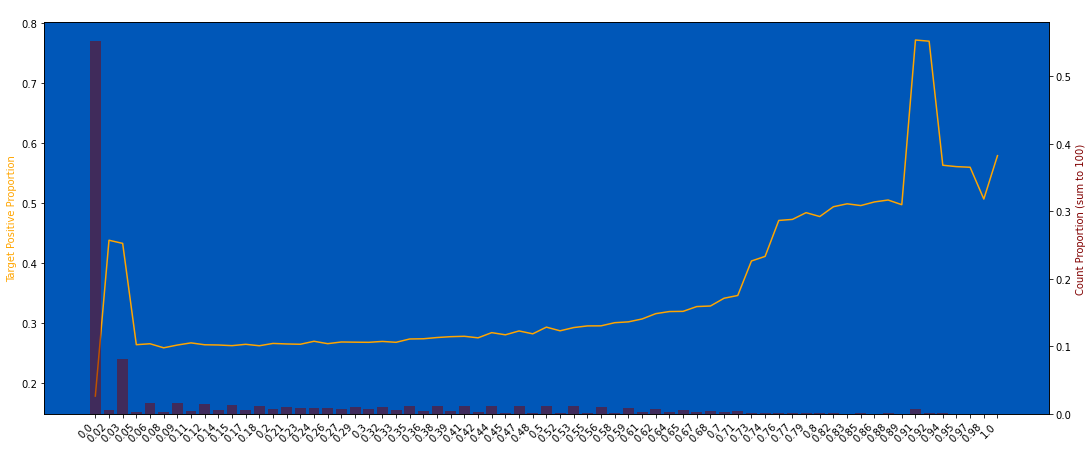

In [90]:
plot_target_check(train, "D_39", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

In [91]:
%%time
for df in df_list:
    df["D_39_"] = ((df["D_39"] - 0.02) / 0.0291).apply(np.floor)
    # df["D_39"] = df["D_39"].parallel_apply(lambda x: manual_stack(x, start=92, stack_interval=10, denom=1))

CPU times: user 62.8 ms, sys: 246 ms, total: 309 ms
Wall time: 104 ms


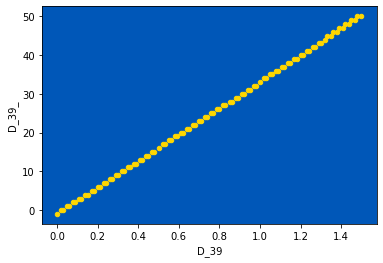

In [92]:
check_binning(train, "D_39", end=100)

In [93]:
%%time
for df in df_list:
    df["D_39"] = ((df["D_39"] - 0.02) / 0.0291).apply(np.floor).replace(-1, np.nan)

CPU times: user 606 ms, sys: 1.1 s, total: 1.71 s
Wall time: 2.59 s


3053463 null count, 0.552 null proportion
0.1787 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


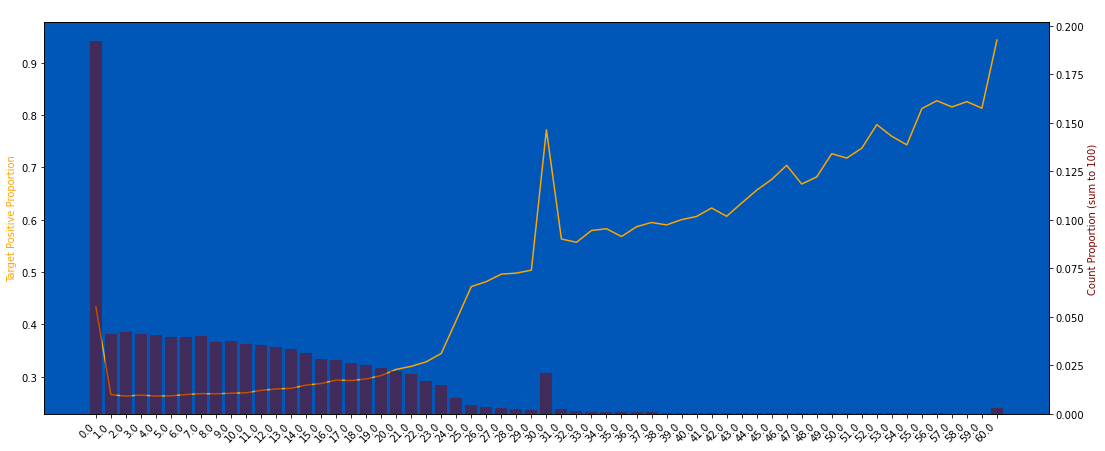

In [100]:
plot_target_check(train, "D_39", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Train-Public PSI: 0.0090, Train-Private PSI: 0.0162
Bottom 1% and Top 1% are dropped from this chart


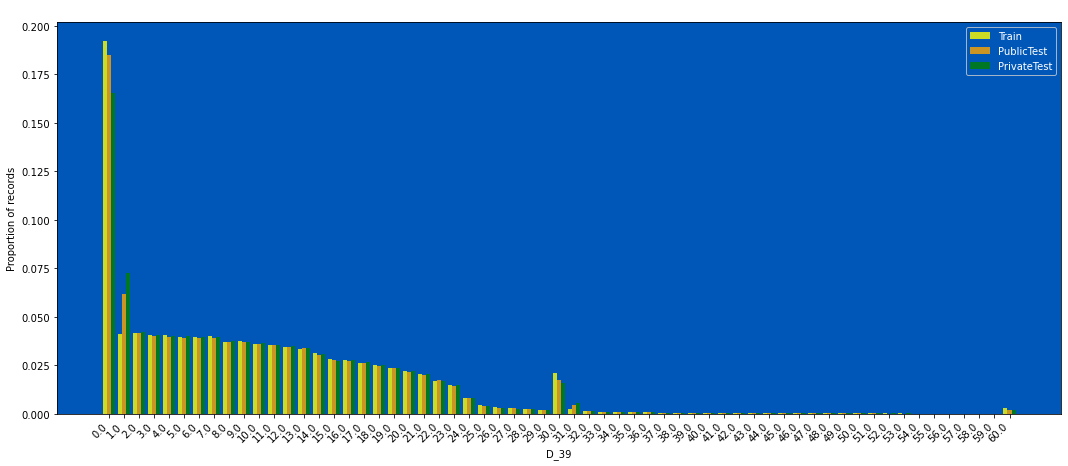

In [102]:
plot_train_test_distribution(df_list, "D_39", nunique_thr=1000)

In [103]:
# for df in tqdm(df_list):
#     df["D_39_"] = df["D_39"].values
#     c = check_summary(df, "D_39")
#     cid_list = c.loc[c["max"] == 0].customer_ID.tolist()
#     df.loc[(df["customer_ID"].isin(cid_list)) & (df["D_39_"] == 0), "D_39_"] = np.nan

### D_41

In [104]:
# plot_target_check(train, "D_41", q=50, use_raw_bin=True)

In [105]:
%%time
df_list = round_dfs(df_list, col="D_41", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0816
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0750
CPU times: user 2.48 s, sys: 5.6 s, total: 8.09 s
Wall time: 21.8 s


In [106]:
# %%time
# for df in df_list:
#     df["D_41_"] = df["D_41"].parallel_apply(lambda x: manual_stack(x, start=0.04, stack_interval=0.05, denom=100))

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


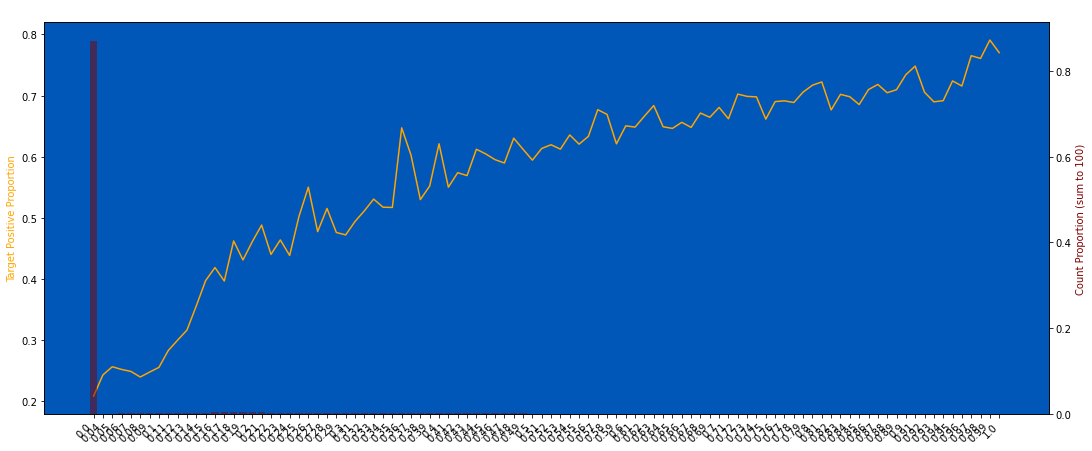

In [107]:
plot_target_check(train, "D_41", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=False)

Bottom 1% and Top 1% are dropped from this chart


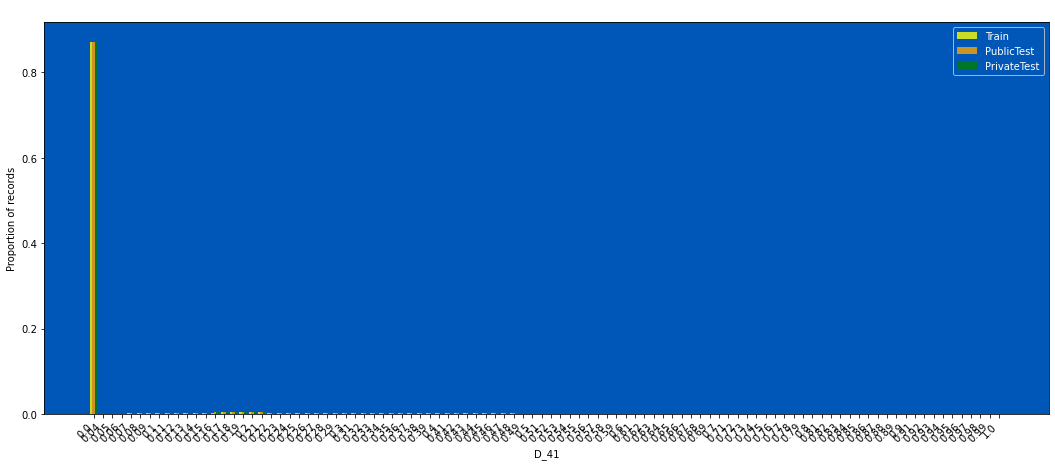

In [29]:
plot_train_test_distribution(df_list, "D_41", nunique_thr=1000)

### D_42

4740137 null count, 0.857 null proportion
0.2075 of the targets have label = 1


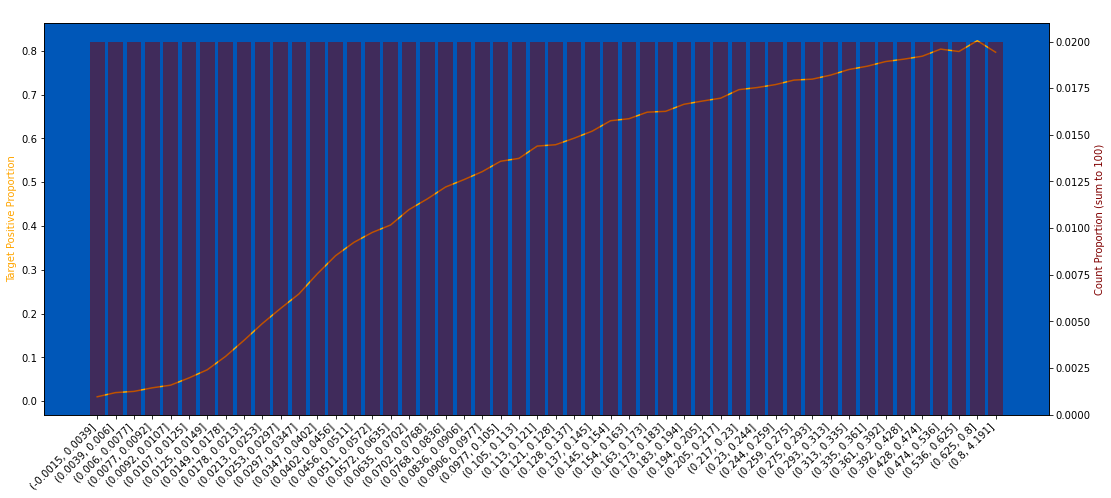

In [30]:
plot_target_check(train, "D_42", q=50, use_raw_bin=True)

In [31]:
%%time
df_list = round_dfs(df_list, col="D_42", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 381 ms, sys: 1.46 s, total: 1.84 s
Wall time: 2.91 s


4740137 null count, 0.857 null proportion
0.2075 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


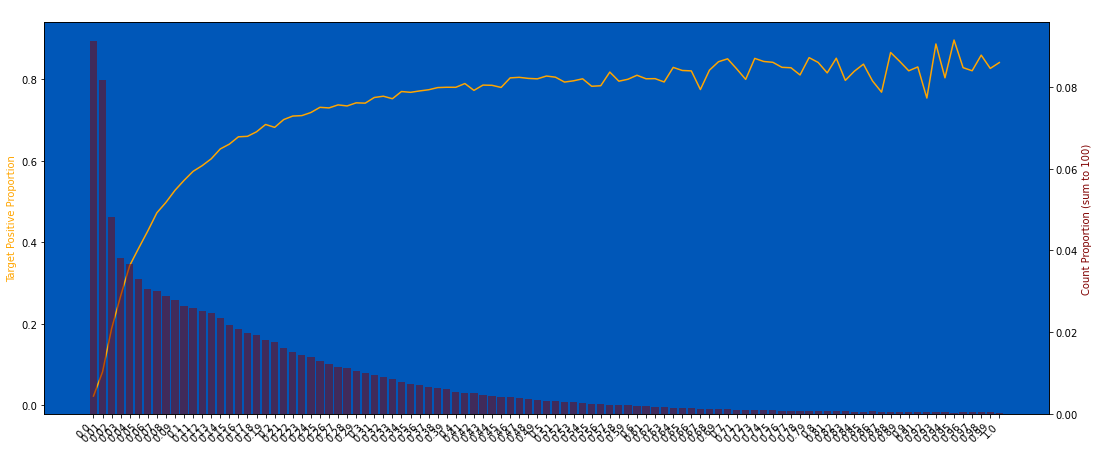

In [32]:
plot_target_check(train, "D_42", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


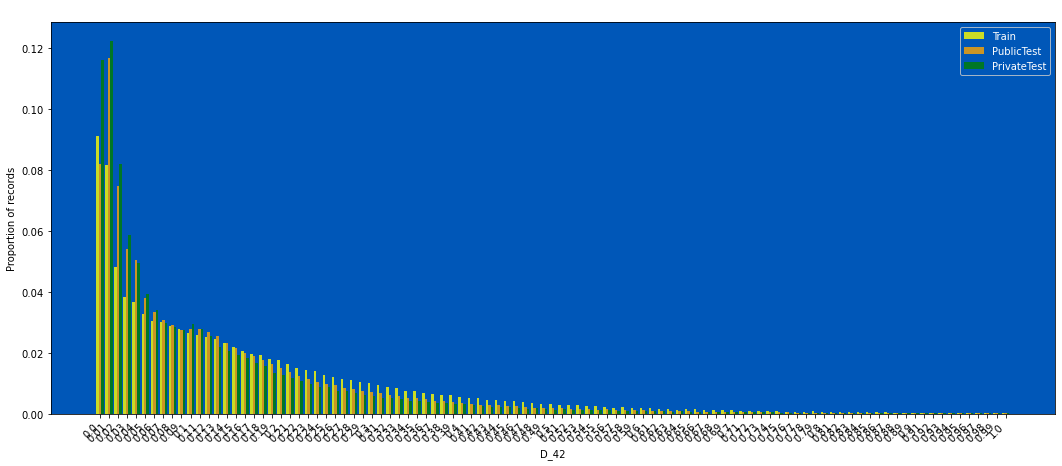

In [33]:
plot_train_test_distribution(df_list, "D_42", nunique_thr=1000)

**Train Test Drift: Heavy**

### D_43

1658396 null count, 0.300 null proportion
0.1673 of the targets have label = 1


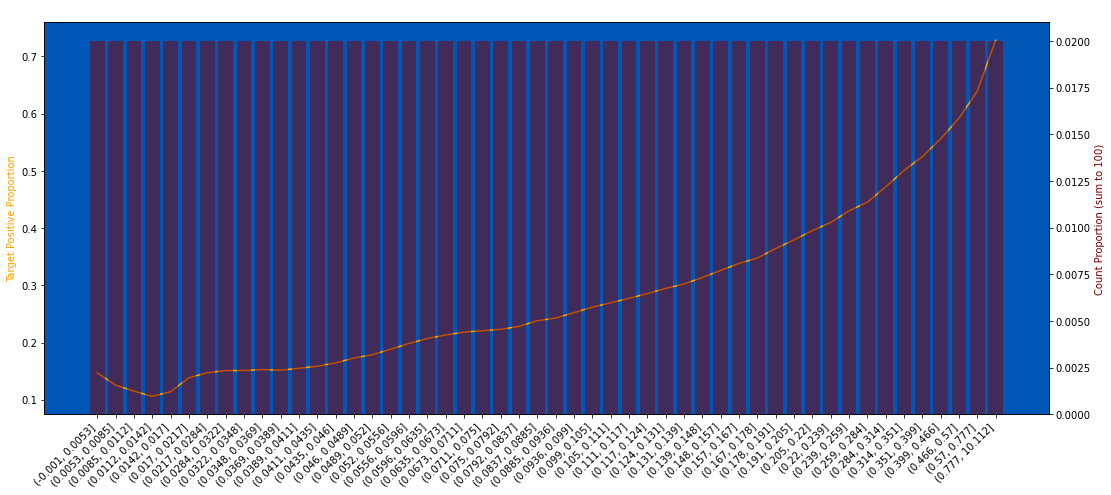

In [34]:
plot_target_check(train, "D_43", q=50, use_raw_bin=True)

In [35]:
%%time
df_list = round_dfs(df_list, col="D_43", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 366 ms, sys: 1.44 s, total: 1.81 s
Wall time: 2.77 s


1658396 null count, 0.300 null proportion
0.1673 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


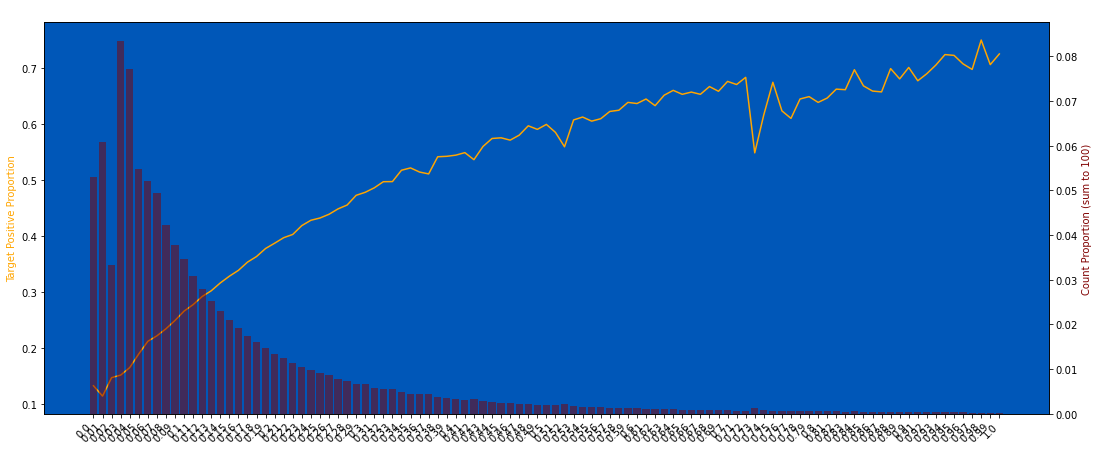

In [36]:
plot_target_check(train, "D_43", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


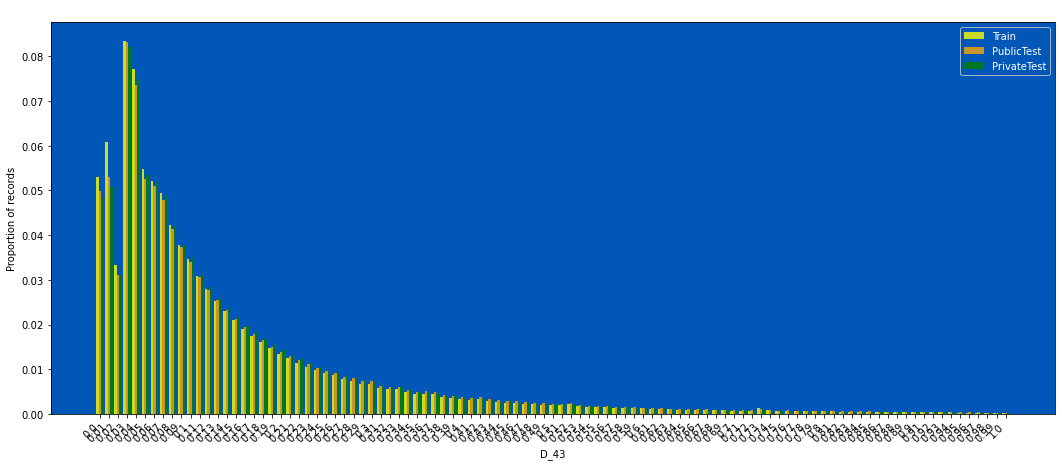

In [37]:
plot_train_test_distribution(df_list, "D_43", nunique_thr=1000)

**Train Test Drift: Moderate**

### D_44

274319 null count, 0.050 null proportion
0.2406 of the targets have label = 1


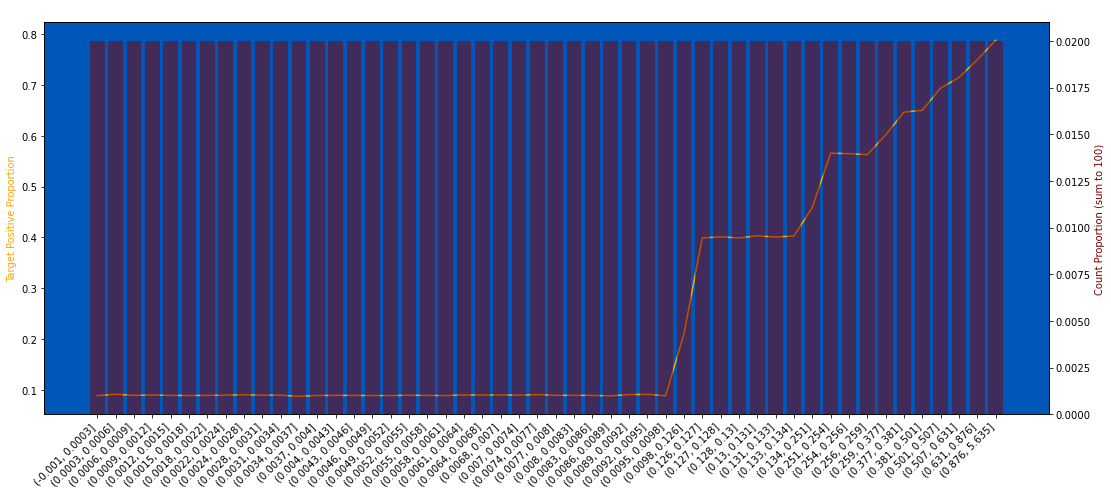

In [38]:
plot_target_check(train, "D_44", q=50, use_raw_bin=True, nunique_thr=1000)

In [39]:
%%time
df_list = round_dfs(df_list, col="D_44", decimals=2, add_new_col=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 143 ms, sys: 540 ms, total: 683 ms
Wall time: 1.6 s


274319 null count, 0.050 null proportion
0.2406 of the targets have label = 1


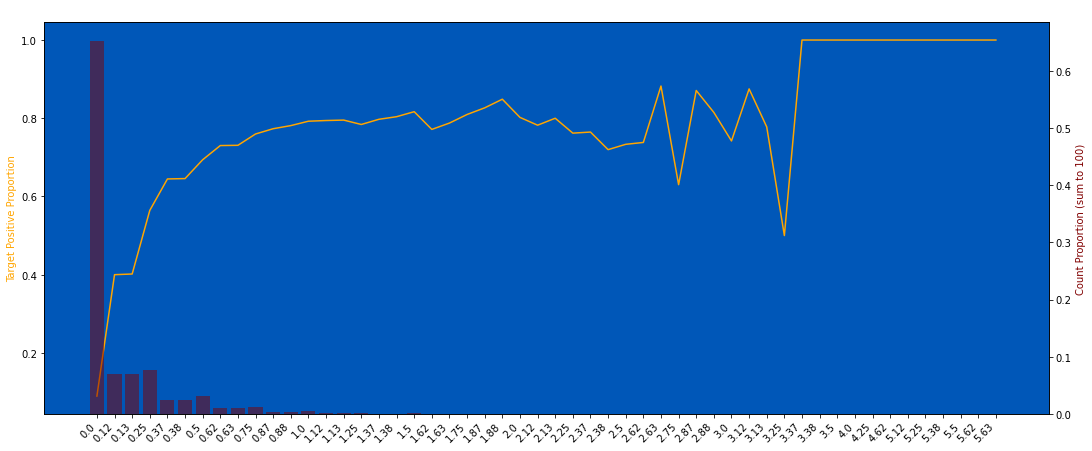

In [40]:
plot_target_check(train, "D_44_", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [41]:
%%time
for df in df_list:
    df["D_44_"] = (df["D_44"] * 8).round(0)

CPU times: user 380 ms, sys: 312 ms, total: 692 ms
Wall time: 291 ms


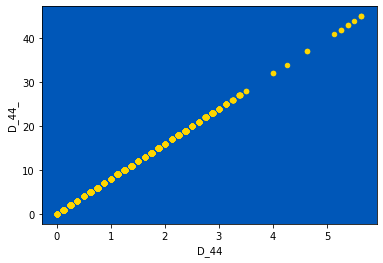

In [42]:
check_binning(train, "D_44", start=int(3e6), end=int(6e6))

In [43]:
%%time
for df in df_list:
    df["D_44"] = (df["D_44"] * 8).round(0)

CPU times: user 269 ms, sys: 1.26 s, total: 1.52 s
Wall time: 1.52 s


274319 null count, 0.050 null proportion
0.2406 of the targets have label = 1


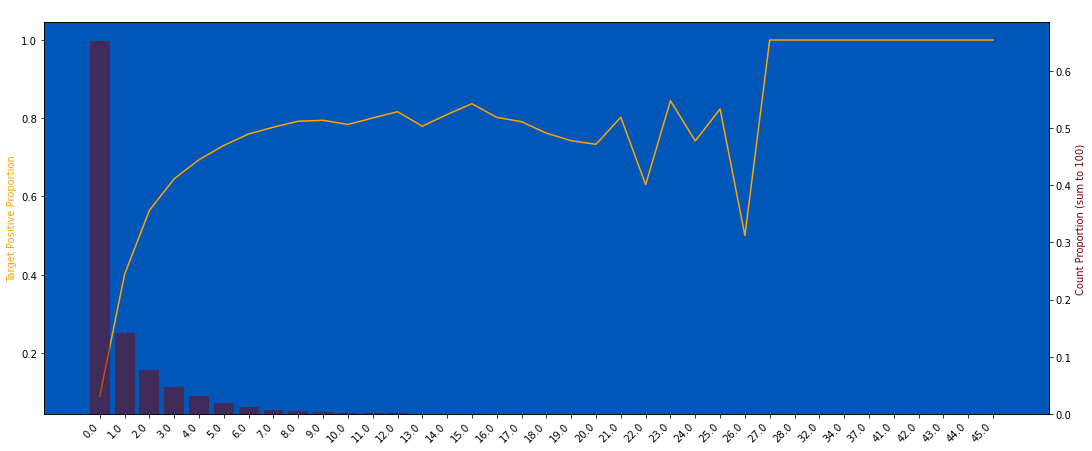

In [44]:
plot_target_check(train, "D_44", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

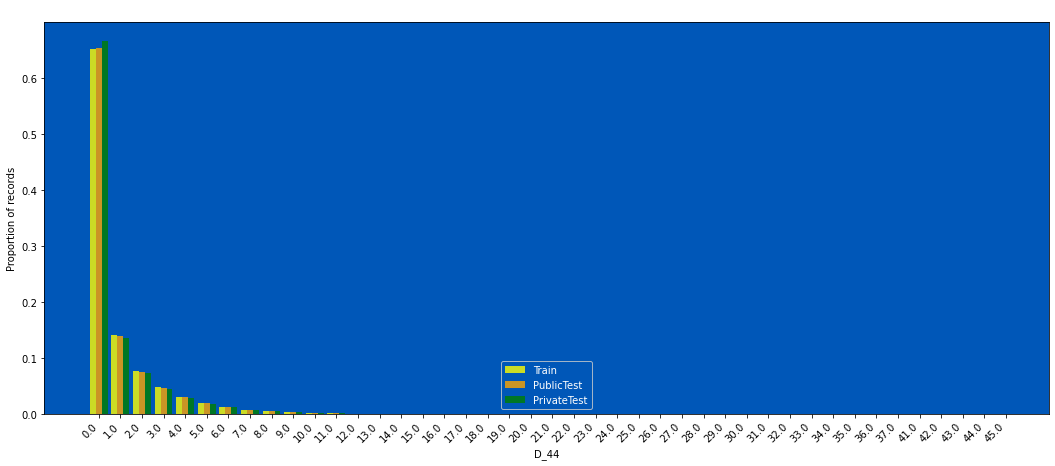

In [45]:
plot_train_test_distribution(df_list, "D_44", nunique_thr=1000, without_drop_tail=True)

### D_45

2017 null count, 0.000 null proportion
0.3560 of the targets have label = 1


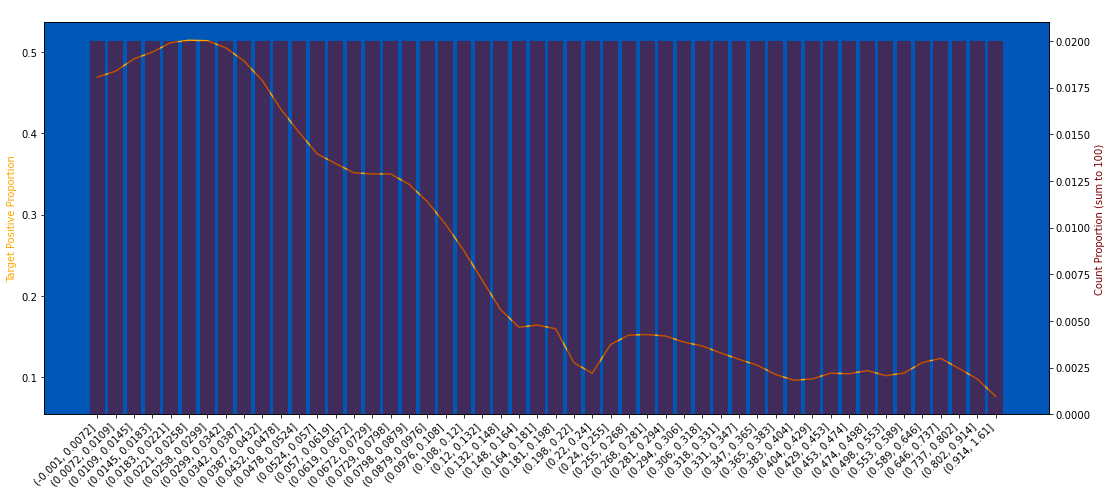

In [46]:
plot_target_check(train, "D_45", q=50, use_raw_bin=True)

In [47]:
%%time
df_list = round_dfs(df_list, col="D_45", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 387 ms, sys: 1.55 s, total: 1.94 s
Wall time: 2.83 s


2017 null count, 0.000 null proportion
0.3560 of the targets have label = 1


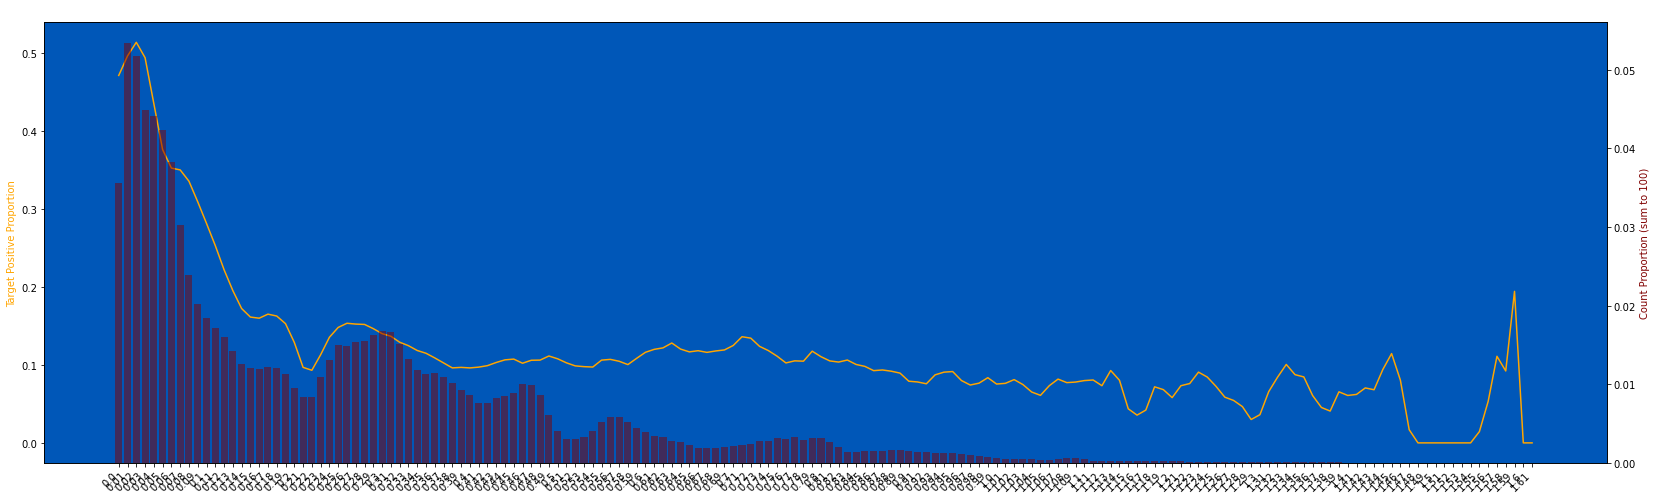

In [48]:
plot_target_check(train, "D_45", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True, figsize=(28, 9))

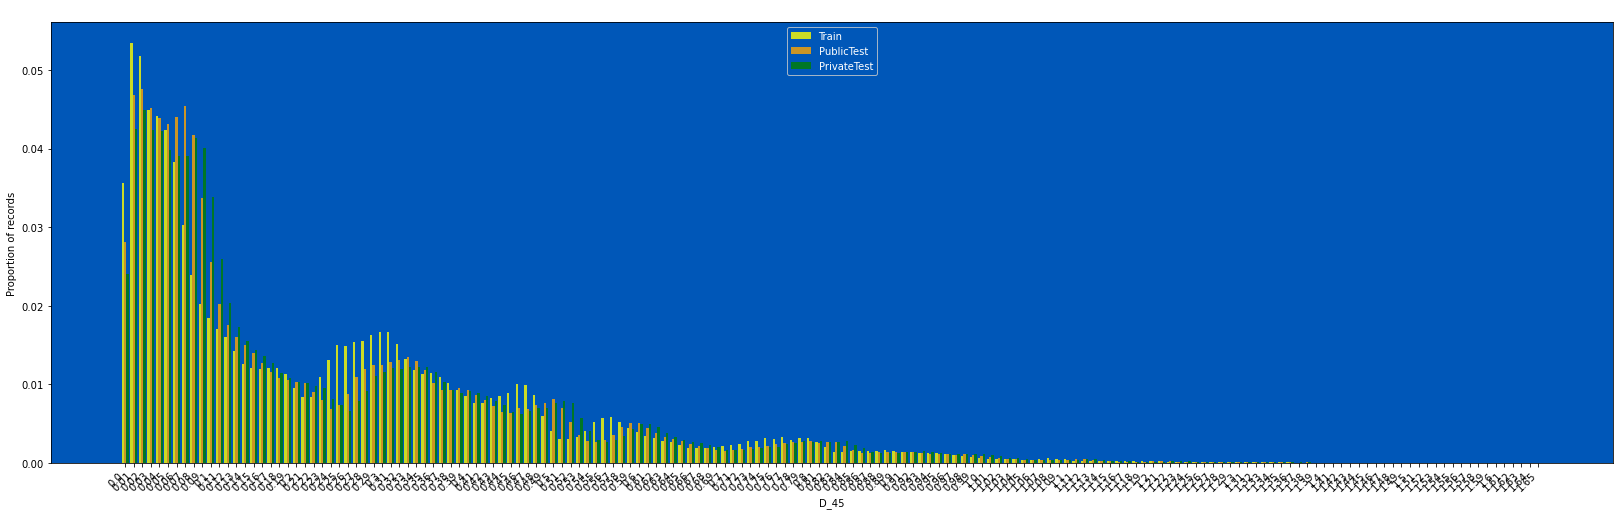

In [49]:
plot_train_test_distribution(df_list, "D_45", nunique_thr=8000, without_drop_tail=True, figsize=(28, 9))

**Train Test Drift: Heavy**

### D_46

1211699 null count, 0.219 null proportion
0.1940 of the targets have label = 1


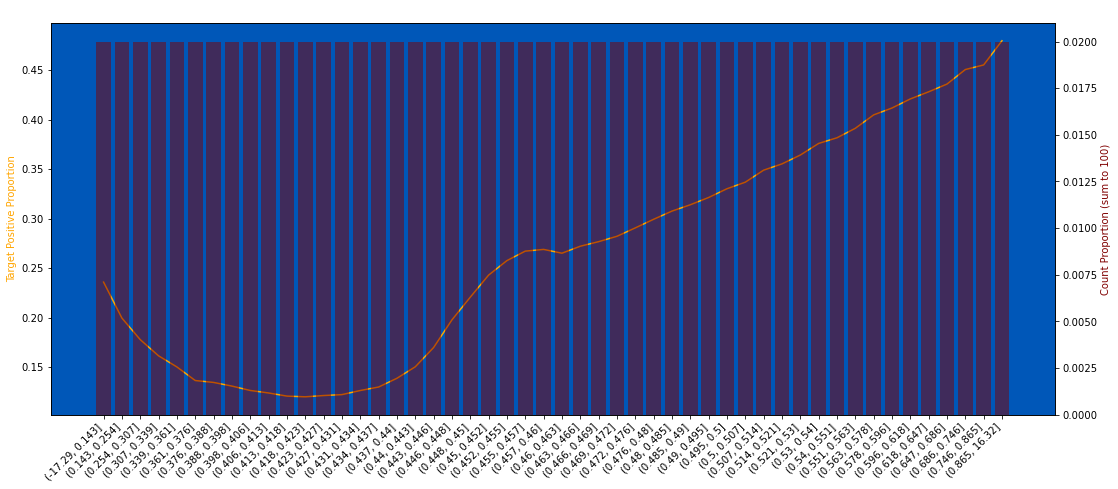

In [50]:
plot_target_check(train, "D_46", q=50, use_raw_bin=True)

In [51]:
%%time
df_list = round_dfs(df_list, col="D_46", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 362 ms, sys: 1.46 s, total: 1.82 s
Wall time: 2.77 s


1211699 null count, 0.219 null proportion
0.1940 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


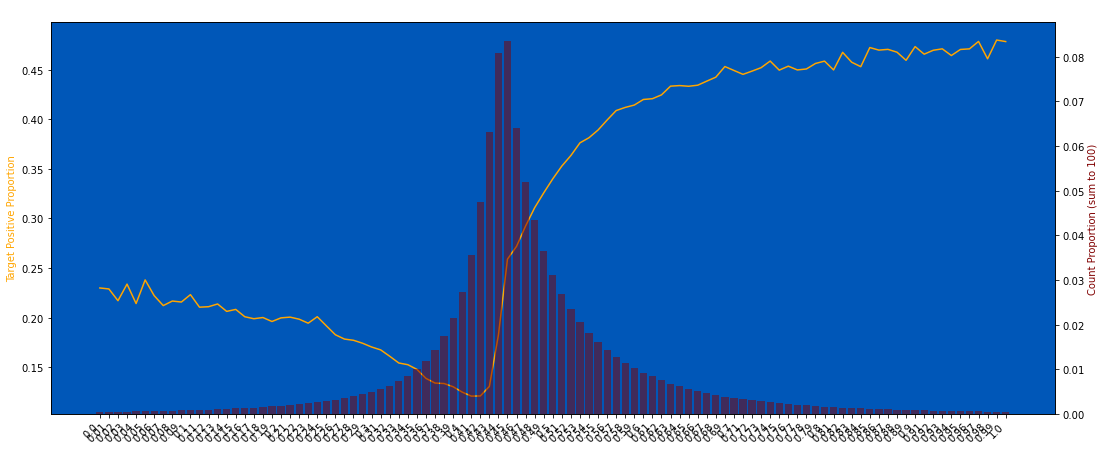

In [52]:
d46_summary = plot_target_check(train, "D_46", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, return_df=True)

- Similar pattern as P_3, can try feature crossing between them??

Bottom 1% and Top 1% are dropped from this chart


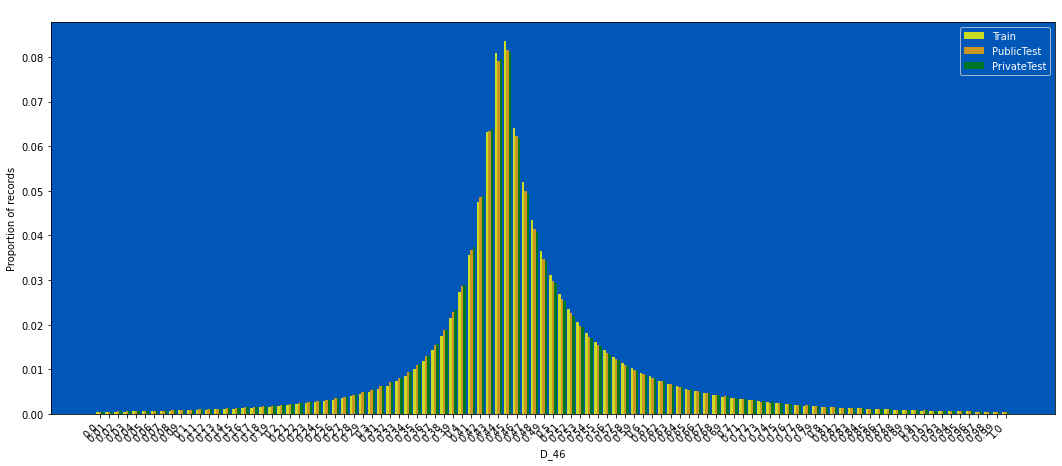

In [53]:
plot_train_test_distribution(df_list, "D_46", nunique_thr=8000)

**Train Test Drift: Moderate**

### D_47

0 null count, 0.000 null proportion
nan of the targets have label = 1


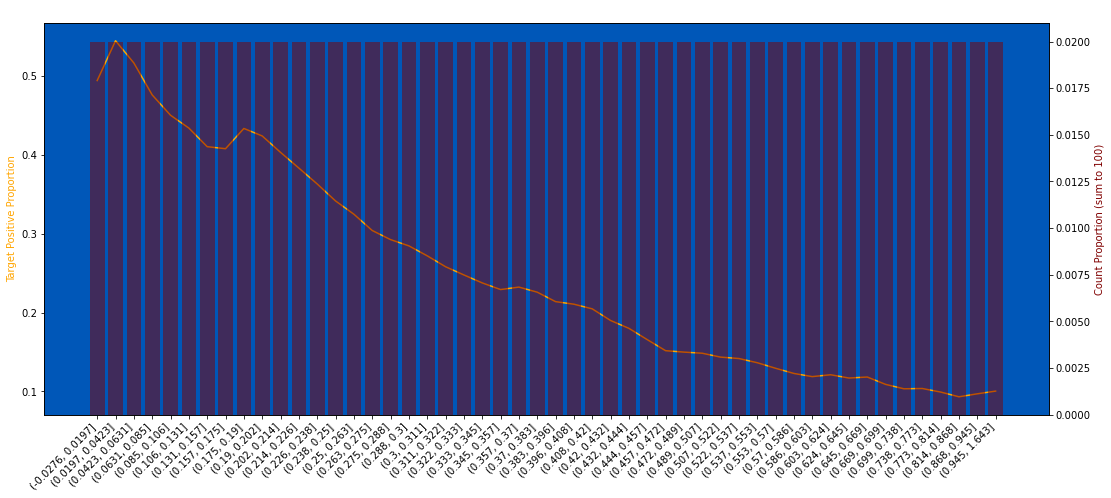

In [54]:
plot_target_check(train, "D_47", q=50, use_raw_bin=True)

In [55]:
%%time
df_list = round_dfs(df_list, col="D_47", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 355 ms, sys: 1.53 s, total: 1.89 s
Wall time: 2.79 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


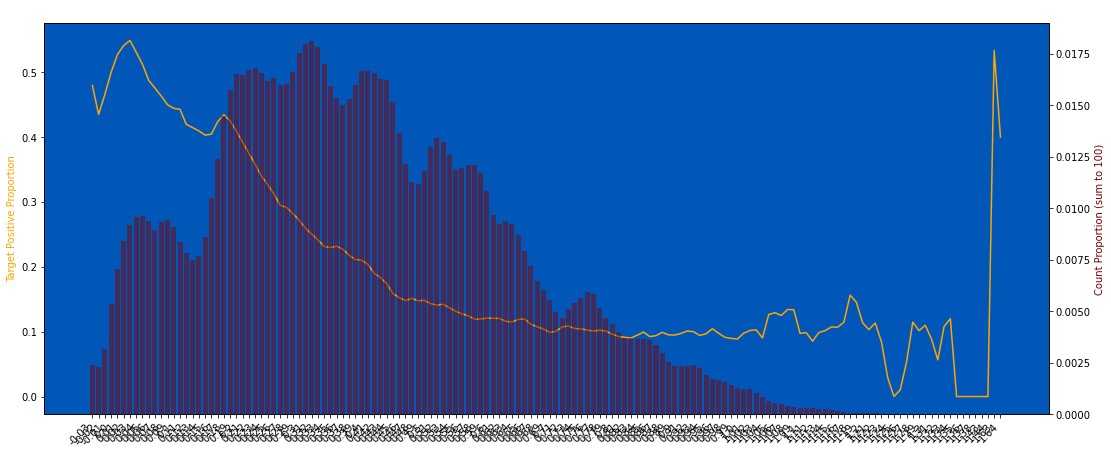

In [56]:
plot_target_check(train, "D_47", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

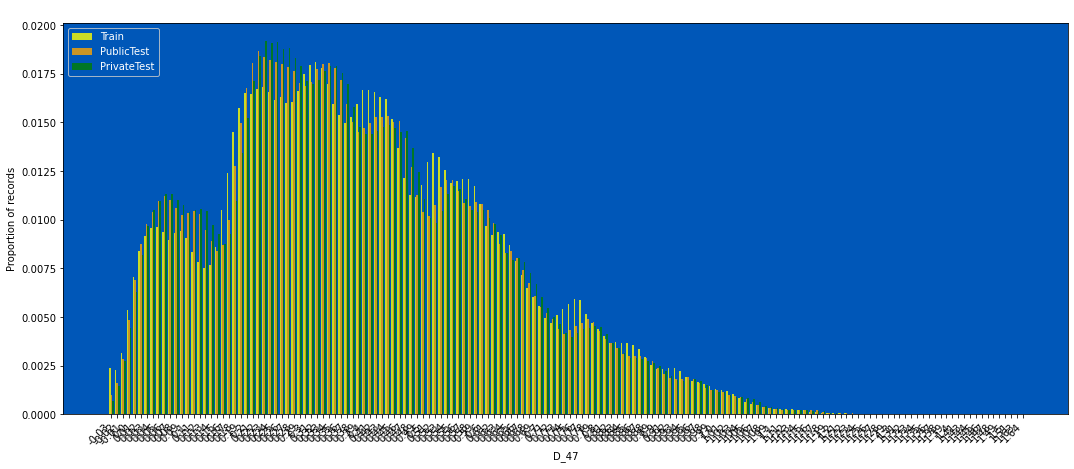

In [57]:
plot_train_test_distribution(df_list, "D_47", nunique_thr=8000, without_drop_tail=True)

**Train Test Drift: Heavy**

### D_48

718725 null count, 0.130 null proportion
0.1221 of the targets have label = 1


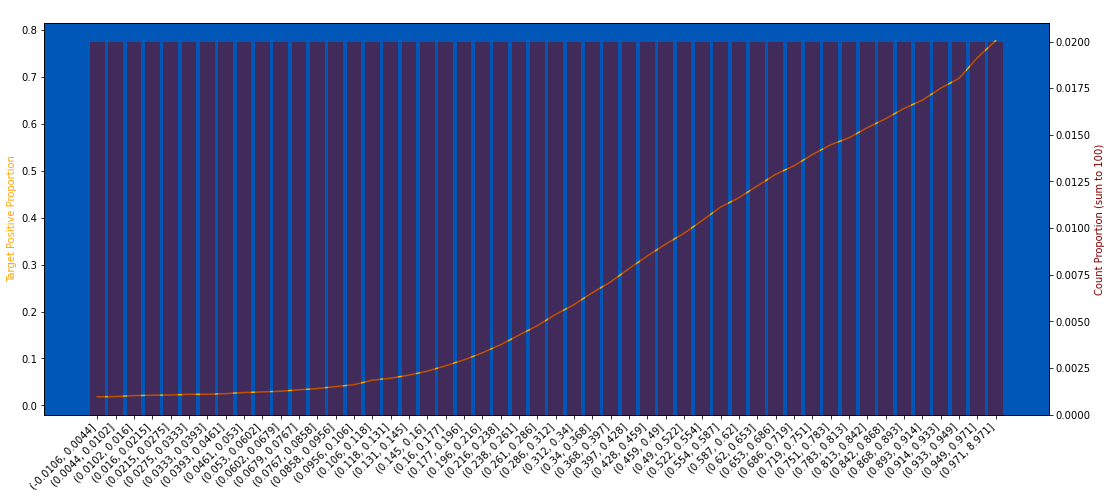

In [58]:
plot_target_check(train, "D_48", q=50, use_raw_bin=True)

In [59]:
%%time
df_list = round_dfs(df_list, col="D_48", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 348 ms, sys: 1.48 s, total: 1.83 s
Wall time: 2.81 s


718725 null count, 0.130 null proportion
0.1221 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


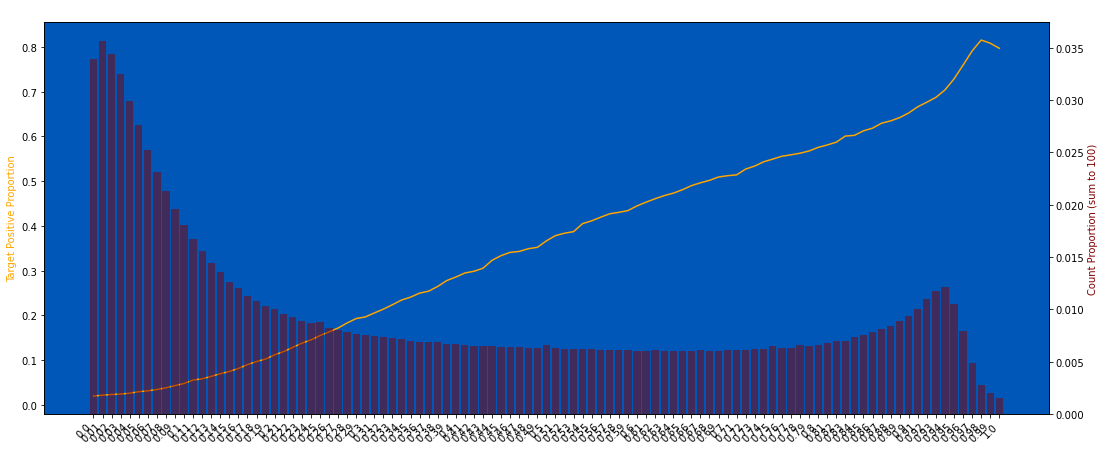

In [60]:
plot_target_check(train, "D_48", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


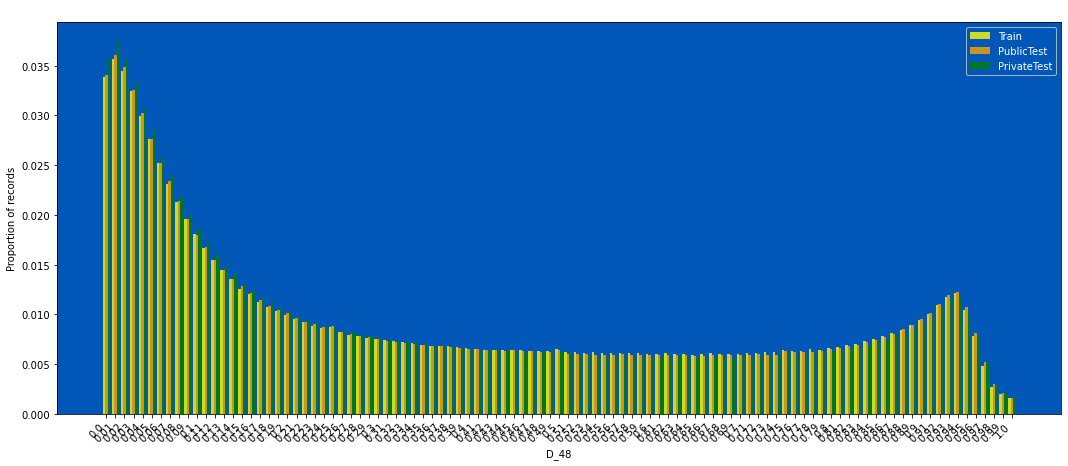

In [61]:
plot_train_test_distribution(df_list, "D_48", nunique_thr=8000)

### D_49

4985917 null count, 0.901 null proportion
0.2162 of the targets have label = 1


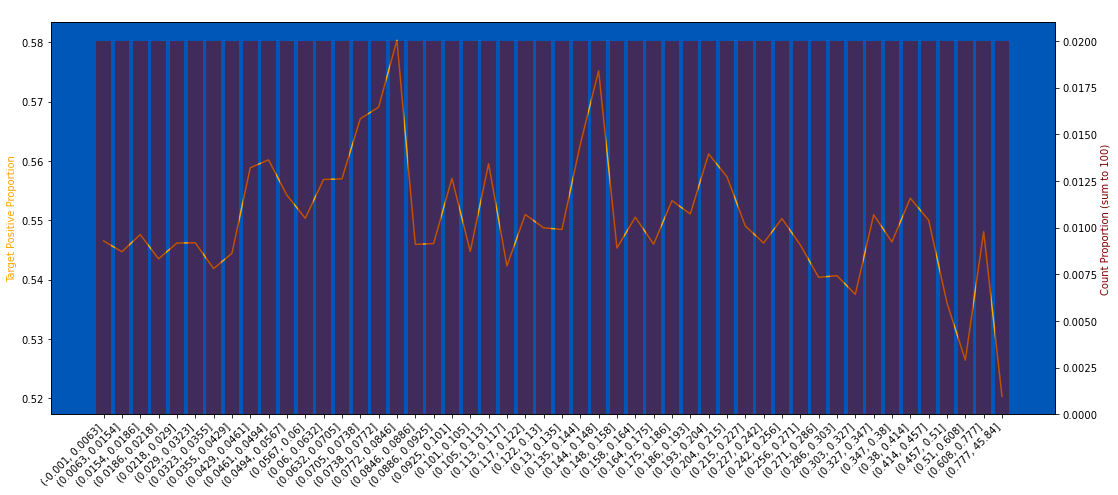

In [62]:
plot_target_check(train, "D_49", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

In [63]:
%%time
df_list = round_dfs(df_list, col="D_49", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 336 ms, sys: 1.52 s, total: 1.86 s
Wall time: 2.97 s


4985917 null count, 0.901 null proportion
0.2162 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


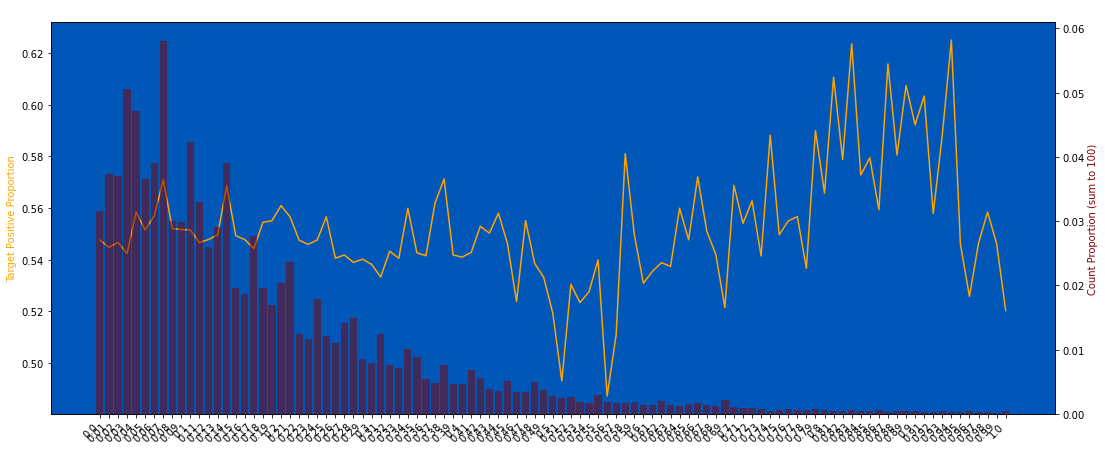

In [64]:
plot_target_check(train, "D_49", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


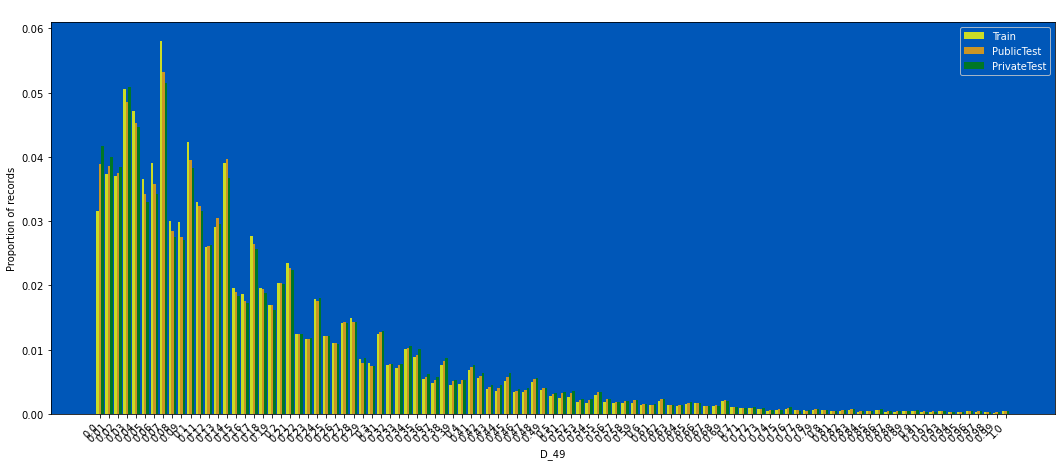

In [65]:
plot_train_test_distribution(df_list, "D_49", nunique_thr=1000)

**Train Test Drift: Moderate**

### D_50

3142402 null count, 0.568 null proportion
0.3005 of the targets have label = 1


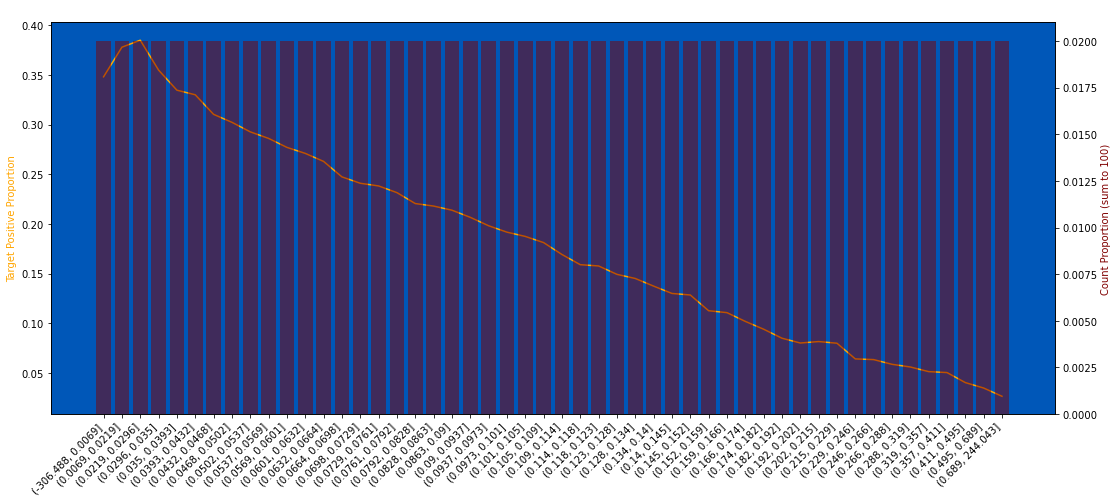

In [66]:
plot_target_check(train, "D_50", q=50, use_raw_bin=True)

In [67]:
%%time
df_list = round_dfs(df_list, col="D_50", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 345 ms, sys: 1.46 s, total: 1.81 s
Wall time: 2.84 s


3142402 null count, 0.568 null proportion
0.3005 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


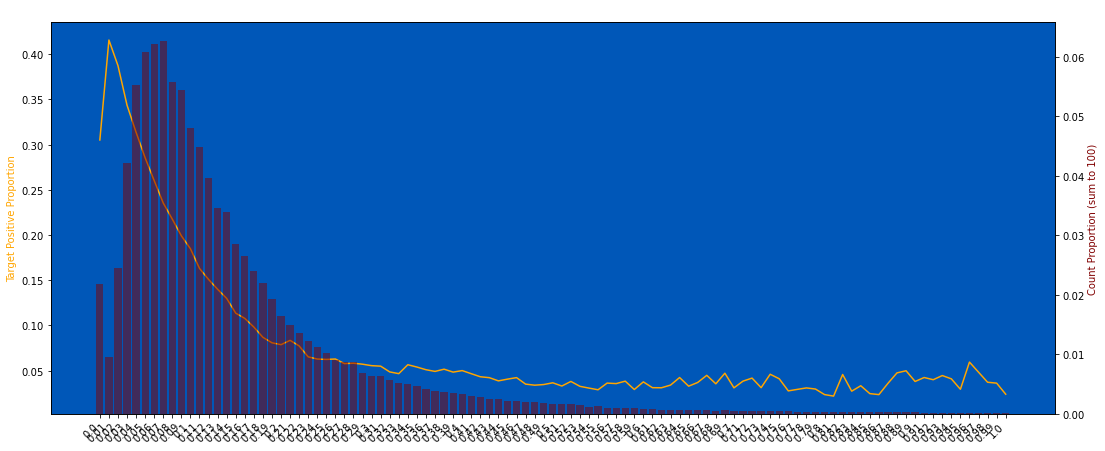

In [68]:
plot_target_check(train, "D_50", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


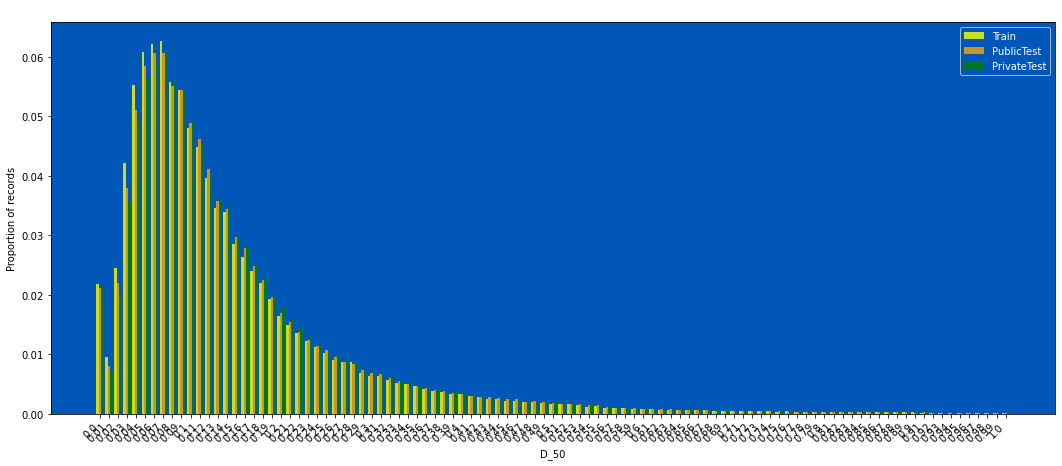

In [69]:
plot_train_test_distribution(df_list, "D_50", nunique_thr=10000)

**Train Test Drift: Moderate**

### D_51

0 null count, 0.000 null proportion
nan of the targets have label = 1


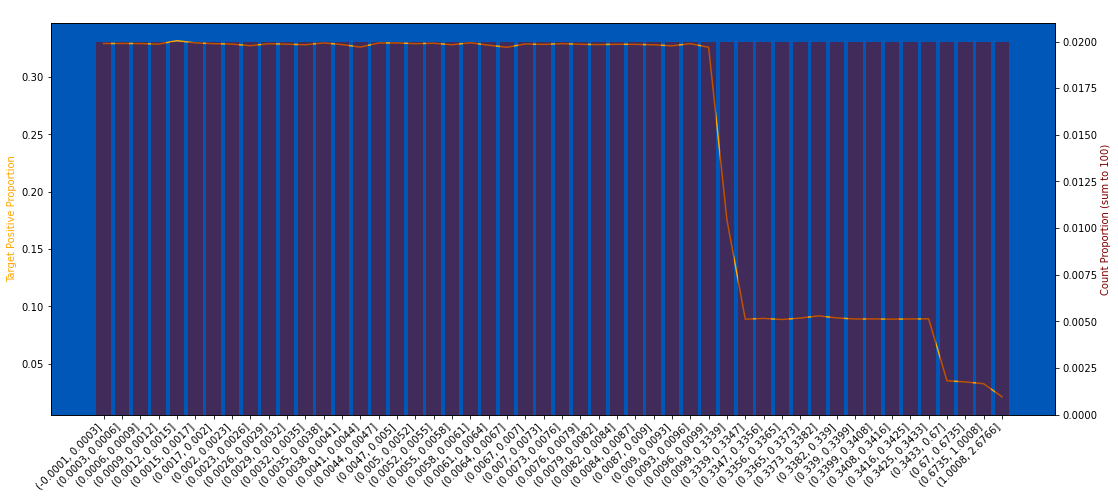

In [70]:
plot_target_check(train, "D_51", q=50, use_raw_bin=True, nunique_thr=10000)

In [71]:
%%time
df_list = round_dfs(df_list, col="D_51", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 338 ms, sys: 1.47 s, total: 1.81 s
Wall time: 2.71 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


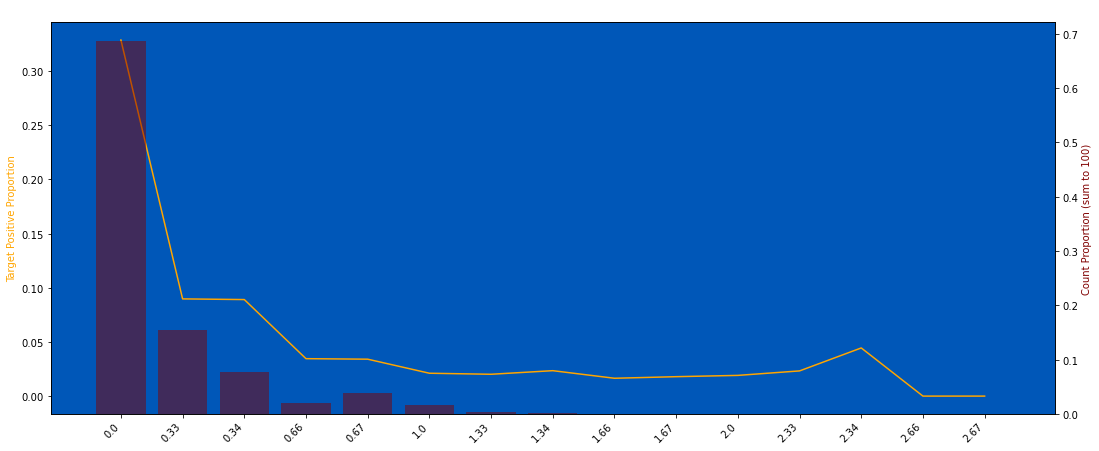

In [72]:
plot_target_check(train, "D_51", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

In [73]:
for df in df_list:
    df["D_51_"] = (df["D_51"] * 3).round(0)

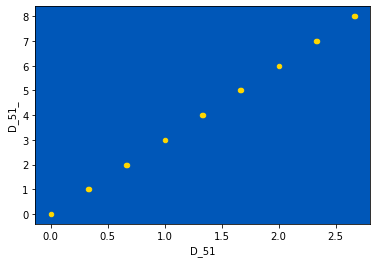

In [74]:
check_binning(train, "D_51", end=10000000)

In [75]:
for df in df_list:
    df["D_51"] = (df["D_51"] * 3).round(0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


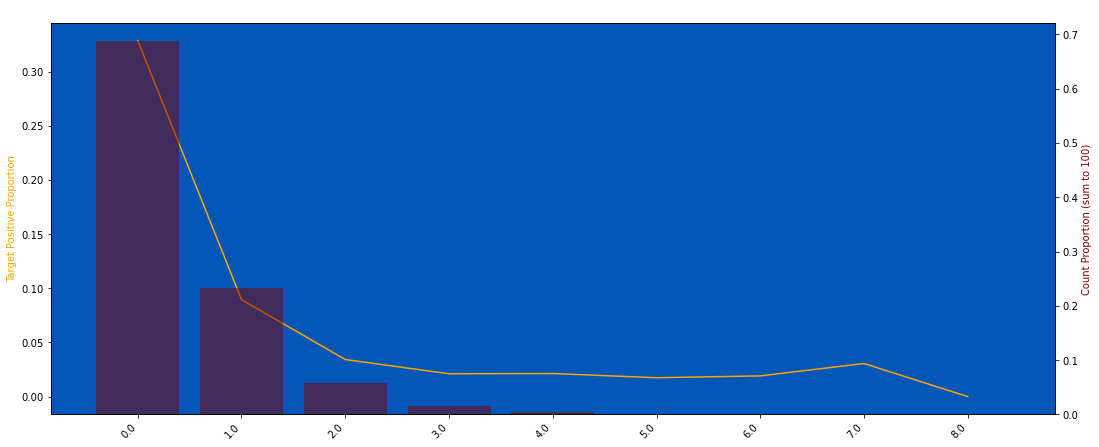

In [76]:
plot_target_check(train, "D_51", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

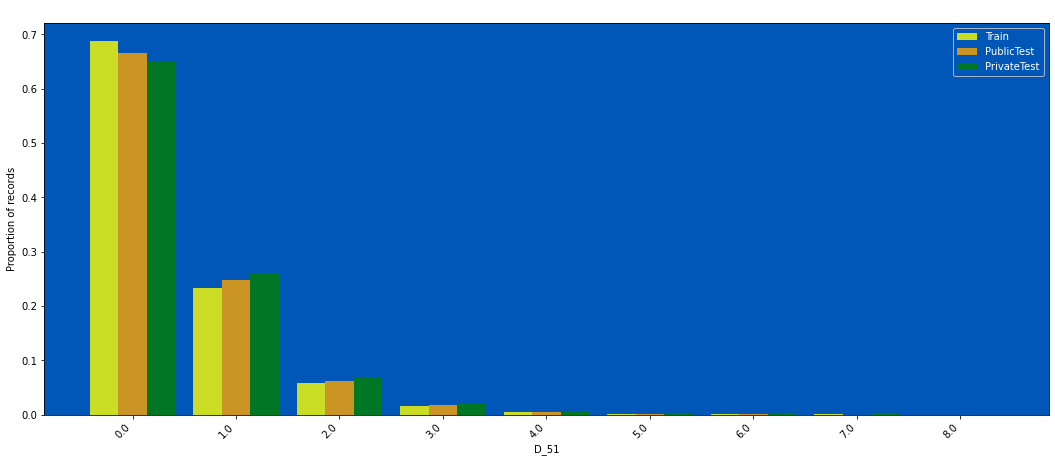

In [77]:
plot_train_test_distribution(df_list, "D_51", nunique_thr=1000, without_drop_tail=True)

### D_52

29563 null count, 0.005 null proportion
0.3523 of the targets have label = 1


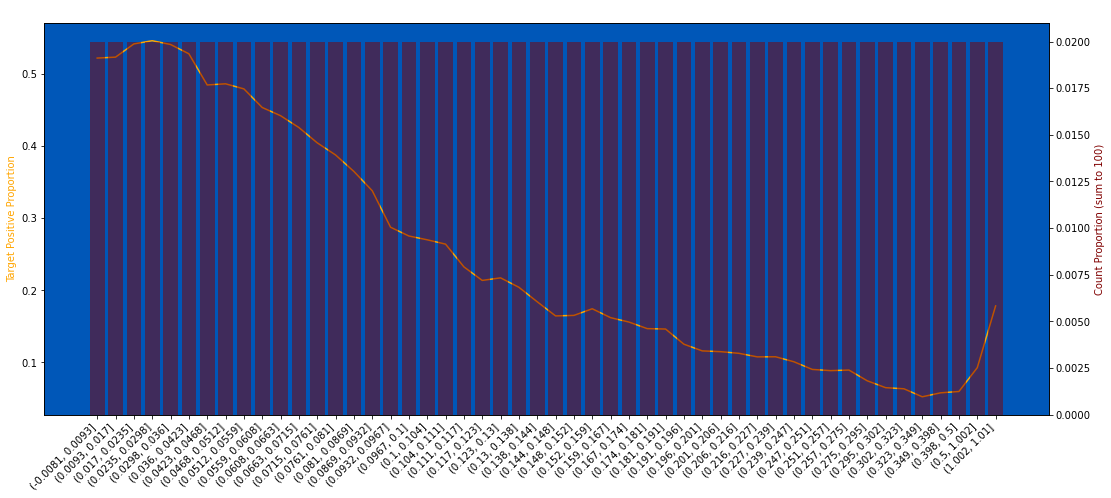

In [78]:
plot_target_check(train, "D_52", q=50, use_raw_bin=True)

In [79]:
%%time
df_list = round_dfs(df_list, col="D_52", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 371 ms, sys: 1.56 s, total: 1.93 s
Wall time: 2.96 s


29563 null count, 0.005 null proportion
0.3523 of the targets have label = 1


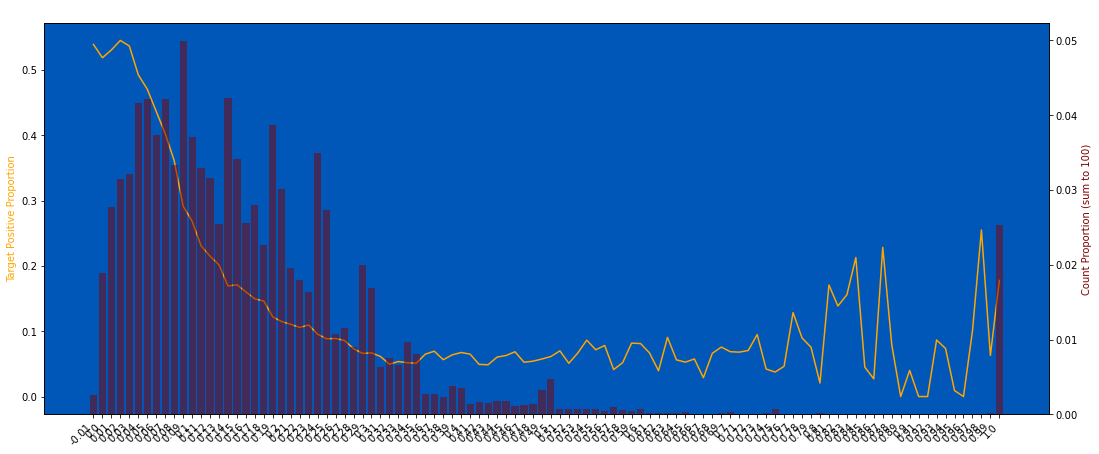

In [80]:
plot_target_check(train, "D_52", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

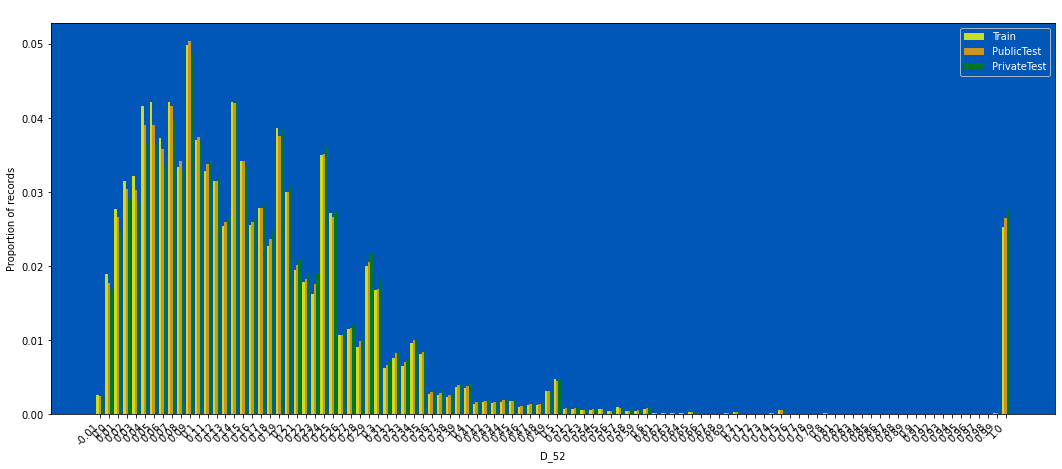

In [81]:
plot_train_test_distribution(df_list, "D_52", nunique_thr=1000, without_drop_tail=True)

**Train Test Drift: Moderate**

### D_53

4084585 null count, 0.738 null proportion
0.1836 of the targets have label = 1


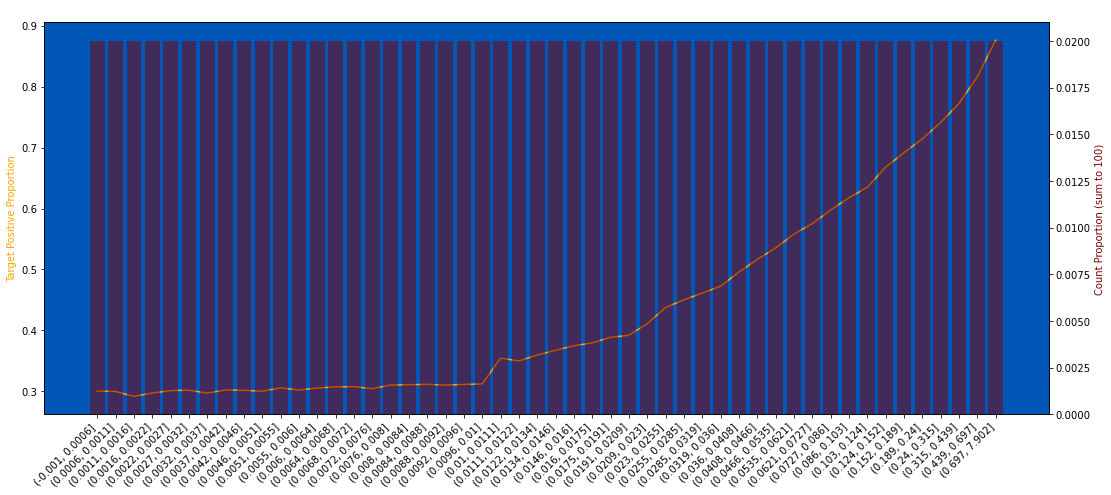

In [82]:
plot_target_check(train, "D_53", q=50, use_raw_bin=True)

In [83]:
%%time
df_list = round_dfs(df_list, col="D_53", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 332 ms, sys: 1.42 s, total: 1.76 s
Wall time: 2.84 s


4084585 null count, 0.738 null proportion
0.1836 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


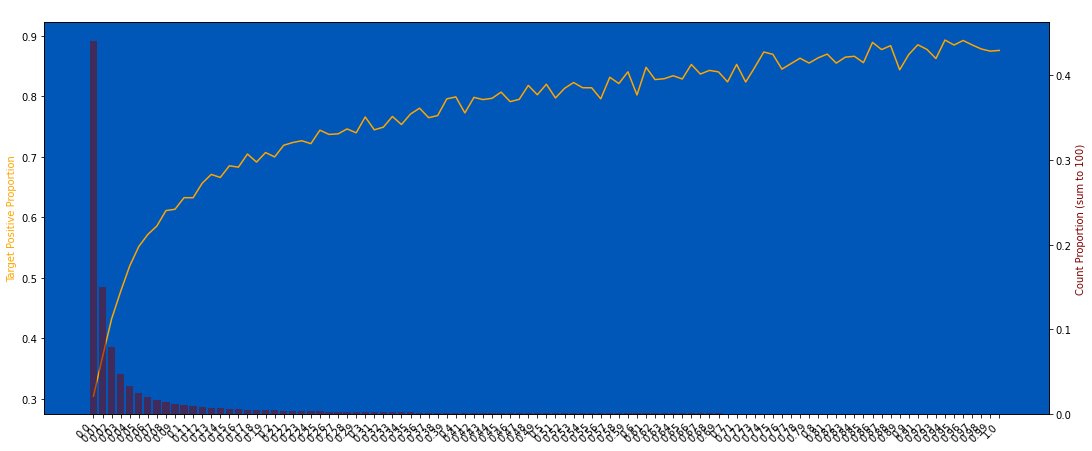

In [84]:
plot_target_check(train, "D_53", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


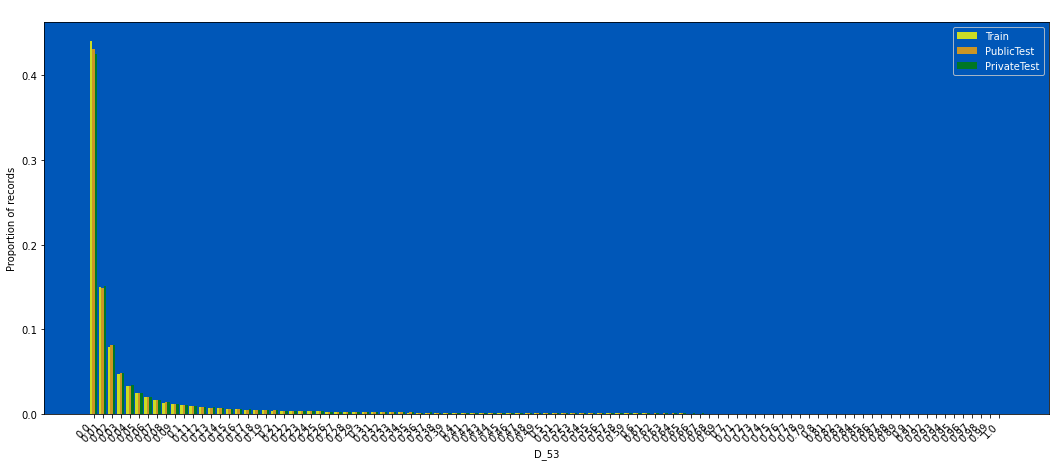

In [85]:
plot_train_test_distribution(df_list, "D_53", nunique_thr=1000)

### D_54

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


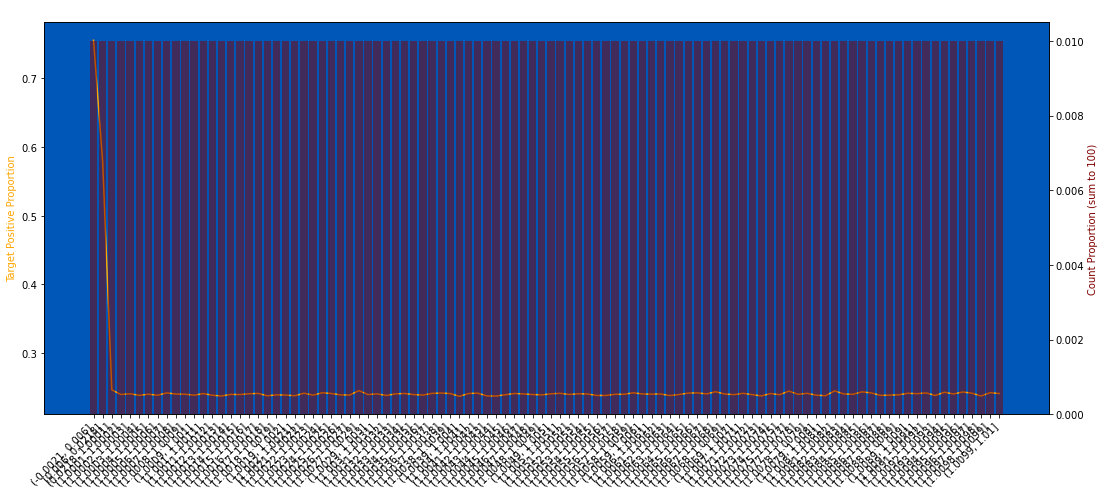

In [86]:
plot_target_check(train, "D_54", q=100, use_raw_bin=True)

In [87]:
for df in df_list:
    df["D_54"] = df["D_54"].round(0)

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


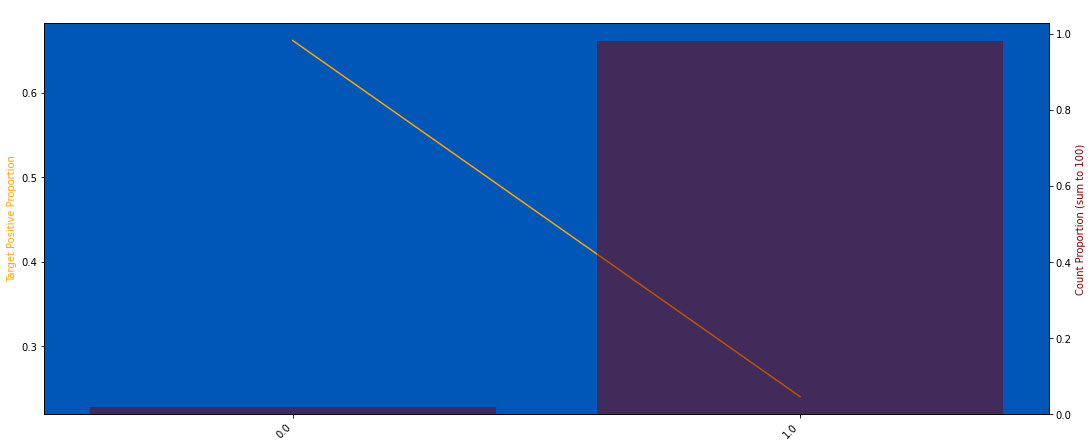

In [88]:
plot_target_check(train, "D_54", q=100, use_raw_bin=True, nunique_thr=4000, strfy_x=True, without_drop_tail=True)

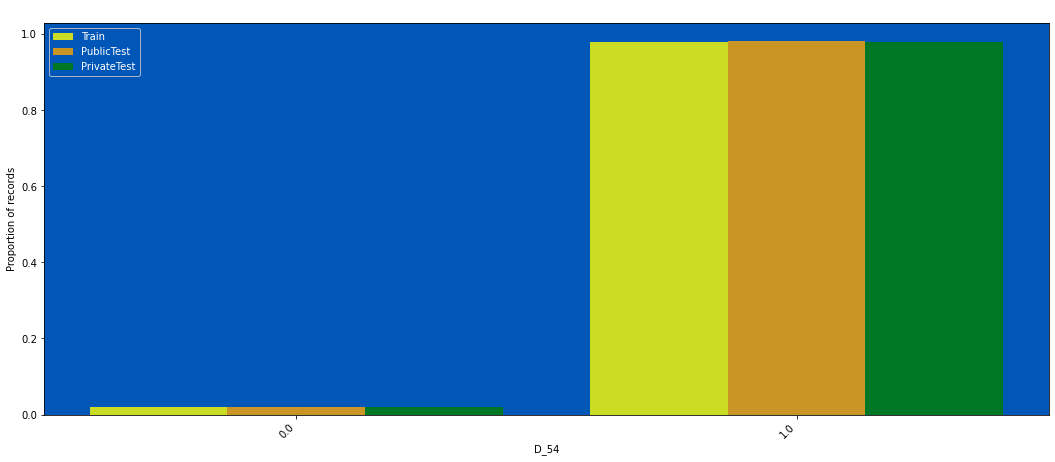

In [89]:
plot_train_test_distribution(df_list, "D_54", without_drop_tail=True)

### D_55

184803 null count, 0.033 null proportion
0.1759 of the targets have label = 1


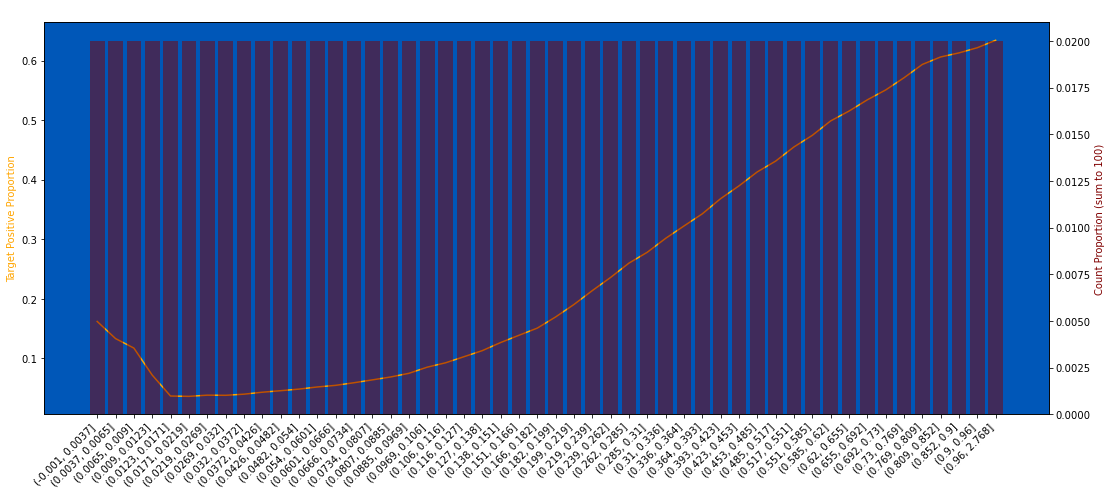

In [90]:
plot_target_check(train, "D_55", q=50, use_raw_bin=True)

In [91]:
%%time
df_list = round_dfs(df_list, col="D_55", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 335 ms, sys: 1.45 s, total: 1.78 s
Wall time: 2.74 s


184803 null count, 0.033 null proportion
0.1759 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


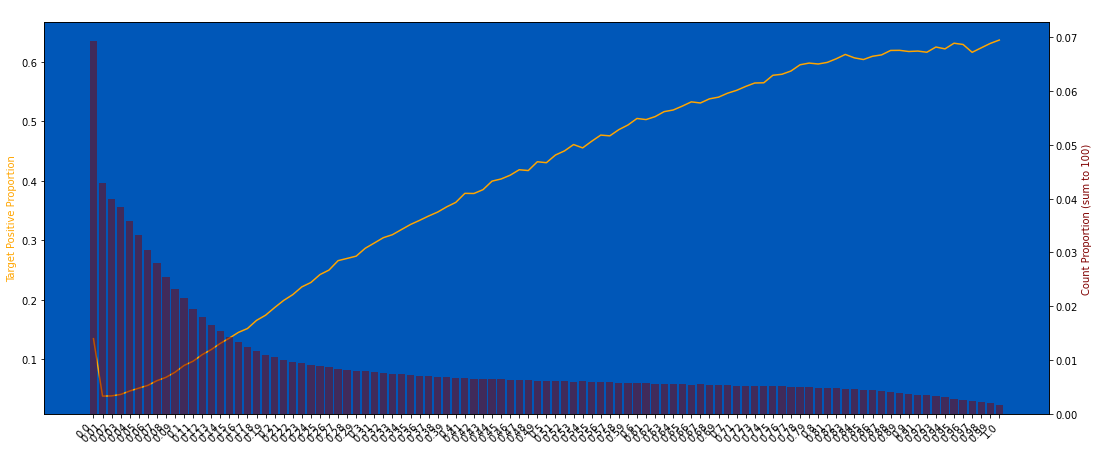

In [92]:
plot_target_check(train, "D_55", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


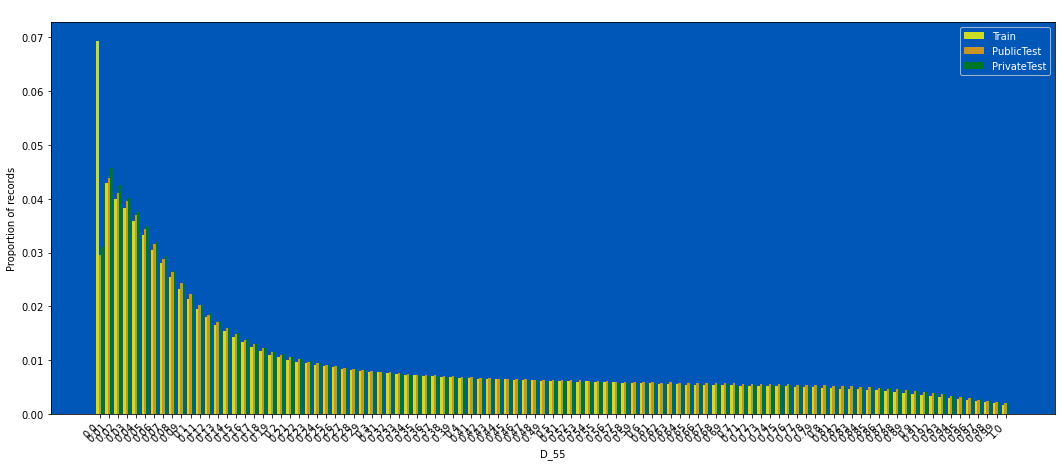

In [93]:
plot_train_test_distribution(df_list, "D_55", nunique_thr=1000)

**Train Test Drift: Heavy (on 0.0)**

### D_56

2990943 null count, 0.541 null proportion
0.3282 of the targets have label = 1


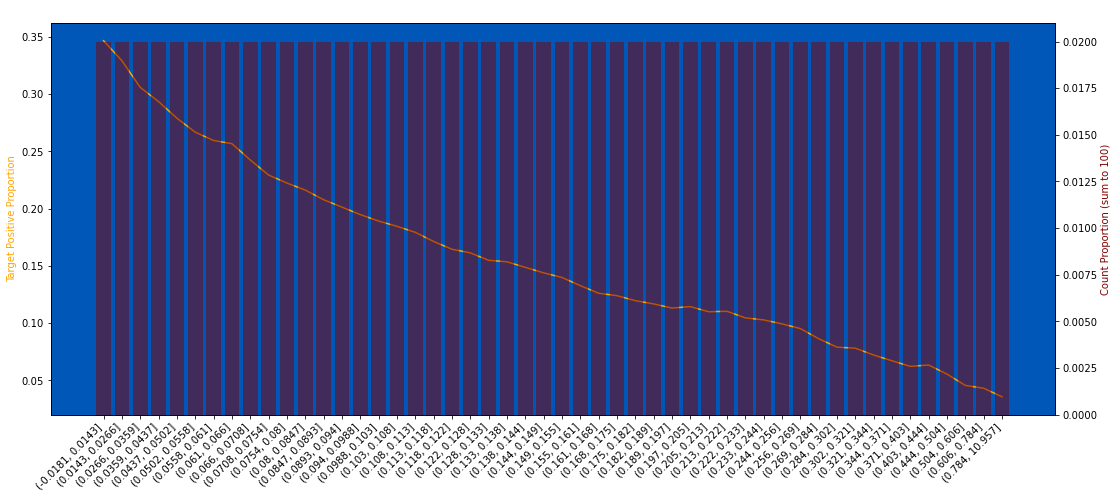

In [94]:
plot_target_check(train, "D_56", q=50, use_raw_bin=True)

In [95]:
%%time
df_list = round_dfs(df_list, col="D_56", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 323 ms, sys: 1.4 s, total: 1.72 s
Wall time: 2.72 s


2990943 null count, 0.541 null proportion
0.3282 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


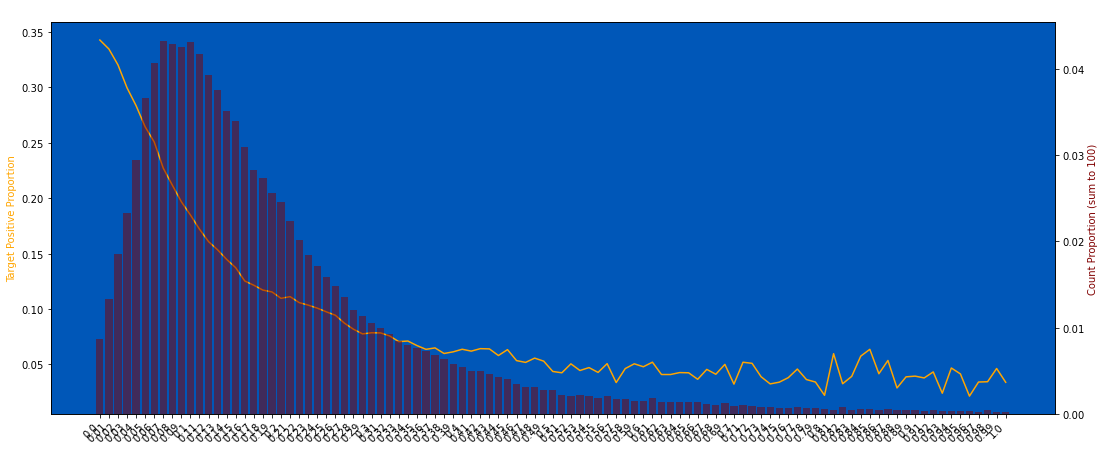

In [96]:
plot_target_check(train, "D_56", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


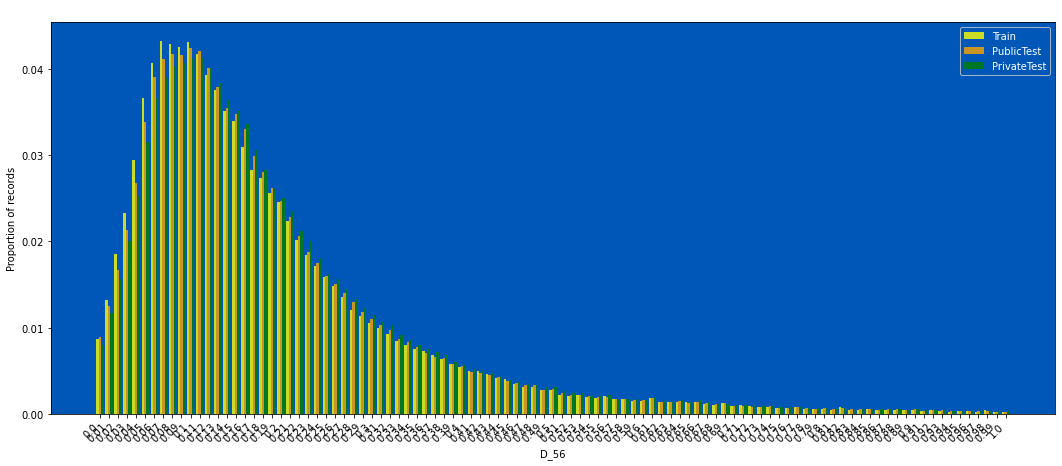

In [97]:
plot_train_test_distribution(df_list, "D_56", nunique_thr=1000)

**Train Test Drift**
- Heavy

### D_58

0 null count, 0.000 null proportion
nan of the targets have label = 1


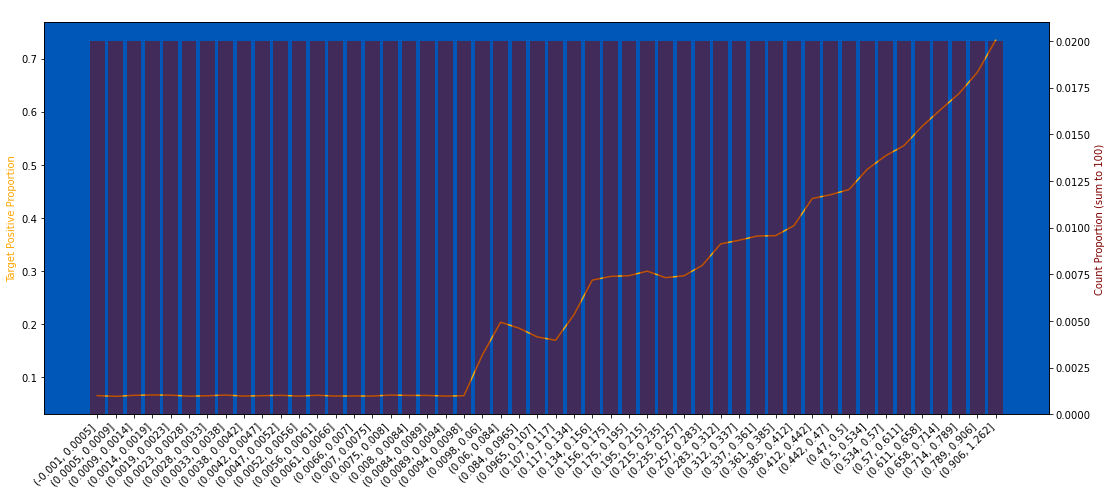

In [98]:
plot_target_check(train, "D_58", q=50, use_raw_bin=True)

In [99]:
%%time
df_list = round_dfs(df_list, col="D_58", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 322 ms, sys: 1.44 s, total: 1.76 s
Wall time: 2.69 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


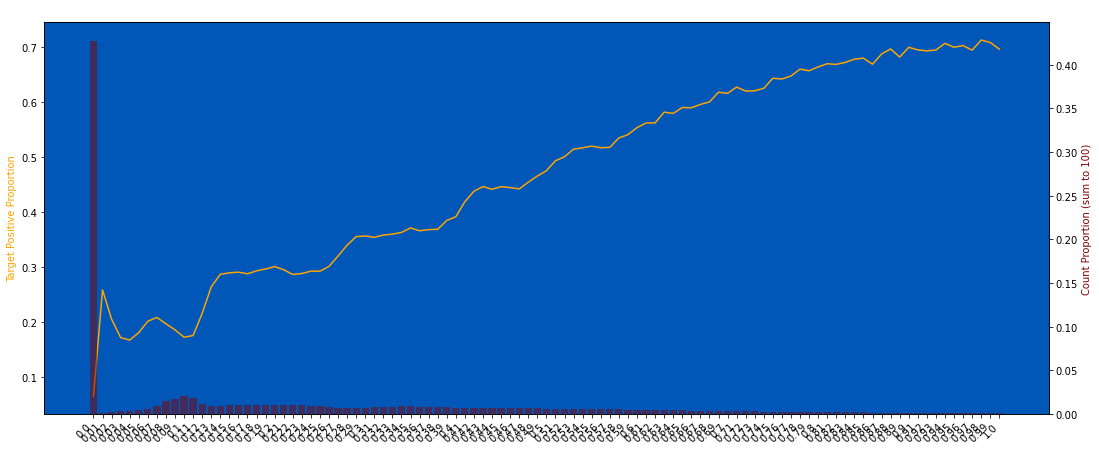

In [100]:
plot_target_check(train, "D_58", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


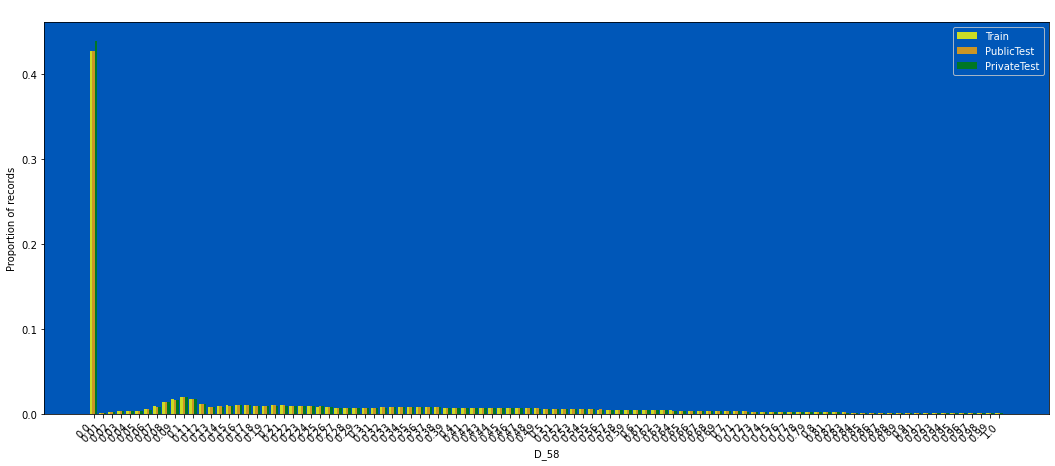

In [101]:
plot_train_test_distribution(df_list, "D_58", nunique_thr=1000)

### D_59

106725 null count, 0.019 null proportion
0.4218 of the targets have label = 1


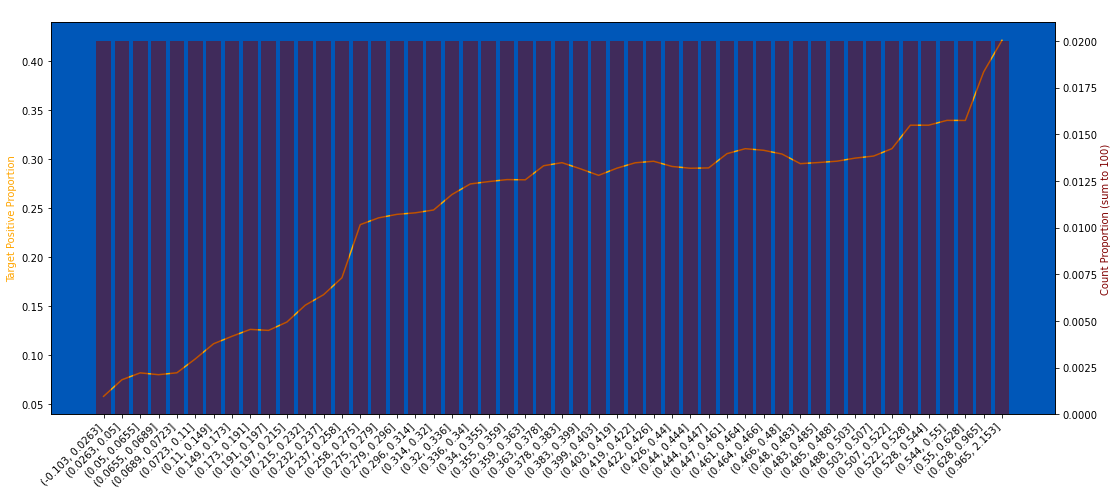

In [102]:
plot_target_check(train, "D_59", q=50, use_raw_bin=True, nunique_thr=1000)

In [103]:
%%time
df_list = round_dfs(df_list, col="D_59", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 324 ms, sys: 1.44 s, total: 1.77 s
Wall time: 2.71 s


106725 null count, 0.019 null proportion
0.4218 of the targets have label = 1


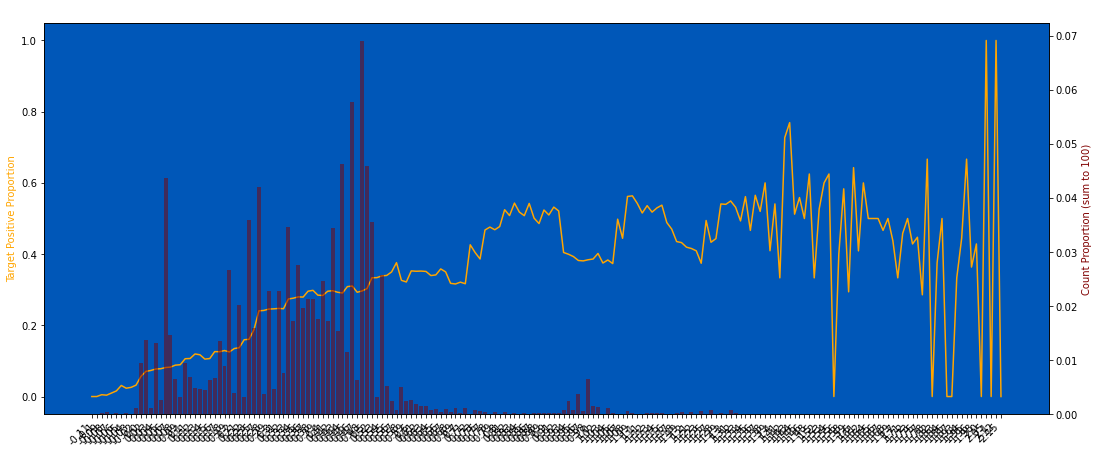

In [104]:
plot_target_check(train, "D_59", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

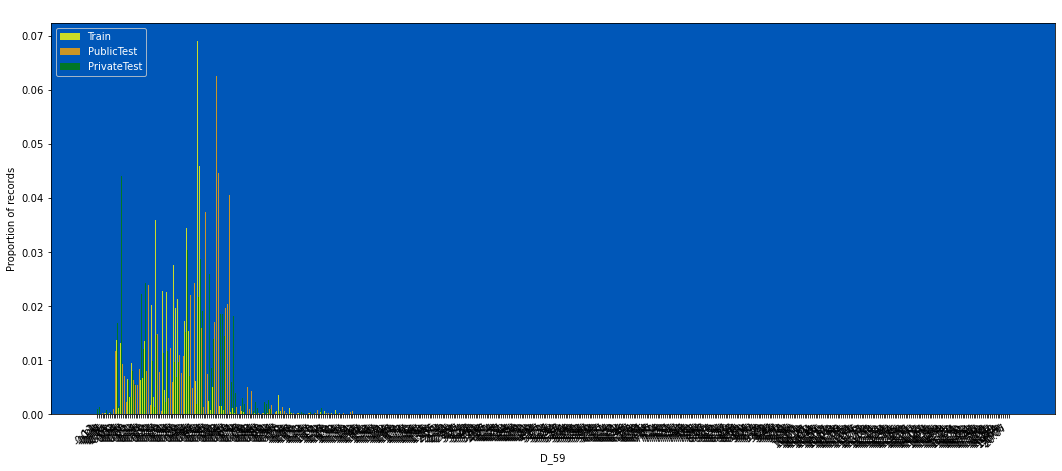

In [105]:
plot_train_test_distribution(df_list, "D_59", nunique_thr=1000, without_drop_tail=True)

**Train Test Drift: Extremely Heavy**

In [106]:
%%time
for df in df_list:
    df = df.drop(columns="D_59", errors="ignore")

CPU times: user 1.14 s, sys: 3.22 s, total: 4.36 s
Wall time: 5.91 s


### D_60

0 null count, 0.000 null proportion
nan of the targets have label = 1


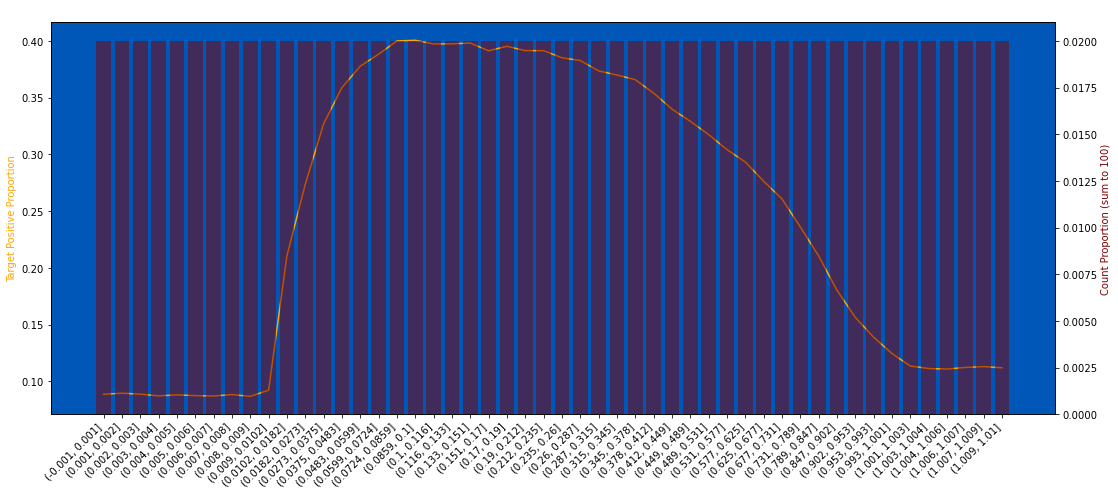

In [107]:
plot_target_check(train, "D_60", q=50, use_raw_bin=True)

In [108]:
%%time
df_list = round_dfs(df_list, col="D_60", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 440 ms, sys: 2.25 s, total: 2.69 s
Wall time: 4.77 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


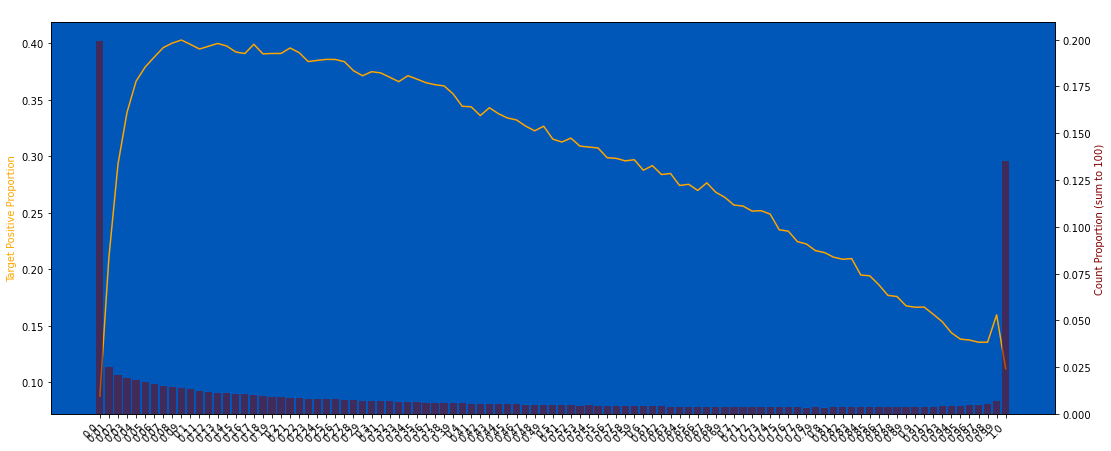

In [109]:
plot_target_check(train, "D_60", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

Bottom 1% and Top 1% are dropped from this chart


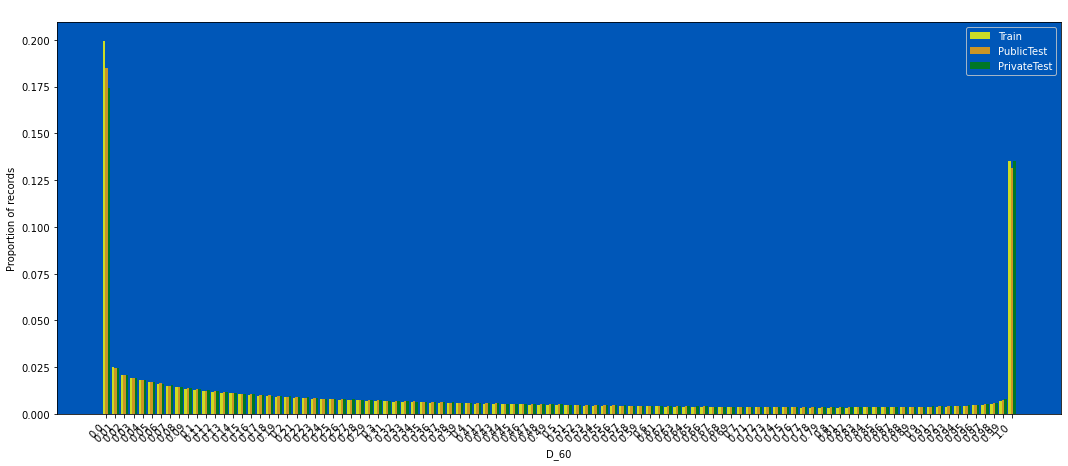

In [110]:
plot_train_test_distribution(df_list, "D_60", nunique_thr=1000)

### D_61

598052 null count, 0.108 null proportion
0.0849 of the targets have label = 1


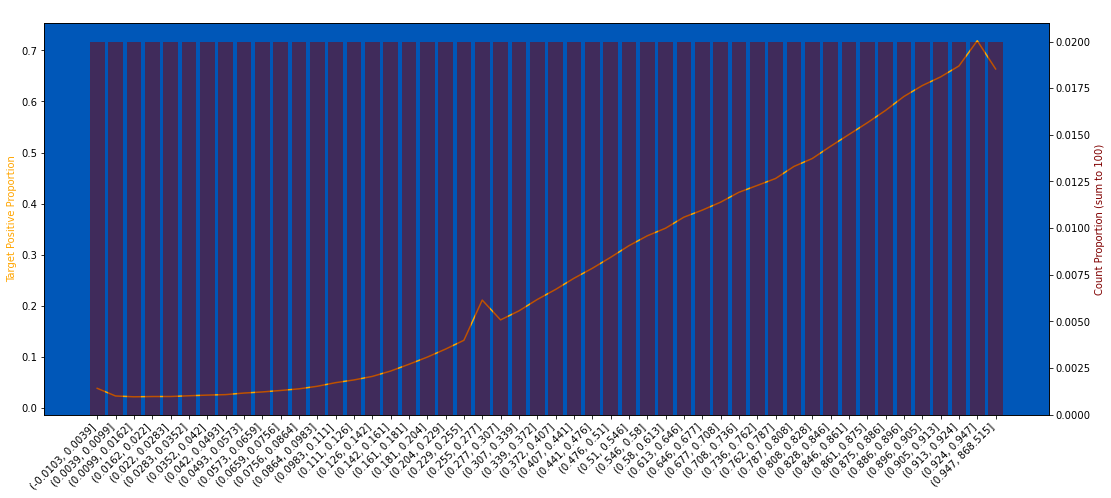

In [111]:
plot_target_check(train, "D_61", q=50, use_raw_bin=True)

In [112]:
%%time
df_list = round_dfs(df_list, col="D_61", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 443 ms, sys: 2.11 s, total: 2.56 s
Wall time: 4.93 s


598052 null count, 0.108 null proportion
0.0849 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


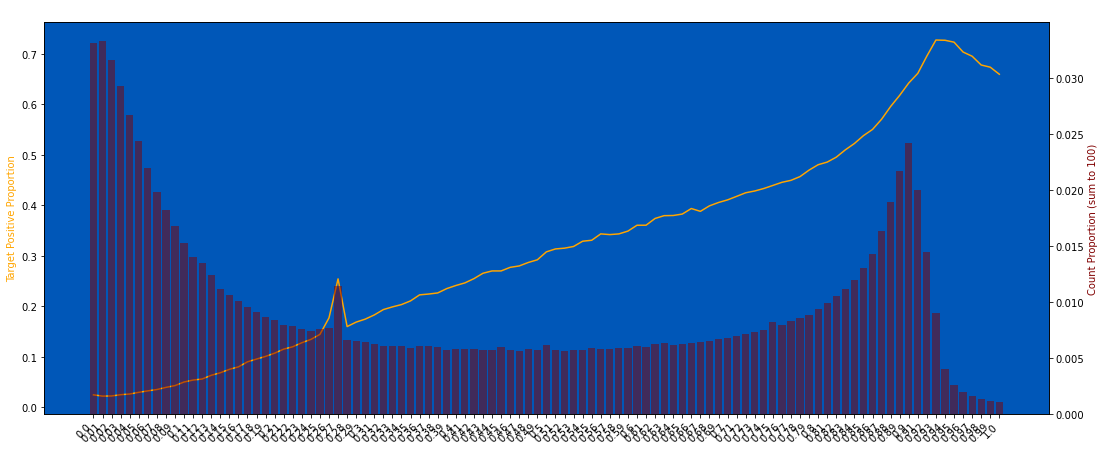

In [113]:
plot_target_check(train, "D_61", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

**ToDo:**
- Identify the spike

Bottom 1% and Top 1% are dropped from this chart


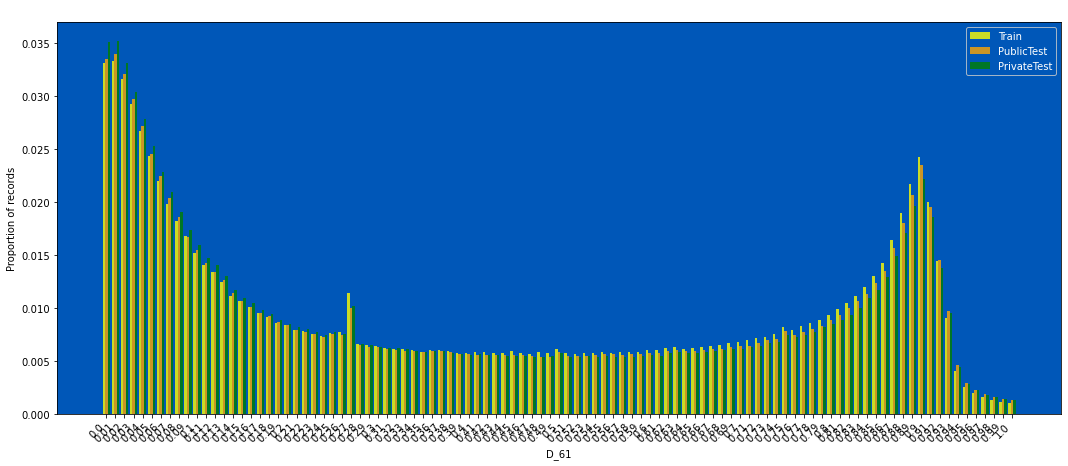

In [114]:
plot_train_test_distribution(df_list, "D_61", nunique_thr=1000)

**Train Test Drift: Moderate**

### D_62

758161 null count, 0.137 null proportion
0.1127 of the targets have label = 1


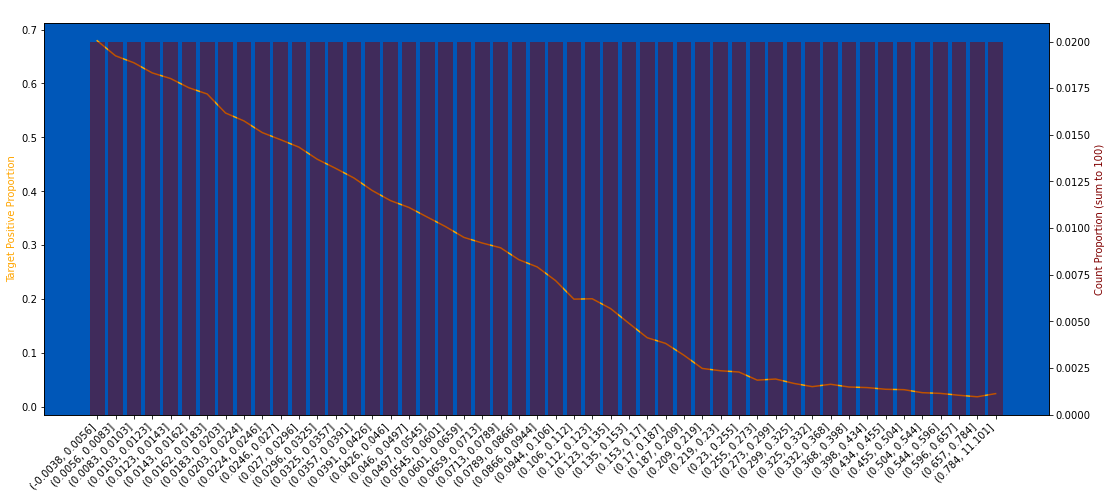

In [115]:
plot_target_check(train, "D_62", q=50, use_raw_bin=True)

In [116]:
%%time
df_list = round_dfs(df_list, col="D_62", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 381 ms, sys: 2.03 s, total: 2.41 s
Wall time: 4.02 s


758161 null count, 0.137 null proportion
0.1127 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


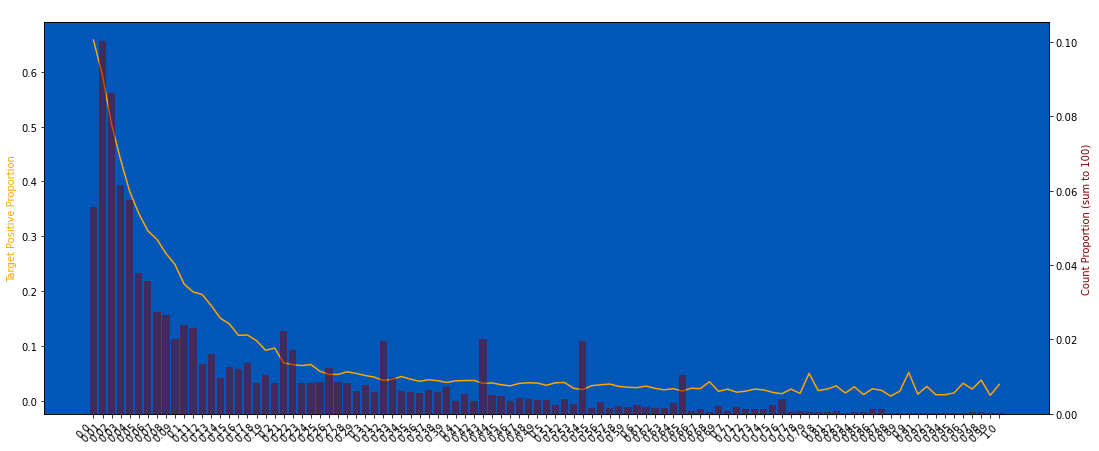

In [117]:
plot_target_check(train, "D_62", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


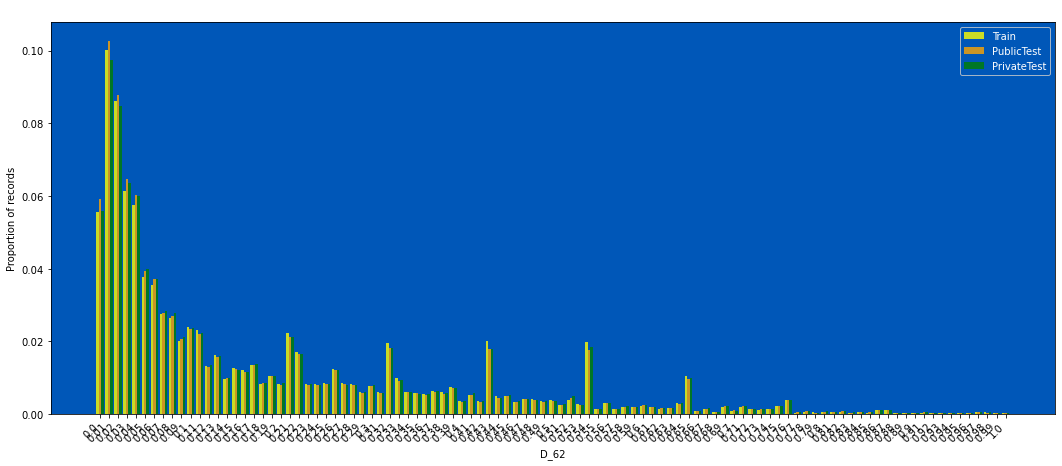

In [118]:
plot_train_test_distribution(df_list, "D_62", nunique_thr=1000)

### D_63

In [119]:
mapping = dict(train.groupby(["D_63"])["target"].mean())
mapping

{'CL': 0.2908939528730126,
 'CO': 0.2628171377901025,
 'CR': 0.16986495479678712,
 'XL': 0.3174443646805456,
 'XM': 0.23740053050397877,
 'XZ': 0.19091755216008688}

In [120]:
for df in df_list:
    df["D_63"] = df["D_63"].map(mapping)

0 null count, 0.000 null proportion
nan of the targets have label = 1


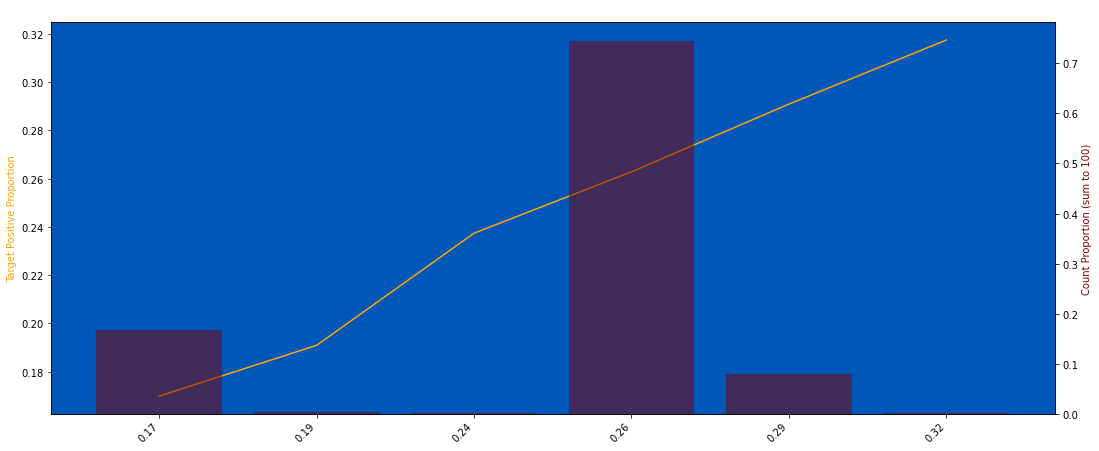

In [121]:
plot_target_check(train, "D_63", q=50, use_raw_bin=True, strfy_x=True, without_drop_tail=True)

In [122]:
for df in df_list:
    df["D_63"] = df["D_63"].astype("category").cat.codes

0 null count, 0.000 null proportion
nan of the targets have label = 1


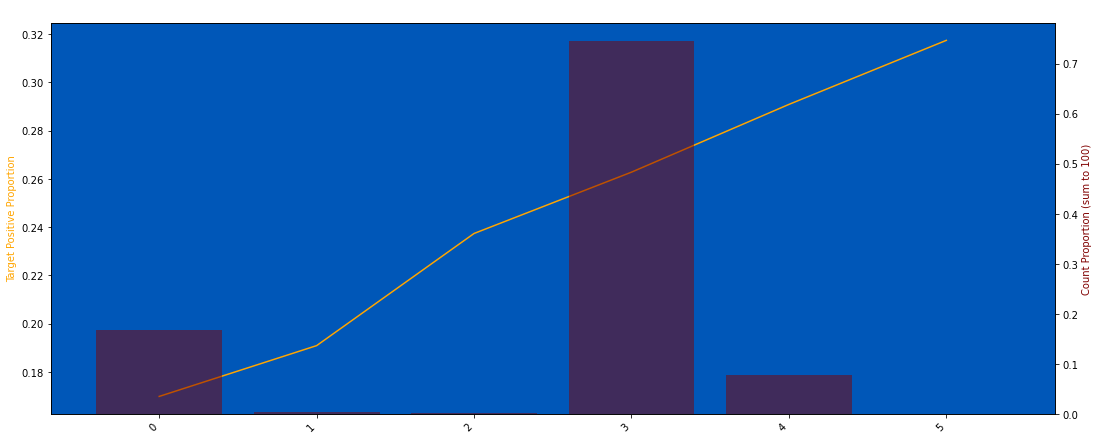

In [123]:
plot_target_check(train, "D_63", q=50, use_raw_bin=True, strfy_x=True, without_drop_tail=True)

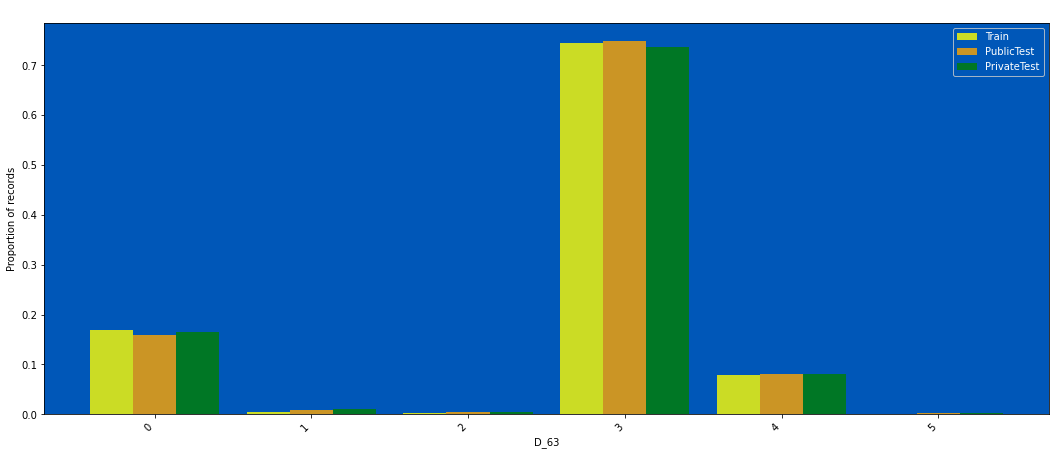

In [124]:
plot_train_test_distribution(df_list, "D_63", nunique_thr=1000, without_drop_tail=True)

### D_64

In [125]:
mapping = dict(train.groupby(["D_64"])["target"].mean())
mapping

{'-1': 0.2207230210993146,
 'O': 0.16925461787615456,
 'R': 0.31524249147732686,
 'U': 0.3432227420955622}

In [126]:
for df in df_list:
    df["D_64"] = df["D_64"].map(mapping)

217442 null count, 0.039 null proportion
0.4086 of the targets have label = 1


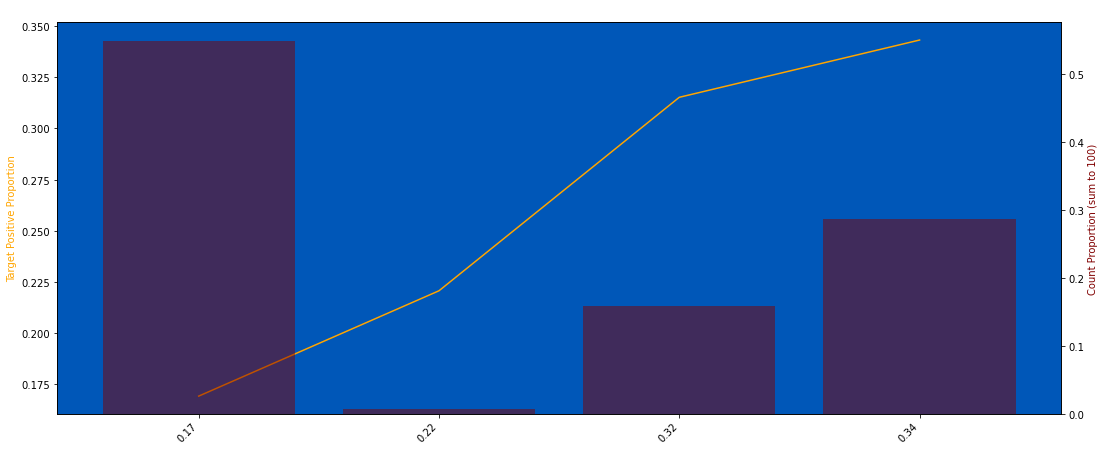

In [127]:
plot_target_check(train, "D_64", q=50, use_raw_bin=True, nunique_thr=50, strfy_x=True, without_drop_tail=True)

In [128]:
for df in df_list:
    df["D_64"] = df["D_64"].astype("category").cat.codes

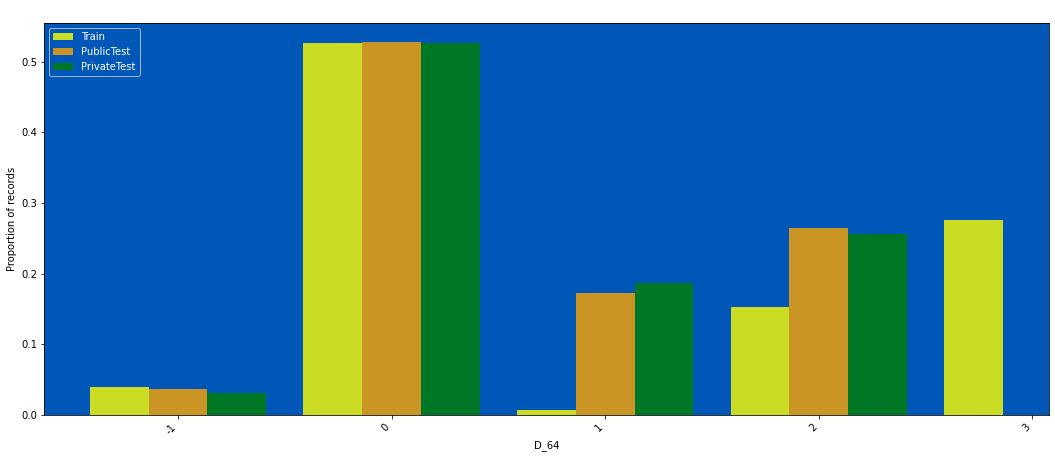

In [129]:
plot_train_test_distribution(df_list, "D_64", nunique_thr=1000, without_drop_tail=True)

**Train Test Drift: Heavy**

In [130]:
for df in df_list:
    df = df.drop(columns="D_64", errors="ignore")

### D_65

0 null count, 0.000 null proportion
nan of the targets have label = 1


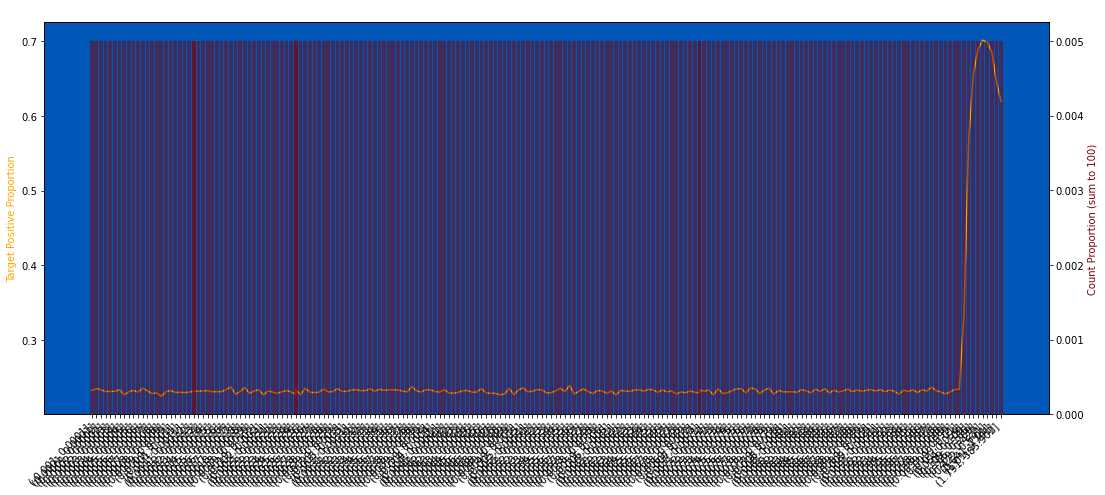

In [131]:
plot_target_check(train, "D_65", q=200, use_raw_bin=True, nunique_thr=1000)

In [132]:
%%time
df_list = round_dfs(df_list, col="D_65", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 415 ms, sys: 1.89 s, total: 2.3 s
Wall time: 3.87 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


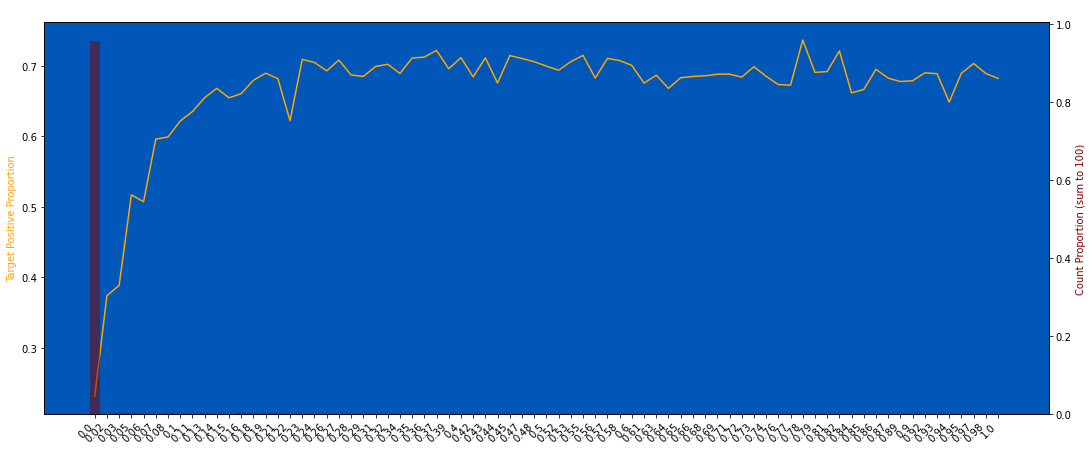

In [133]:
plot_target_check(train, "D_65", q=200, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


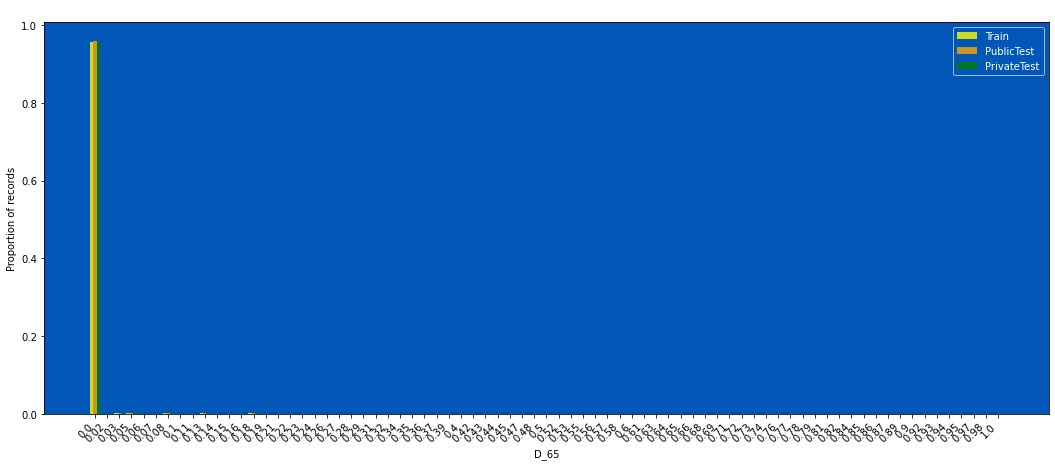

In [134]:
plot_train_test_distribution(df_list, "D_65", nunique_thr=10000)

### D_66

4908097 null count, 0.887 null proportion
0.2572 of the targets have label = 1


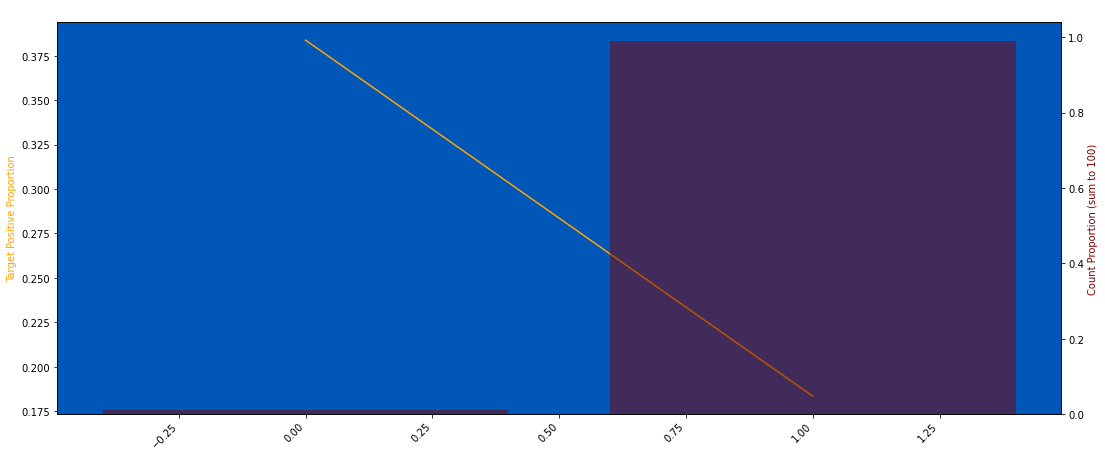

In [135]:
plot_target_check(train, "D_66", q=50, use_raw_bin=True, nunique_thr=50, without_drop_tail=True)

Bottom 1% and Top 1% are dropped from this chart


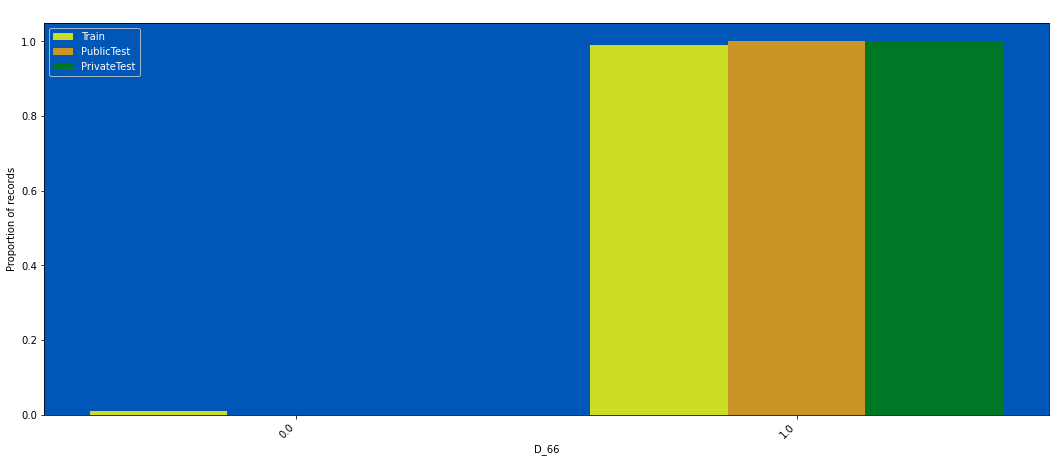

In [136]:
plot_train_test_distribution(df_list, "D_66", nunique_thr=1000)

In [137]:
private_test["D_66"].value_counts()

1.0000    681084
Name: D_66, dtype: int64

In [138]:
%%time
for df in df_list:
    df = df.drop(columns="D_66", errors="ignore")

CPU times: user 1.35 s, sys: 2.87 s, total: 4.22 s
Wall time: 4.82 s


### D_68

In [139]:
mapping = dict(train.groupby(["D_68"])["target"].mean())
mapping

{0.0: 0.17971742543171115,
 1.0: 0.4039903246645934,
 2.0: 0.3929017632012939,
 3.0: 0.3697800768719475,
 4.0: 0.3436032414965202,
 5.0: 0.26221887882726724,
 6.0: 0.17495197586304181}

In [140]:
for df in df_list:
    df["D_68"] = df["D_68"].map(mapping)

216503 null count, 0.039 null proportion
0.4145 of the targets have label = 1


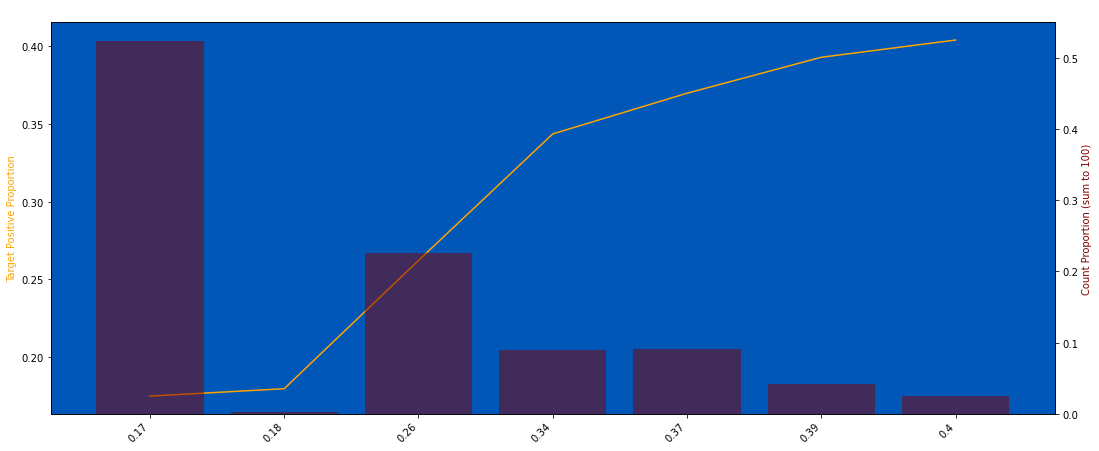

In [141]:
plot_target_check(train, "D_68", q=50, use_raw_bin=True, nunique_thr=50, strfy_x=True, without_drop_tail=True)

In [142]:
for df in df_list:
    df["D_68"] = df["D_68"].astype("category").cat.codes

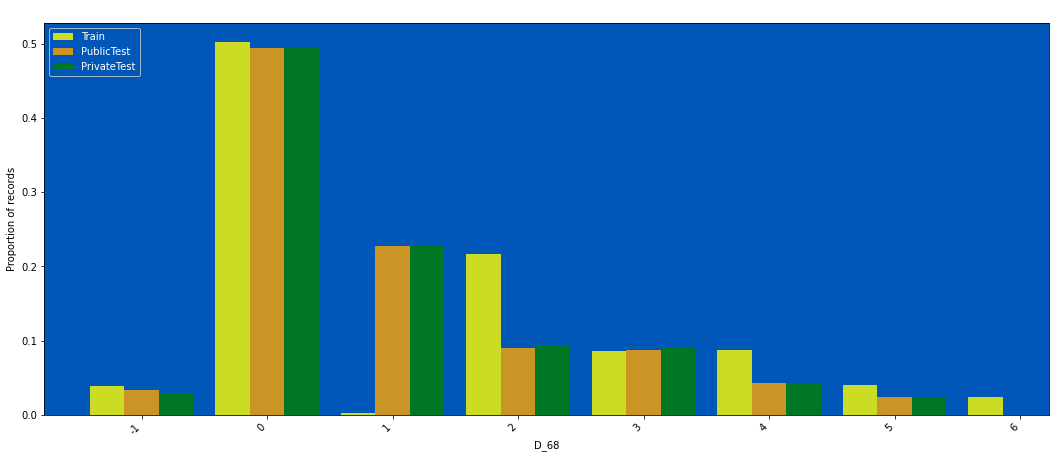

In [143]:
plot_train_test_distribution(df_list, "D_68", nunique_thr=1000, without_drop_tail=True)

In [144]:
for df in df_list:
    df = df.drop(columns="D_68", errors="ignore")

### D_69

194473 null count, 0.035 null proportion
0.4308 of the targets have label = 1


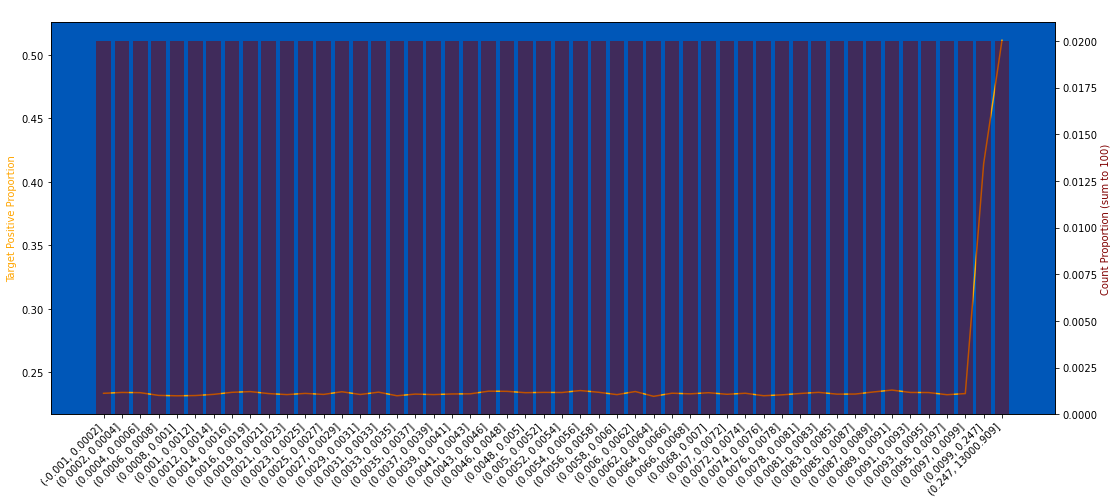

In [145]:
plot_target_check(train, "D_69", q=50, use_raw_bin=True)

In [146]:
%%time
df_list = round_dfs(df_list, col="D_69", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 387 ms, sys: 1.84 s, total: 2.23 s
Wall time: 4.06 s


194473 null count, 0.035 null proportion
0.4308 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


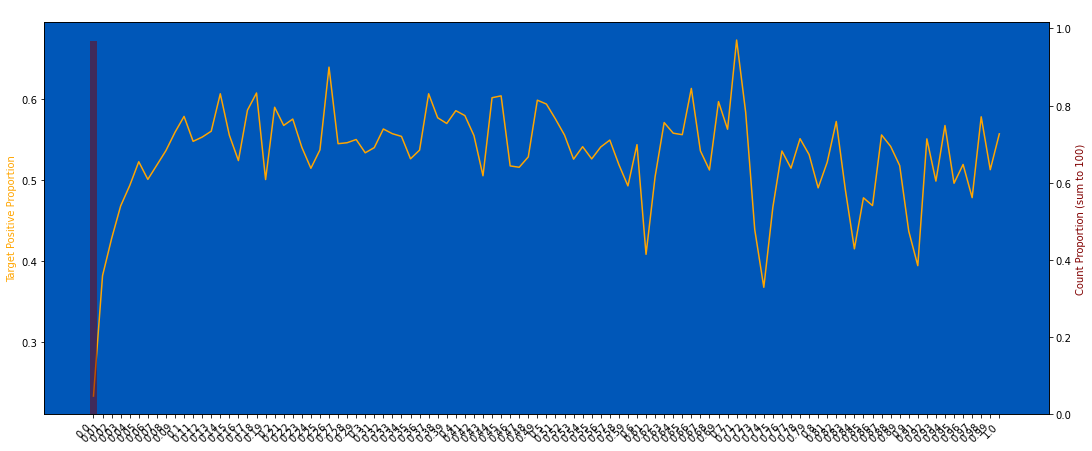

In [147]:
plot_target_check(train, "D_69", q=100, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


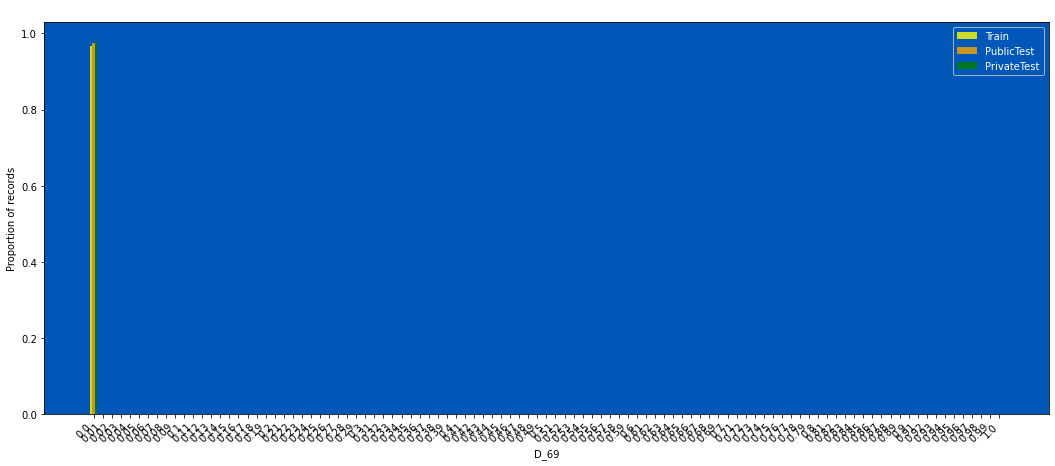

In [148]:
plot_train_test_distribution(df_list, "D_69", nunique_thr=5000)

### D_70

94917 null count, 0.017 null proportion
0.4203 of the targets have label = 1


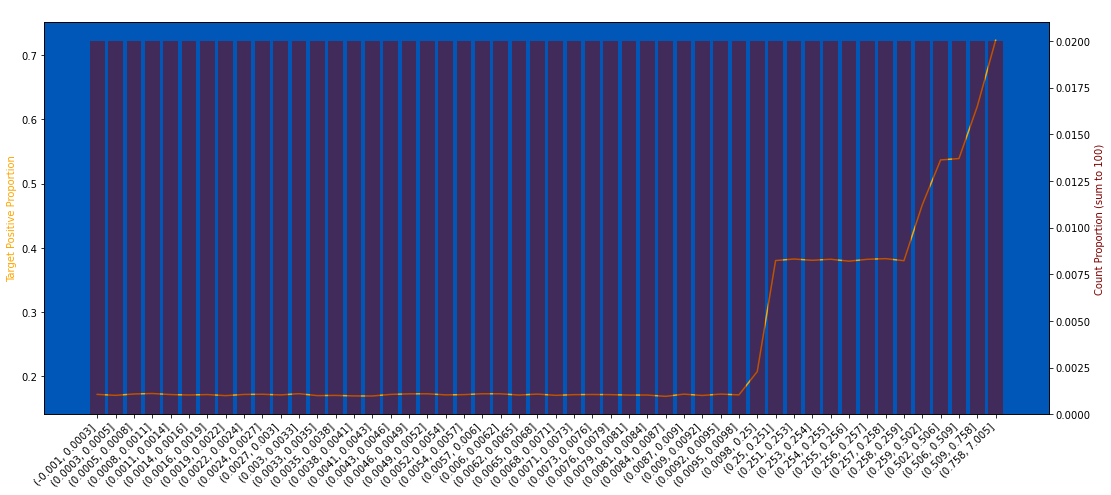

In [149]:
plot_target_check(train, "D_70", q=50, use_raw_bin=True)

In [150]:
%%time
df_list = round_dfs(df_list, col="D_70", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 365 ms, sys: 1.85 s, total: 2.21 s
Wall time: 3.38 s


In [151]:
for df in df_list:
    df["D_70_"] = (df["D_70"] * 4).round(0)

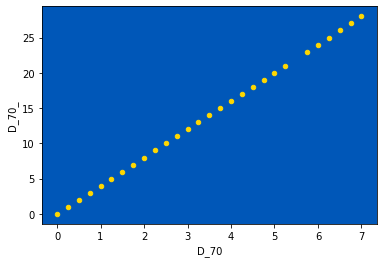

In [152]:
check_binning(train, "D_70", end=3000)

In [153]:
for df in df_list:
    df["D_70"] = (df["D_70"] * 4).round(0)

94917 null count, 0.017 null proportion
0.4203 of the targets have label = 1


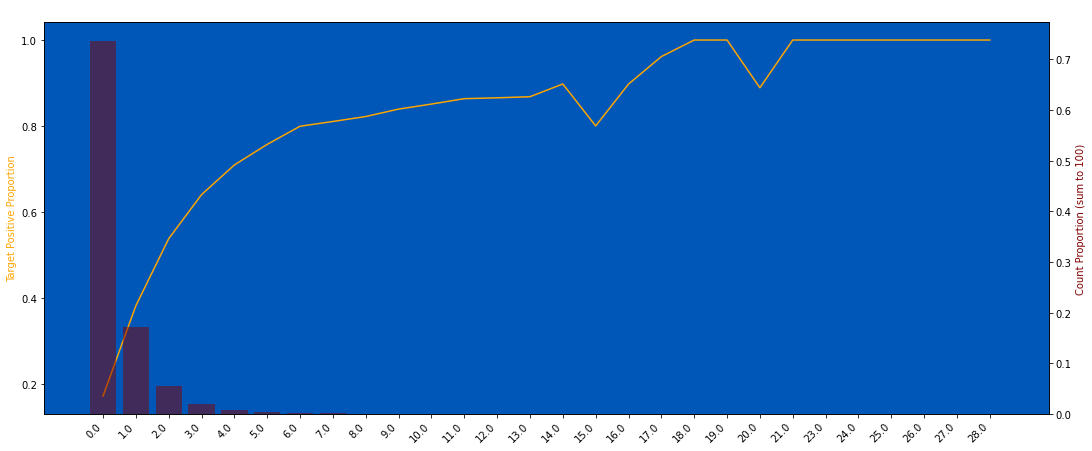

In [154]:
plot_target_check(train, "D_70", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

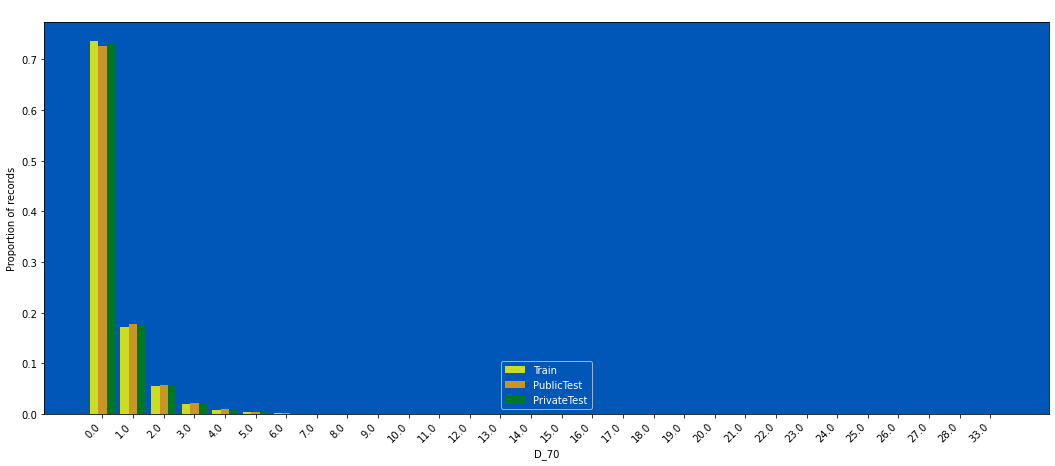

In [155]:
plot_train_test_distribution(df_list, "D_70", nunique_thr=5000, without_drop_tail=True)

### D_71

0 null count, 0.000 null proportion
nan of the targets have label = 1


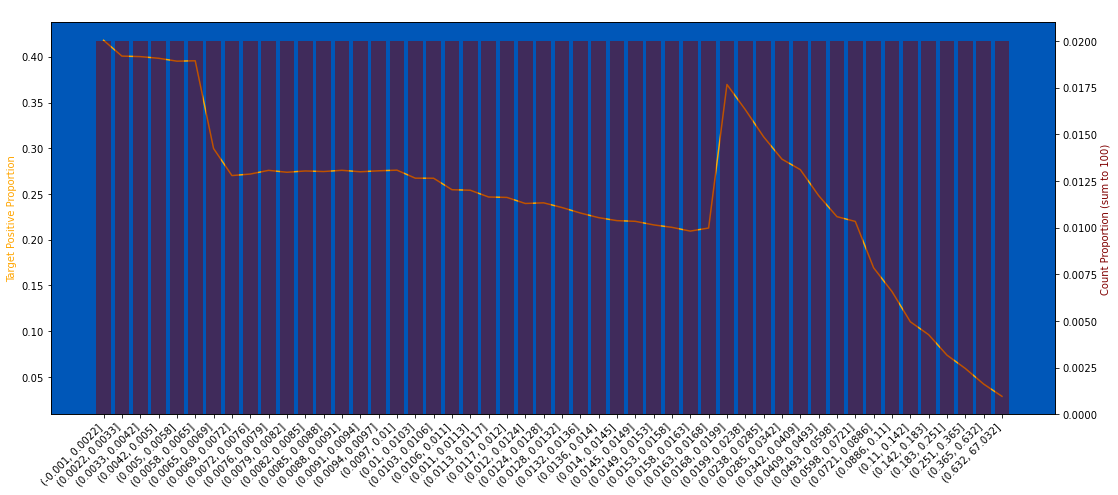

In [156]:
plot_target_check(train, "D_71", q=50, use_raw_bin=True)

In [157]:
%%time
df_list = round_dfs(df_list, col="D_71", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 356 ms, sys: 1.74 s, total: 2.09 s
Wall time: 3.01 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


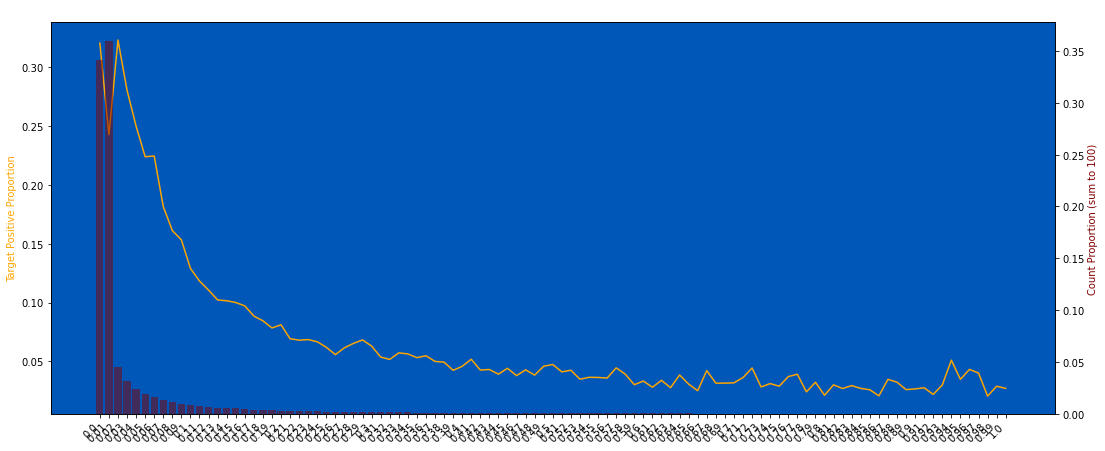

In [158]:
plot_target_check(train, "D_71", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


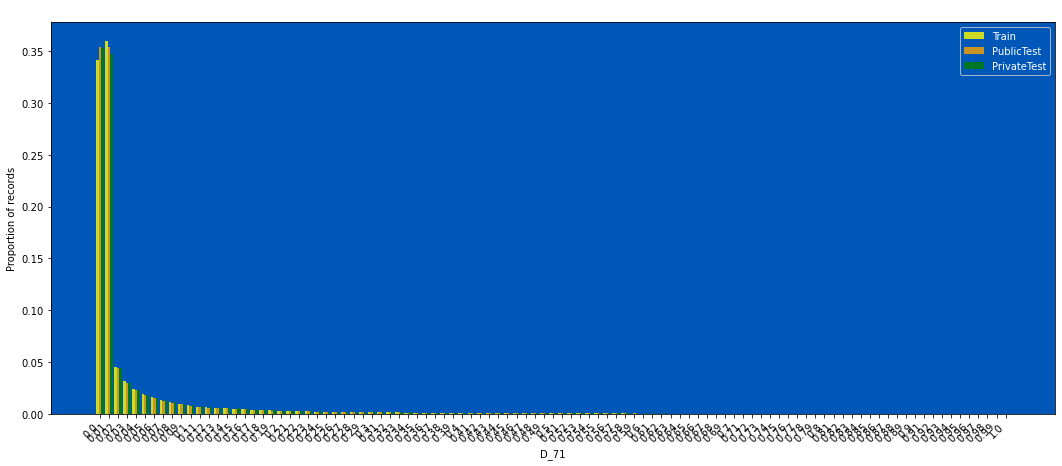

In [159]:
plot_train_test_distribution(df_list, "D_71", nunique_thr=5000)

### D_72

23708 null count, 0.004 null proportion
0.3495 of the targets have label = 1


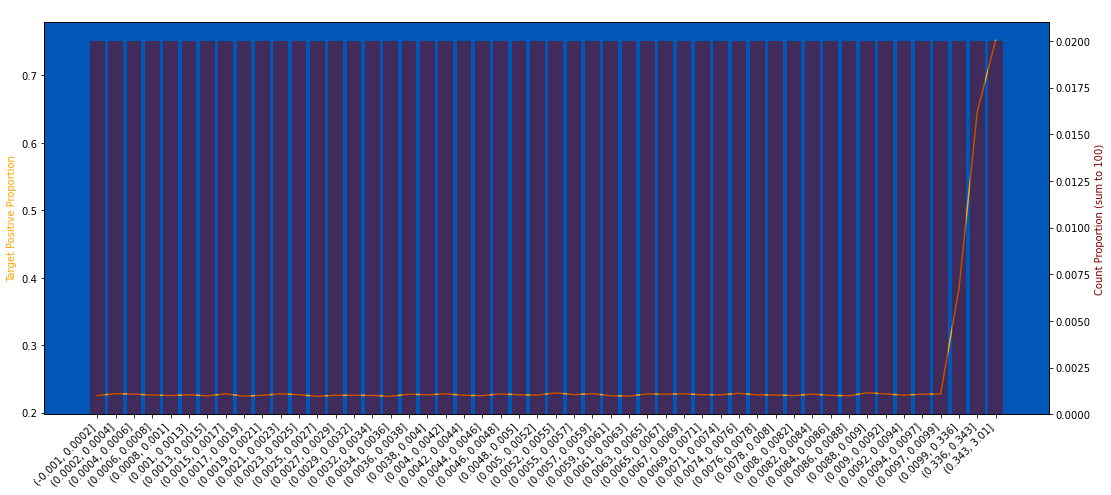

In [160]:
plot_target_check(train, "D_72", q=50, use_raw_bin=True)

In [161]:
%%time
df_list = round_dfs(df_list, col="D_72", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 364 ms, sys: 1.63 s, total: 1.99 s
Wall time: 2.96 s


In [162]:
for df in df_list:
    df["D_72_"] = (df["D_72"] * 3).round(0)

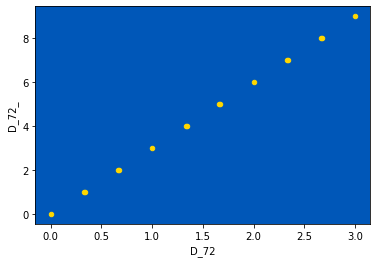

In [163]:
check_binning(train, "D_72", end=80000)

In [164]:
for df in df_list:
    df["D_72"] = (df["D_72"] * 3).round(0)

23708 null count, 0.004 null proportion
0.3495 of the targets have label = 1


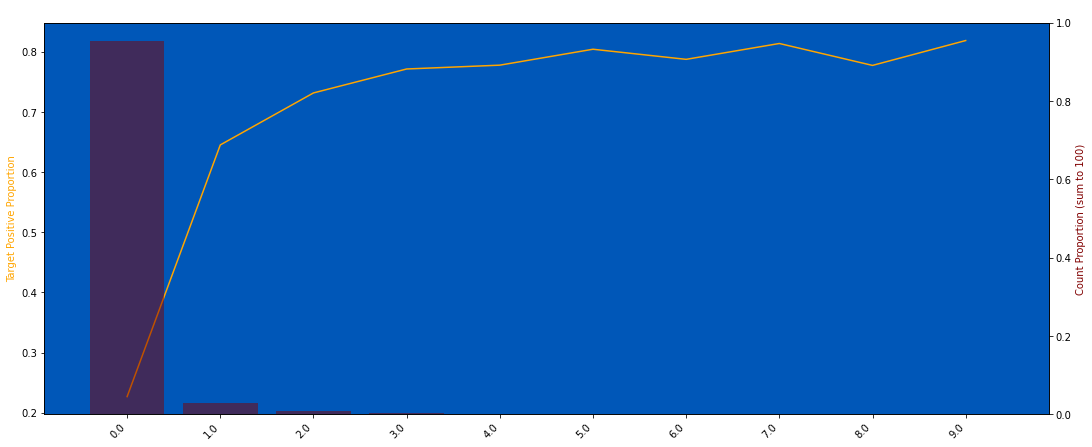

In [165]:
plot_target_check(train, "D_72", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

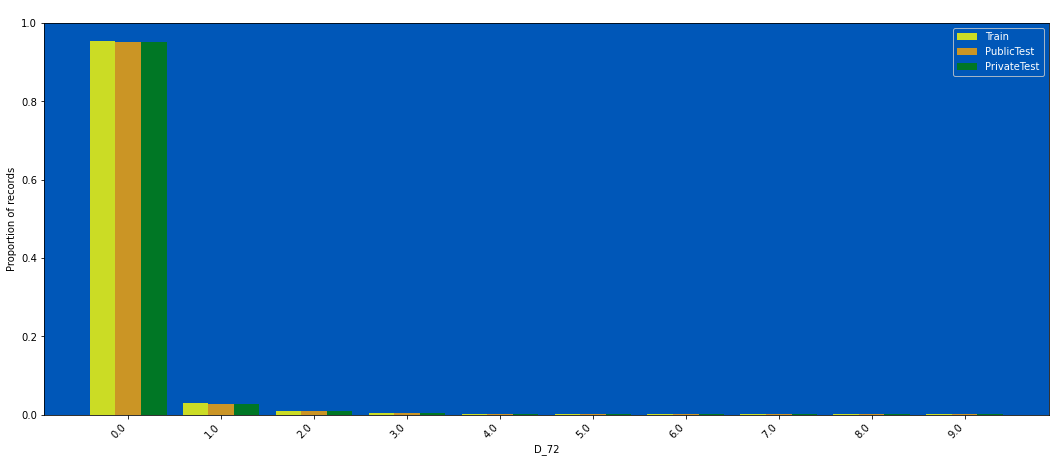

In [166]:
plot_train_test_distribution(df_list, "D_72", nunique_thr=5000, without_drop_tail=True)

### D_73

5475595 null count, 0.990 null proportion
0.2478 of the targets have label = 1


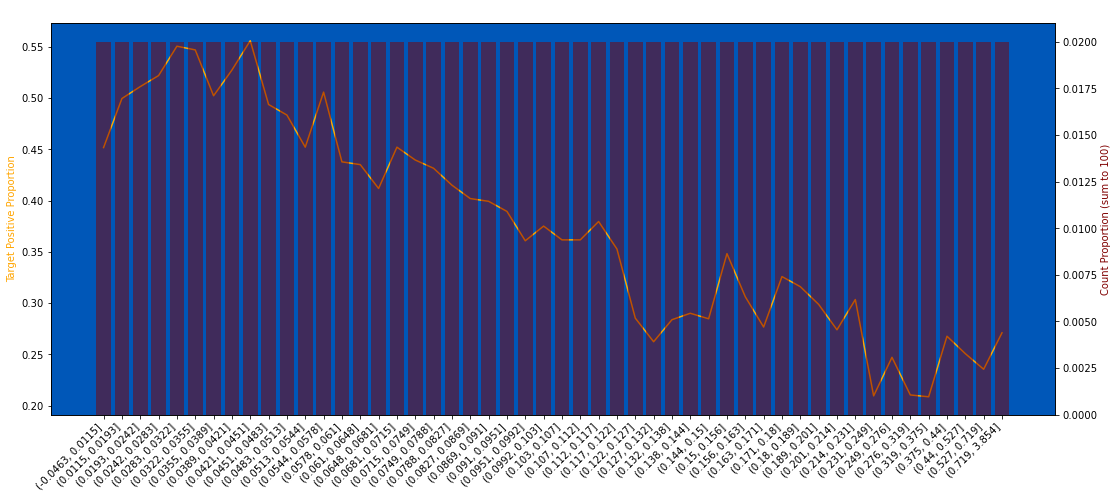

In [167]:
plot_target_check(train, "D_73", q=50, use_raw_bin=True)

In [168]:
%%time
df_list = round_dfs(df_list, col="D_73", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 374 ms, sys: 1.84 s, total: 2.21 s
Wall time: 3.53 s


5475595 null count, 0.990 null proportion
0.2478 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


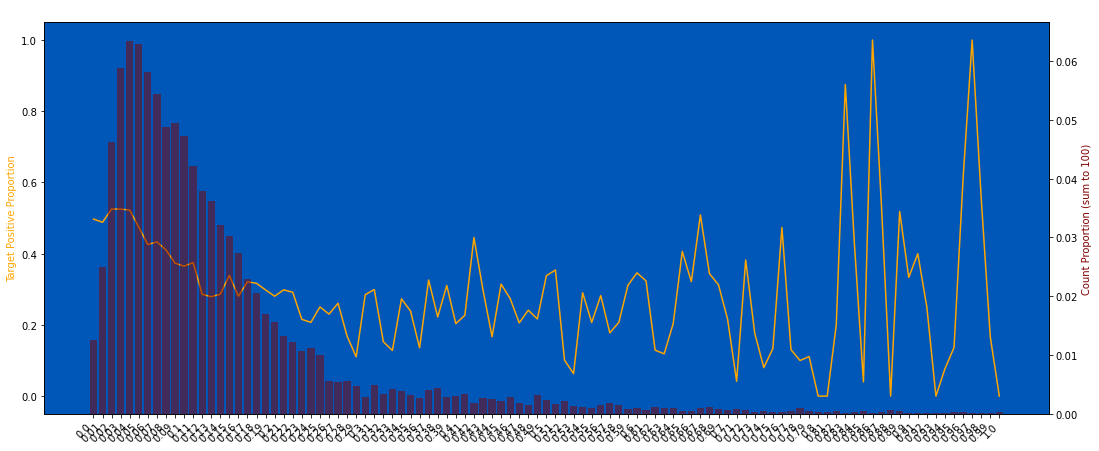

In [169]:
plot_target_check(train, "D_73", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


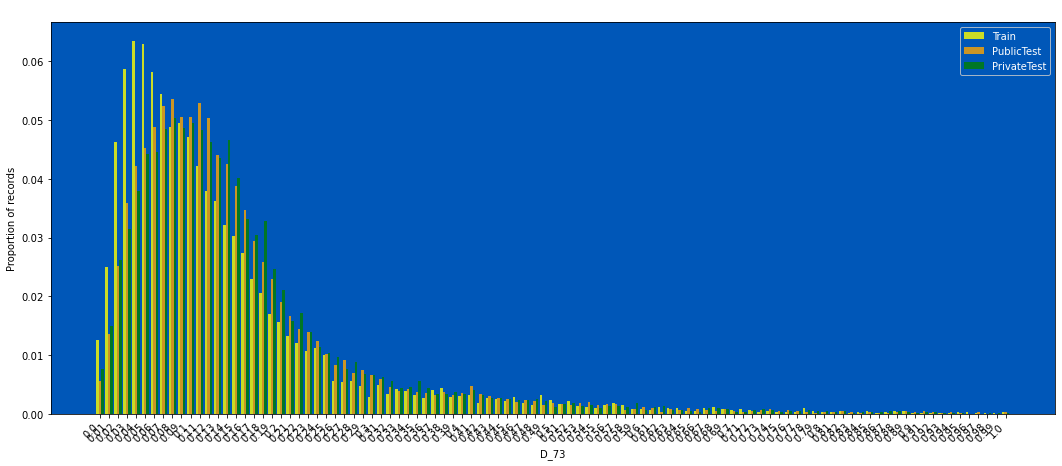

In [170]:
plot_train_test_distribution(df_list, "D_73", nunique_thr=5000)

**Train Test Drift: Extremely Heavy**

In [171]:
%%time
for df in df_list:
    df = df.drop(columns="D_73", errors="ignore")

CPU times: user 883 ms, sys: 2.89 s, total: 3.77 s
Wall time: 4.79 s


### D_74

21773 null count, 0.004 null proportion
0.1709 of the targets have label = 1


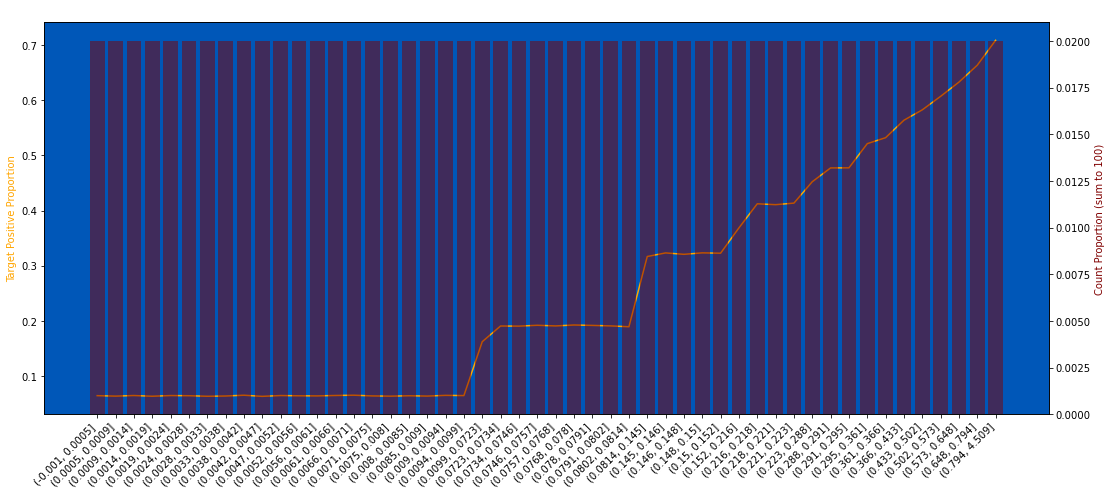

In [172]:
plot_target_check(train, "D_74", q=50, use_raw_bin=True)

In [173]:
%%time
df_list = round_dfs(df_list, col="D_74", decimals=3, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 427 ms, sys: 1.96 s, total: 2.39 s
Wall time: 4.17 s


In [174]:
%%time
for df in df_list:
    df["D_74_"] = (df["D_74"] / 0.071)
df_list = round_dfs(df_list, col="D_74_", decimals=0, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 147 ms, sys: 810 ms, total: 958 ms
Wall time: 1.56 s


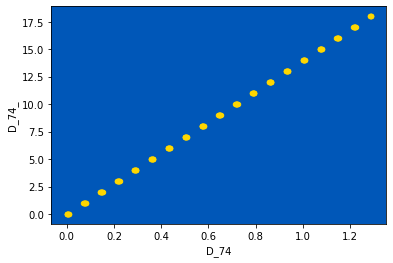

In [181]:
check_binning(train, "D_74", start=0, end=200)

In [182]:
%%time
for df in df_list:
    df["D_74"] = (df["D_74"] / 0.071)
df_list = round_dfs(df_list, col="D_74", decimals=0, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 276 ms, sys: 1.04 s, total: 1.31 s
Wall time: 1.9 s


21773 null count, 0.004 null proportion
0.1709 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


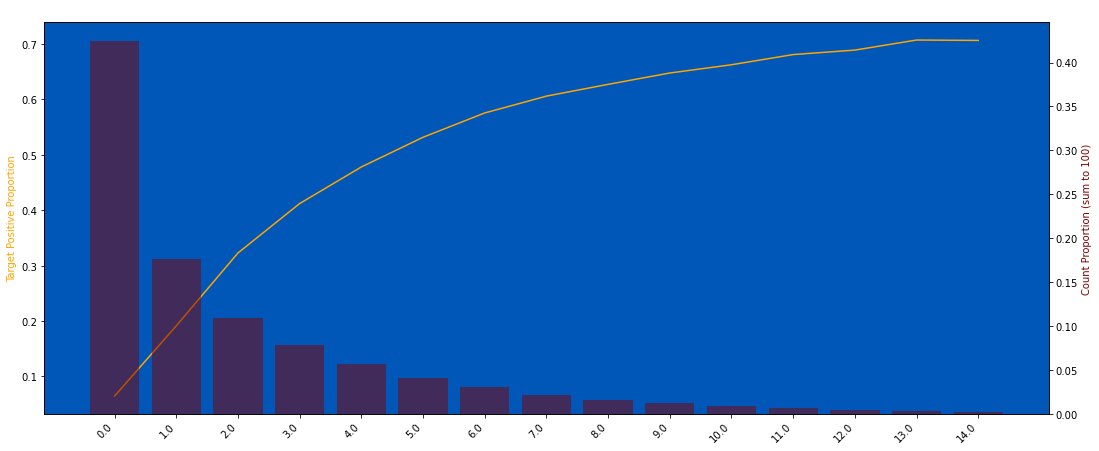

In [183]:
plot_target_check(train, "D_74", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


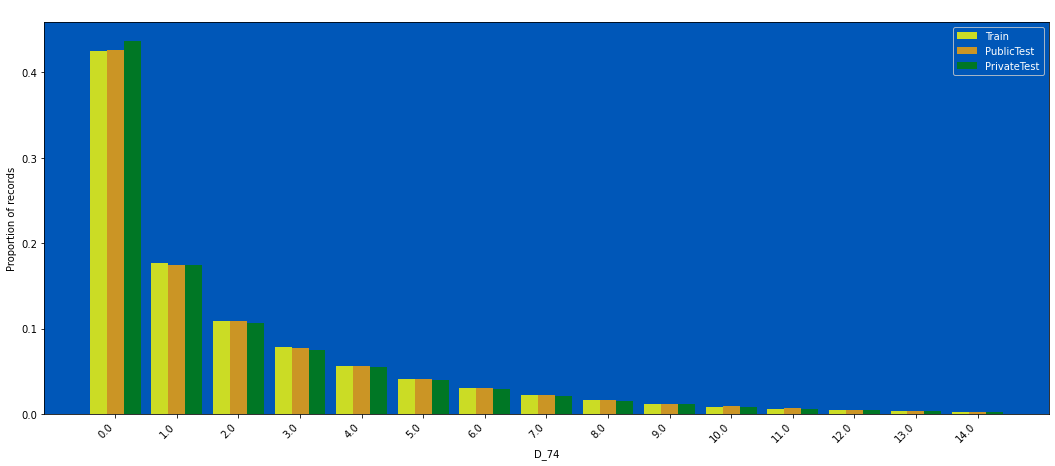

In [184]:
plot_train_test_distribution(df_list, "D_74", nunique_thr=5000)

### D_75

0 null count, 0.000 null proportion
nan of the targets have label = 1


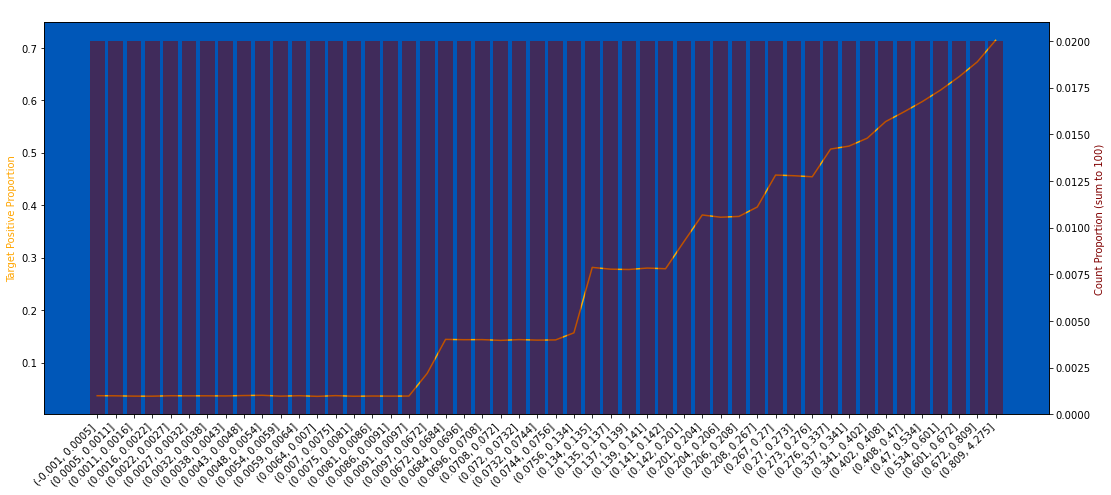

In [185]:
plot_target_check(train, "D_75", q=50, use_raw_bin=True)

In [186]:
%%time
df_list = round_dfs(df_list, col="D_75", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 406 ms, sys: 1.99 s, total: 2.39 s
Wall time: 3.92 s


In [187]:
for df in df_list:
    df["D_75_"] = (df["D_75"] * (100 / 6.66)).round(0)

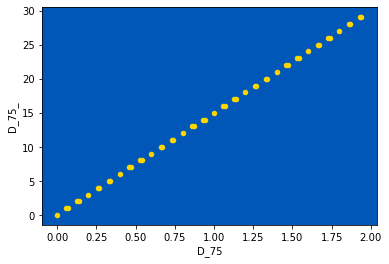

In [188]:
check_binning(train, "D_75", start=0, end=50)

In [189]:
for df in df_list:
    df["D_75"] = (df["D_75"] * (100 / 6.66)).round(0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


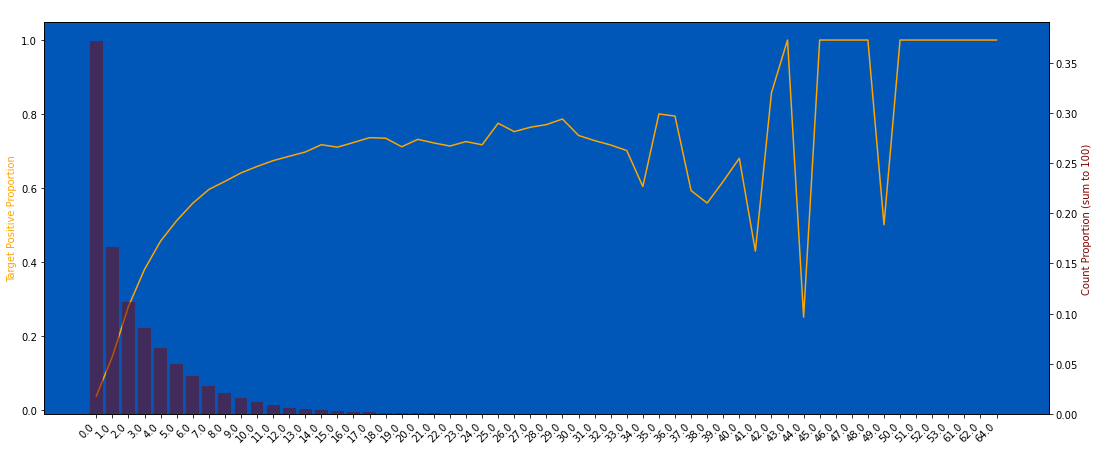

In [190]:
plot_target_check(train, "D_75", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

Bottom 1% and Top 1% are dropped from this chart


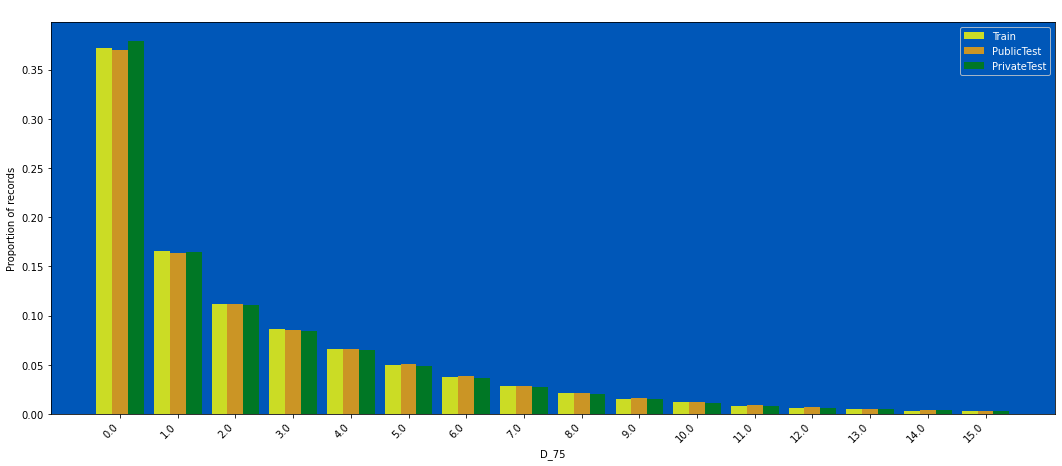

In [191]:
plot_train_test_distribution(df_list, "D_75", nunique_thr=5000)

### D_76

4908954 null count, 0.887 null proportion
0.2677 of the targets have label = 1


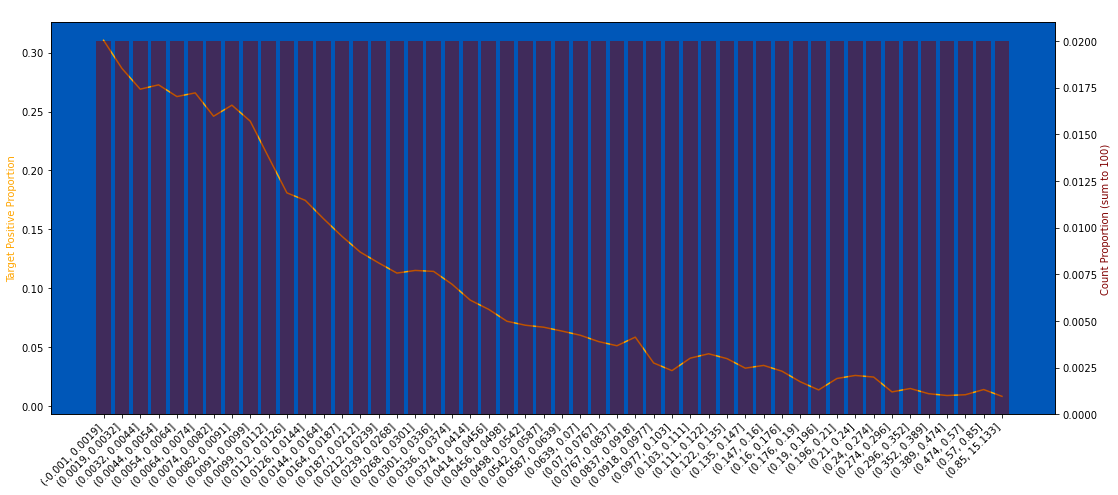

In [192]:
plot_target_check(train, "D_76", q=50, use_raw_bin=True)

In [193]:
%%time
df_list = round_dfs(df_list, col="D_76", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 378 ms, sys: 1.89 s, total: 2.27 s
Wall time: 3.55 s


4908954 null count, 0.887 null proportion
0.2677 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


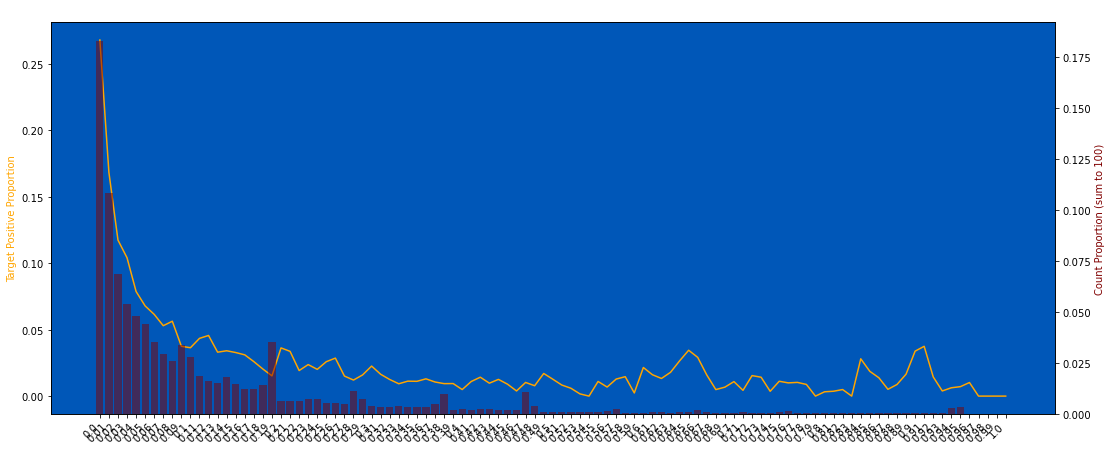

In [194]:
plot_target_check(train, "D_76", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


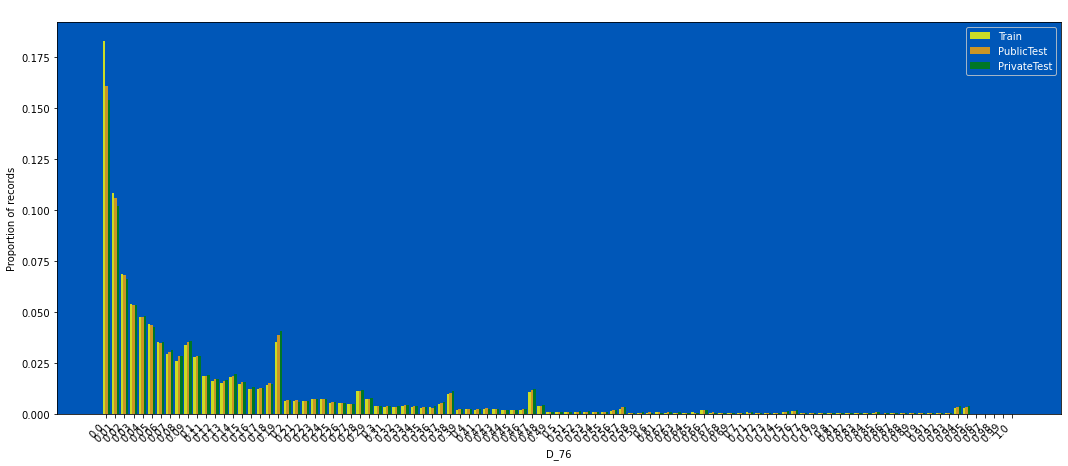

In [195]:
plot_train_test_distribution(df_list, "D_76", nunique_thr=5000)

**Train Test Drift: Moderate**

### D_77

2513912 null count, 0.454 null proportion
0.3395 of the targets have label = 1


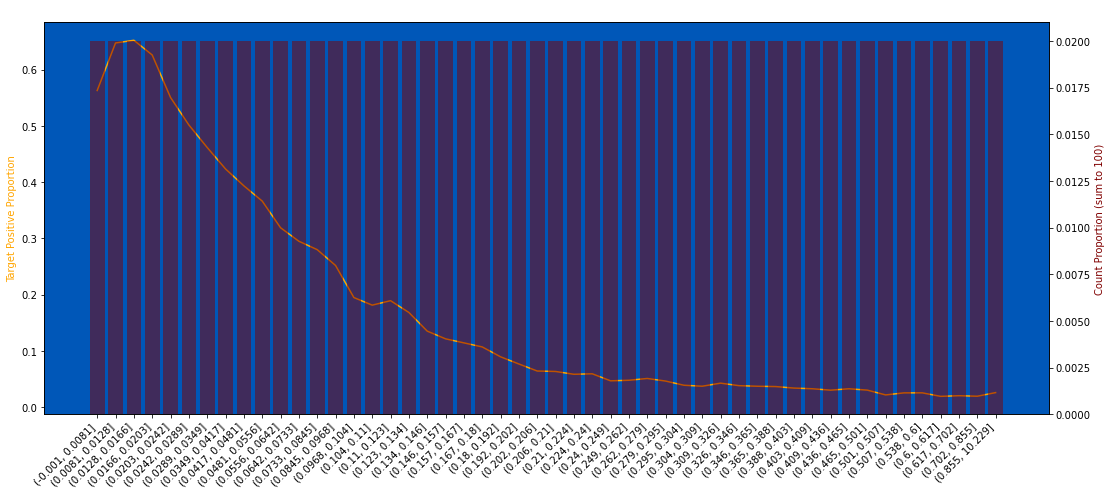

In [196]:
plot_target_check(train, "D_77", q=50, use_raw_bin=True)

In [197]:
%%time
df_list = round_dfs(df_list, col="D_77", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 376 ms, sys: 2.02 s, total: 2.4 s
Wall time: 3.71 s


2513912 null count, 0.454 null proportion
0.3395 of the targets have label = 1


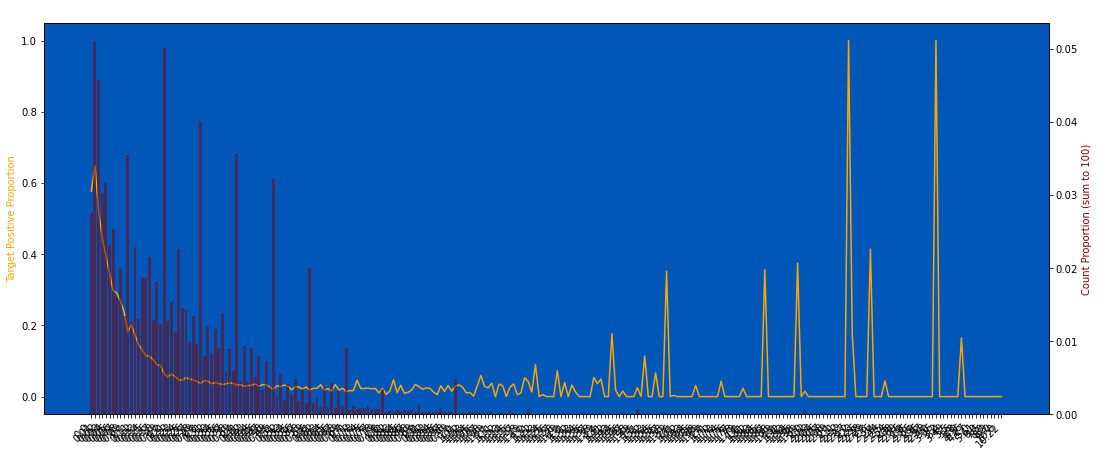

In [198]:
plot_target_check(train, "D_77", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True, without_drop_tail=True)

Bottom 1% and Top 1% are dropped from this chart


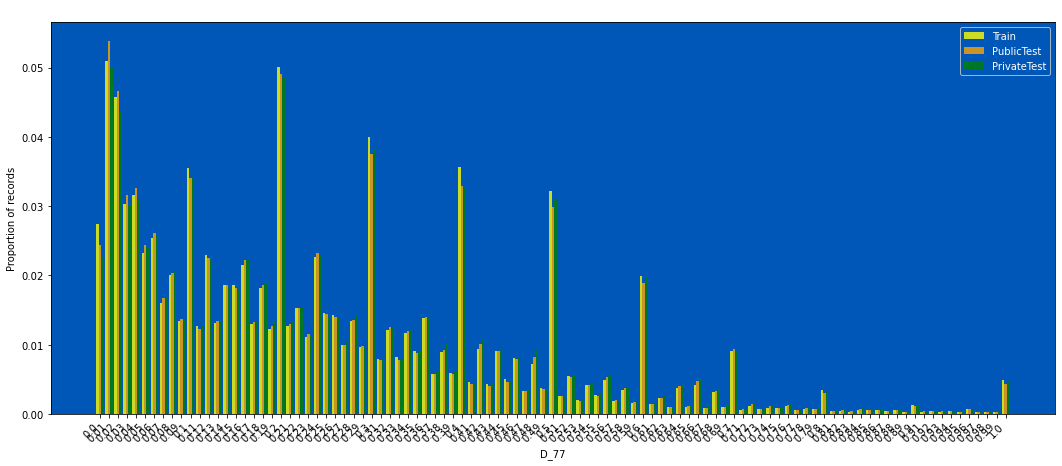

In [199]:
plot_train_test_distribution(df_list, "D_77", nunique_thr=5000)

**Train Test Drift: Moderate**

### D_78

274319 null count, 0.050 null proportion
0.2406 of the targets have label = 1


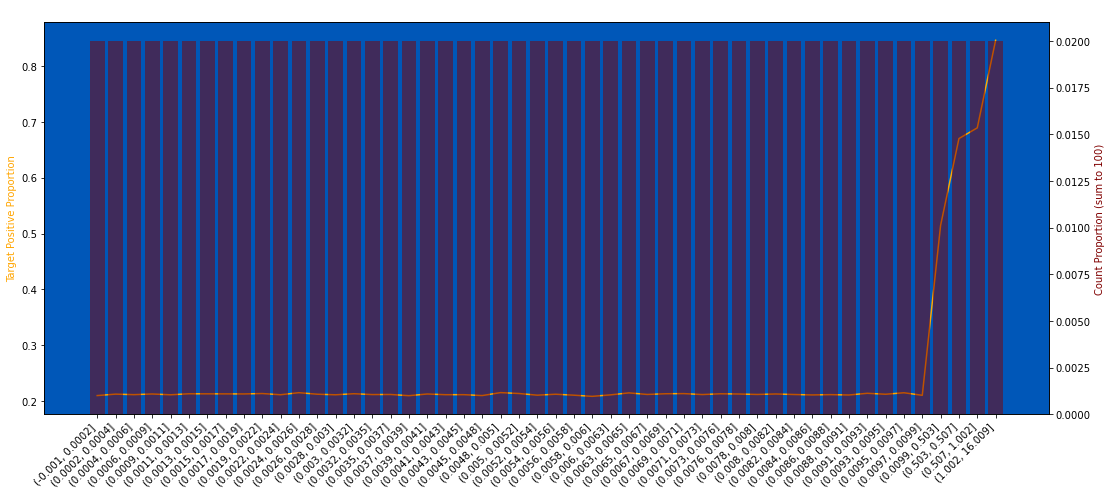

In [200]:
plot_target_check(train, "D_78", q=50, use_raw_bin=True)

In [201]:
%%time
df_list = round_dfs(df_list, col="D_78", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 371 ms, sys: 1.82 s, total: 2.19 s
Wall time: 3.27 s


274319 null count, 0.050 null proportion
0.2406 of the targets have label = 1


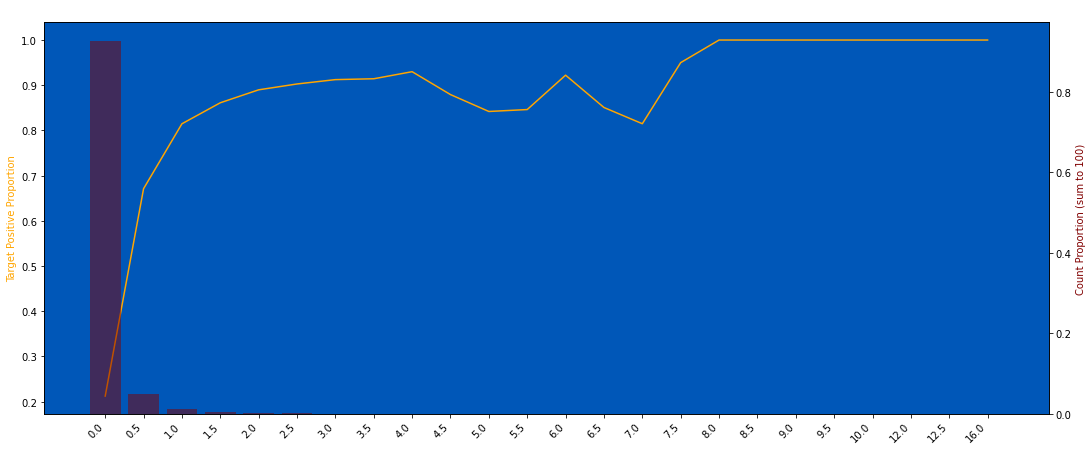

In [202]:
plot_target_check(train, "D_78", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True, without_drop_tail=True)

In [203]:
for df in df_list:
    df["D_78_"] = (df["D_78"] * 2).round(0)

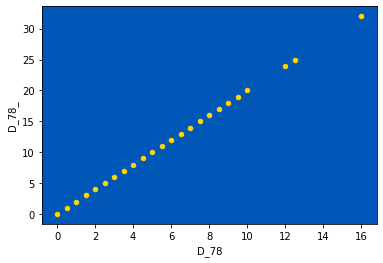

In [204]:
check_binning(train, "D_78", end=2000)

In [205]:
for df in df_list:
    df["D_78"] = (df["D_78"] * 2).round(0)

274319 null count, 0.050 null proportion
0.2406 of the targets have label = 1


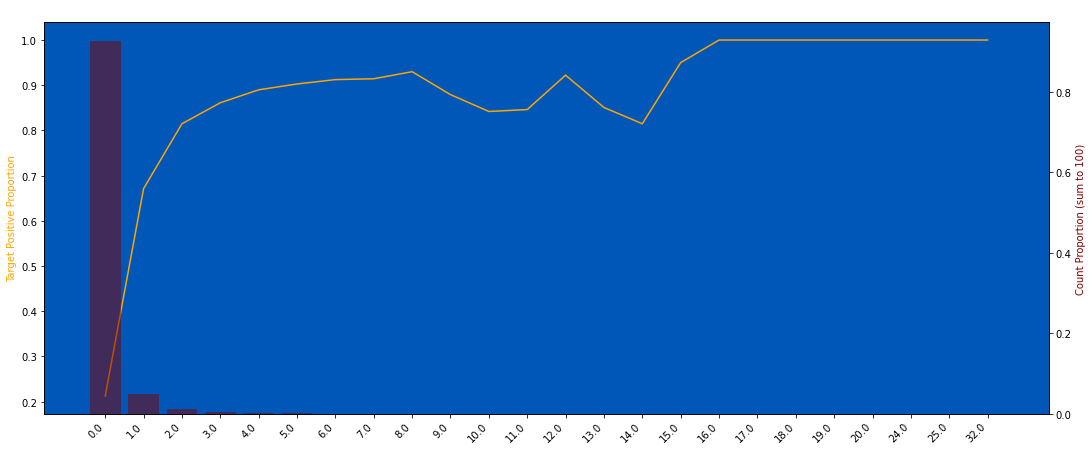

In [206]:
plot_target_check(train, "D_78", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True, without_drop_tail=True)

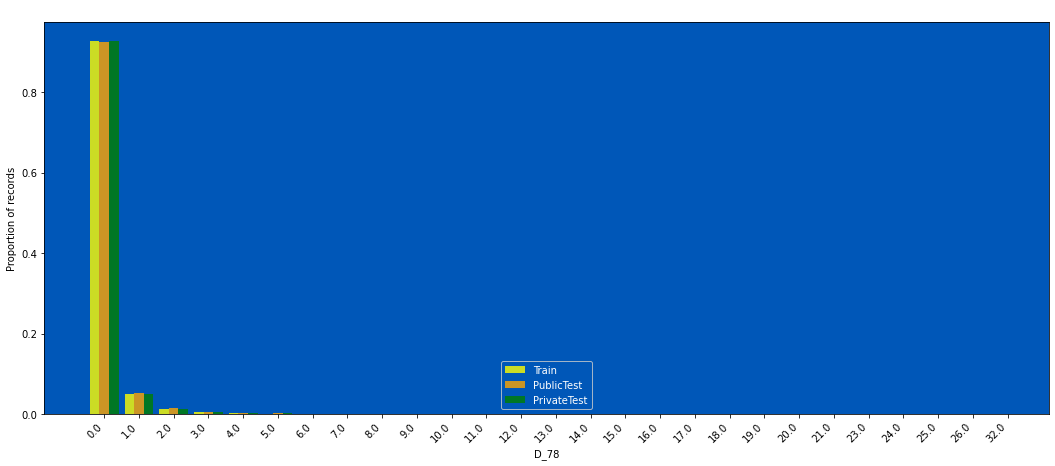

In [207]:
plot_train_test_distribution(df_list, "D_78", nunique_thr=500, without_drop_tail=True)

### D_79

75939 null count, 0.014 null proportion
0.3761 of the targets have label = 1


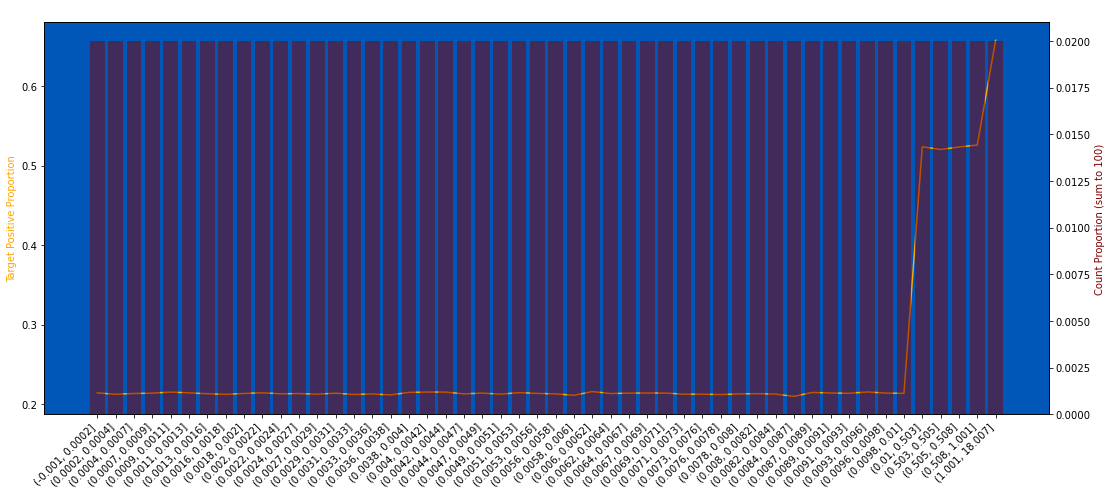

In [208]:
plot_target_check(train, "D_79", q=50, use_raw_bin=True)

In [209]:
%%time
df_list = round_dfs(df_list, col="D_79", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 412 ms, sys: 1.84 s, total: 2.25 s
Wall time: 3.26 s


75939 null count, 0.014 null proportion
0.3761 of the targets have label = 1


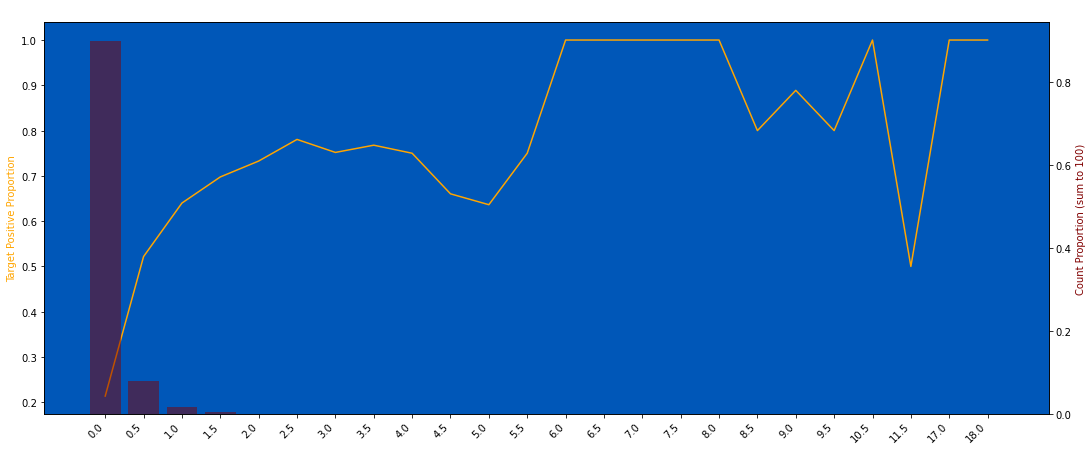

In [210]:
plot_target_check(train, "D_79", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True, without_drop_tail=True)

In [211]:
for df in df_list:
    df["D_79_"] = (df["D_79"] * 2).round(0)

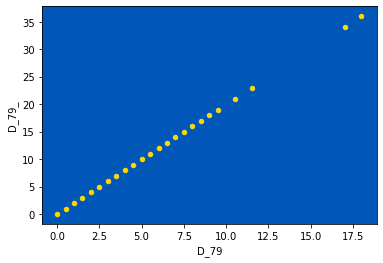

In [212]:
check_binning(train, "D_79", end=3000)

In [213]:
for df in df_list:
    df["D_79"] = (df["D_79"] * 2).round(0)

75939 null count, 0.014 null proportion
0.3761 of the targets have label = 1


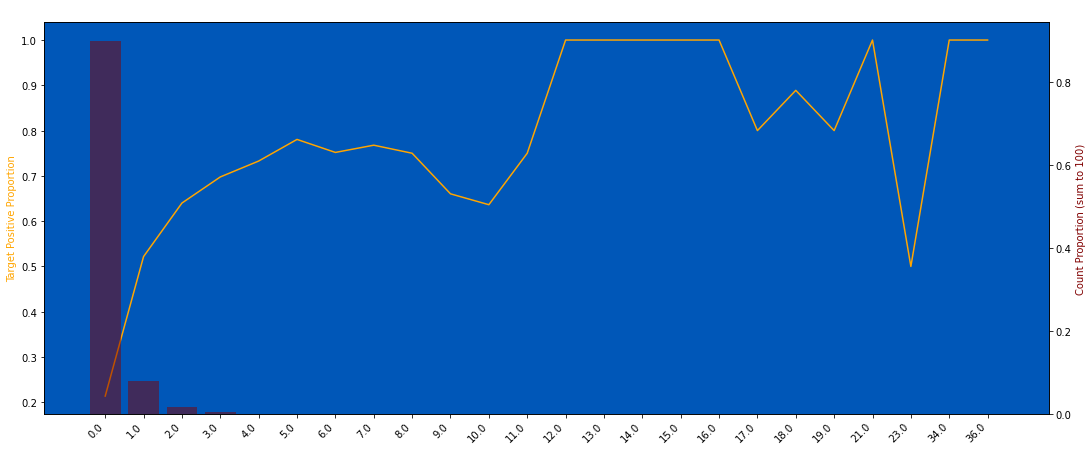

In [214]:
plot_target_check(train, "D_79", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True, without_drop_tail=True)

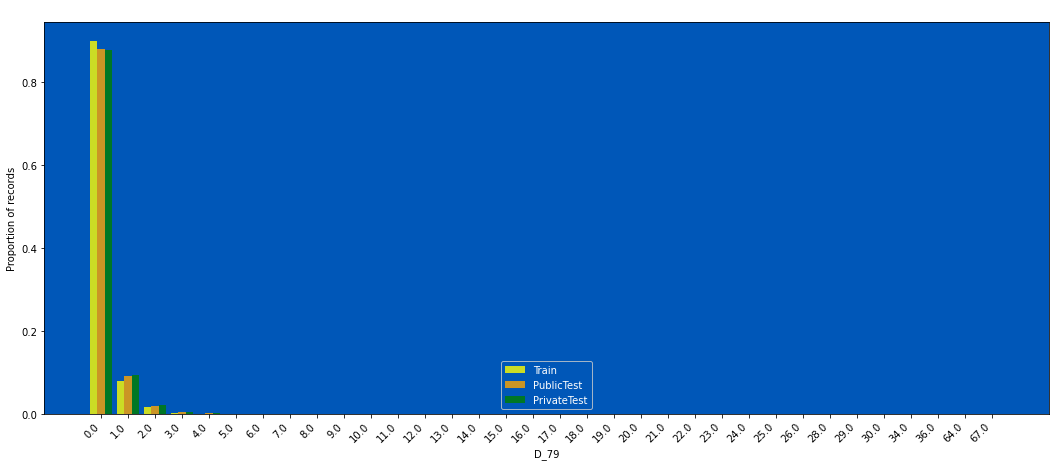

In [215]:
plot_train_test_distribution(df_list, "D_79", nunique_thr=500, without_drop_tail=True)

### D_80

21773 null count, 0.004 null proportion
0.1709 of the targets have label = 1


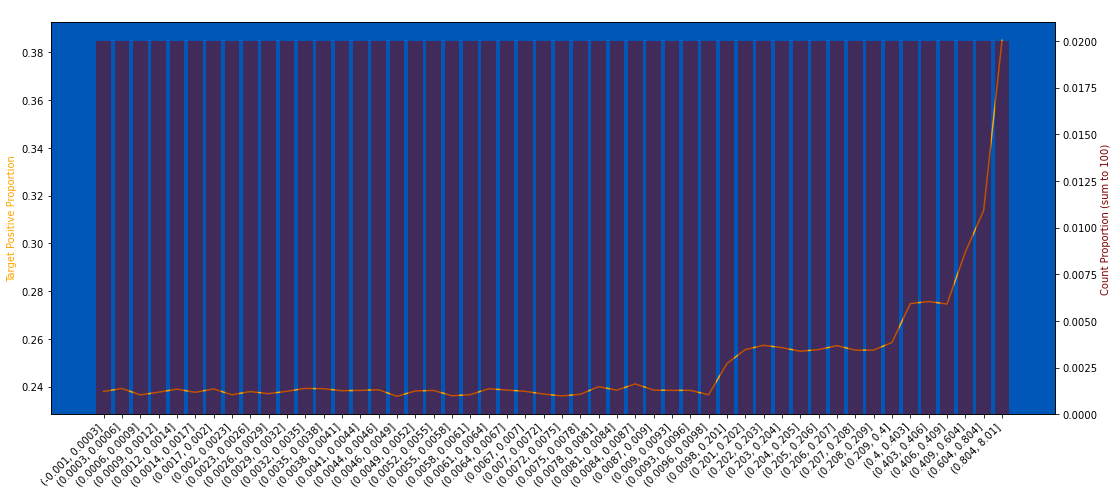

In [216]:
plot_target_check(train, "D_80", q=50, use_raw_bin=True)

In [217]:
%%time
df_list = round_dfs(df_list, col="D_80", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 408 ms, sys: 1.79 s, total: 2.19 s
Wall time: 3.15 s


21773 null count, 0.004 null proportion
0.1709 of the targets have label = 1


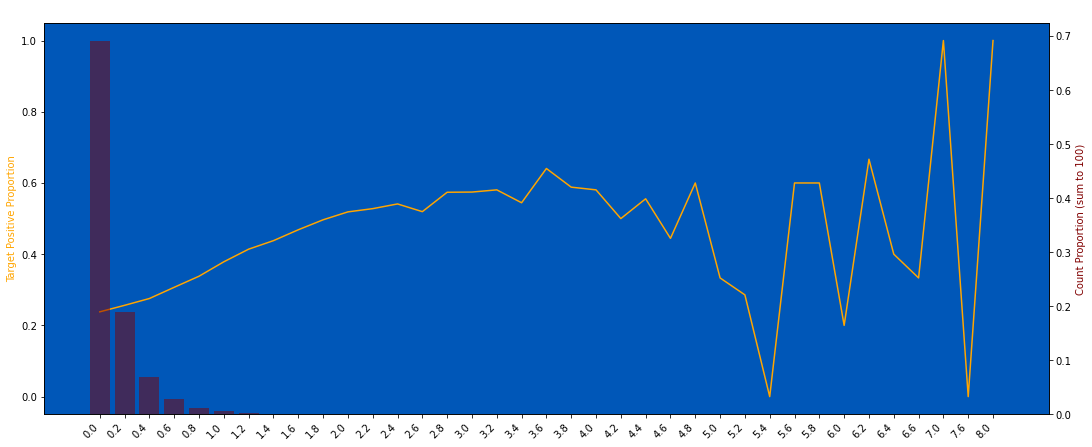

In [218]:
plot_target_check(train, "D_80", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True, without_drop_tail=True)

In [219]:
for df in df_list:
    df["D_80_"] = (df["D_80"] * 5).round(0)

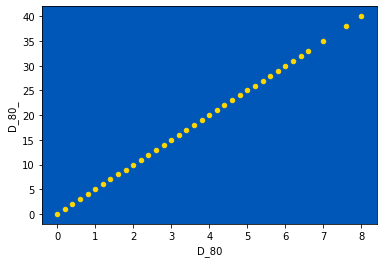

In [220]:
check_binning(train, "D_80", end=3000)

In [221]:
for df in df_list:
    df["D_80"] = (df["D_80"] * 5).round(0)

21773 null count, 0.004 null proportion
0.1709 of the targets have label = 1


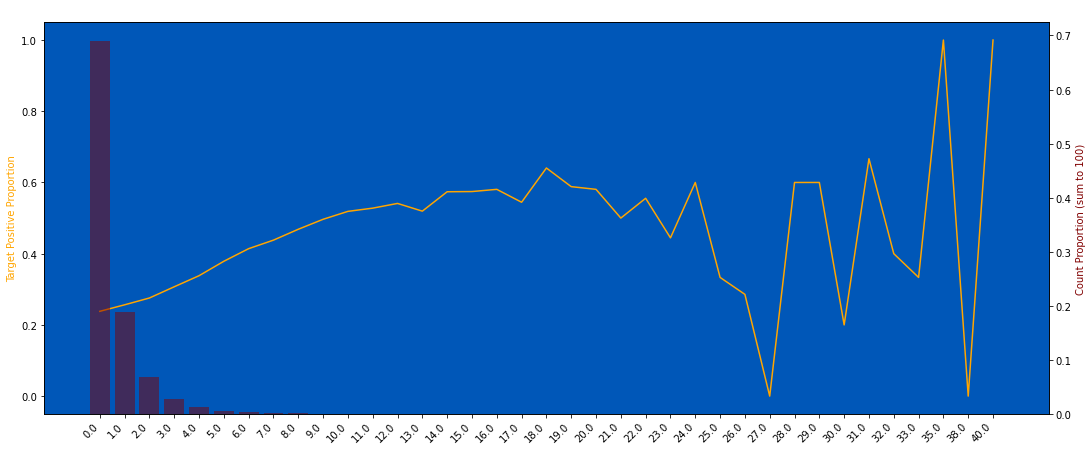

In [222]:
plot_target_check(train, "D_80", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True, without_drop_tail=True)

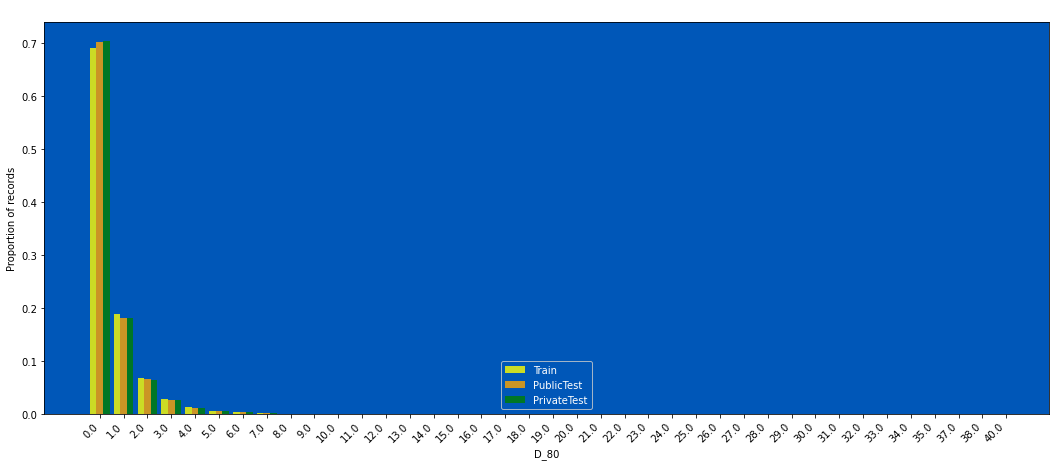

In [223]:
plot_train_test_distribution(df_list, "D_80", nunique_thr=500, without_drop_tail=True)

### D_81

25687 null count, 0.005 null proportion
0.3798 of the targets have label = 1


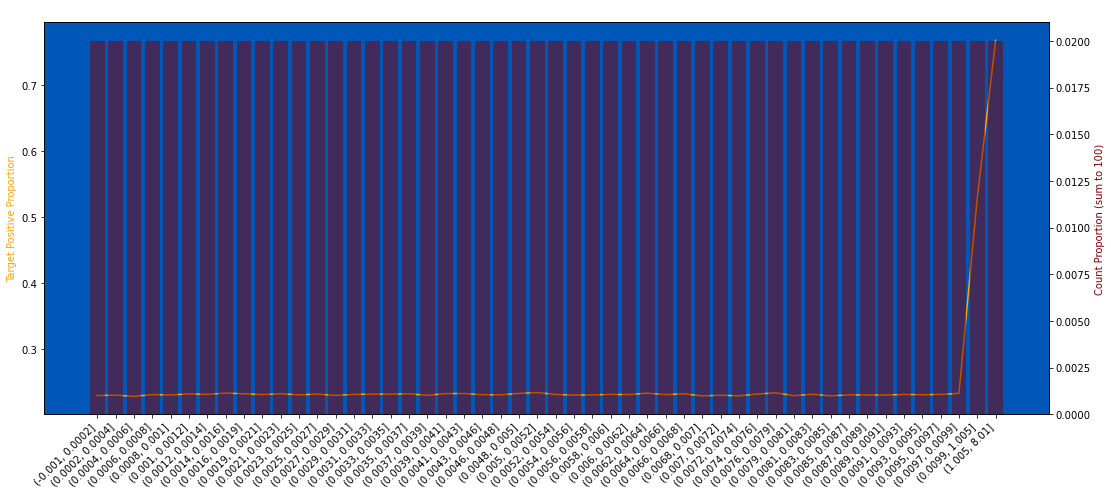

In [224]:
plot_target_check(train, "D_81", q=50, use_raw_bin=True)

In [225]:
%%time
df_list = round_dfs(df_list, col="D_81", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 408 ms, sys: 1.81 s, total: 2.22 s
Wall time: 3.16 s


25687 null count, 0.005 null proportion
0.3798 of the targets have label = 1


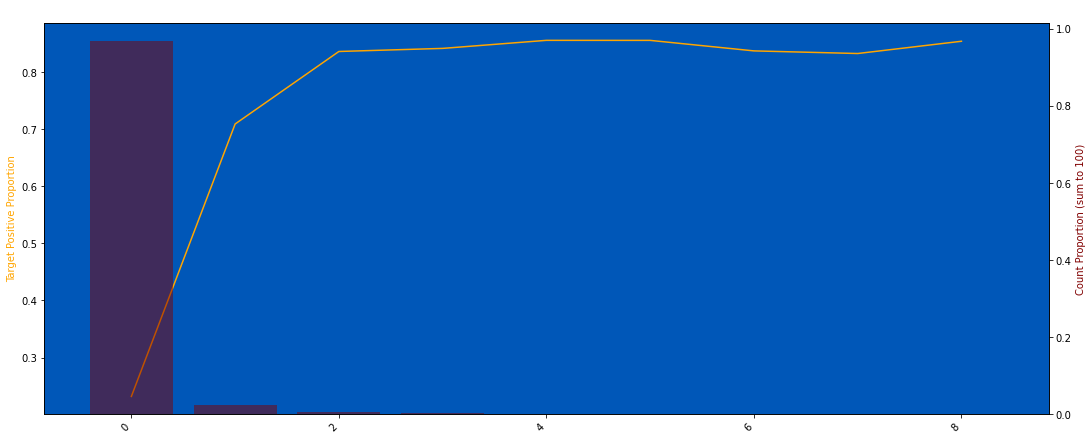

In [226]:
plot_target_check(train, "D_81", q=50, use_raw_bin=True, without_drop_tail=True)

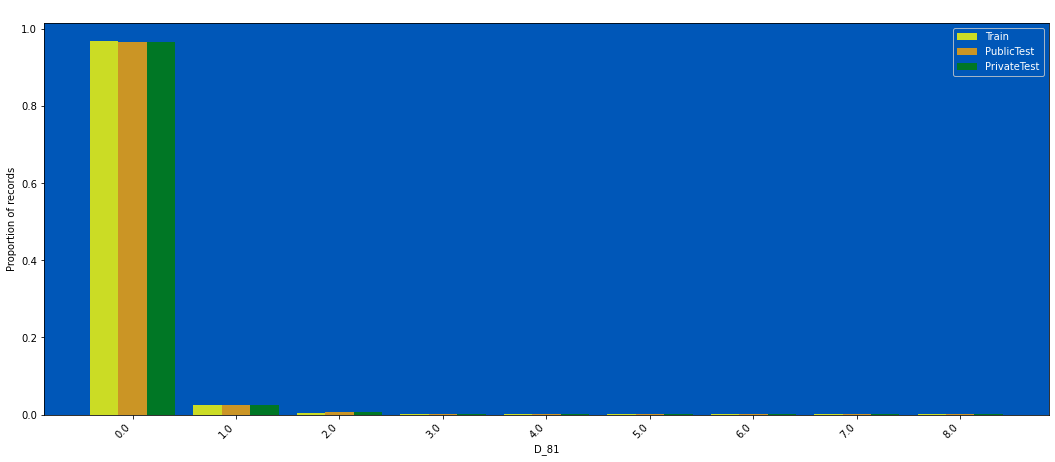

In [227]:
plot_train_test_distribution(df_list, "D_81", nunique_thr=500, without_drop_tail=True)

### D_82

4058614 null count, 0.734 null proportion
0.2648 of the targets have label = 1


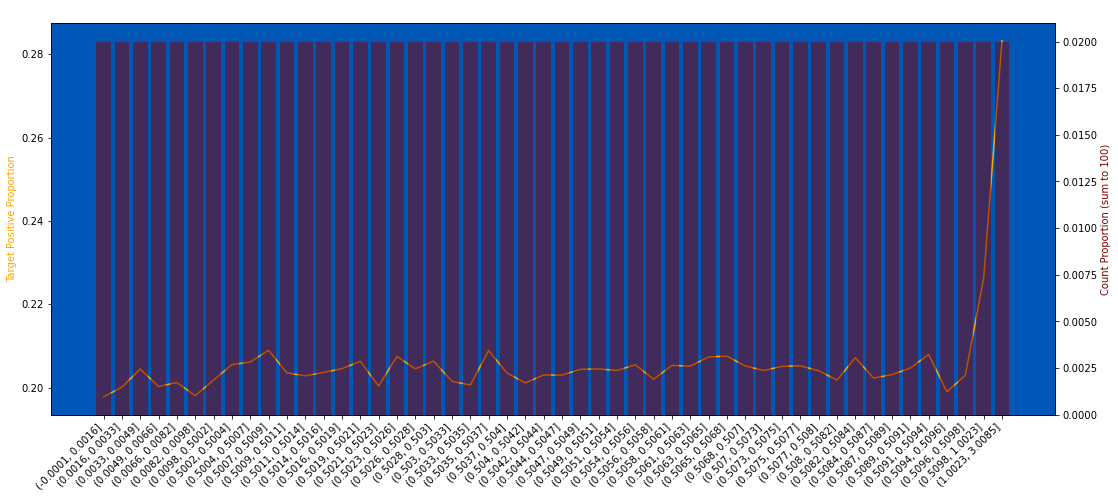

In [228]:
plot_target_check(train, "D_82", q=50, use_raw_bin=True)

In [229]:
%%time
df_list = round_dfs(df_list, col="D_82", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 365 ms, sys: 1.76 s, total: 2.12 s
Wall time: 3.31 s


4058614 null count, 0.734 null proportion
0.2648 of the targets have label = 1


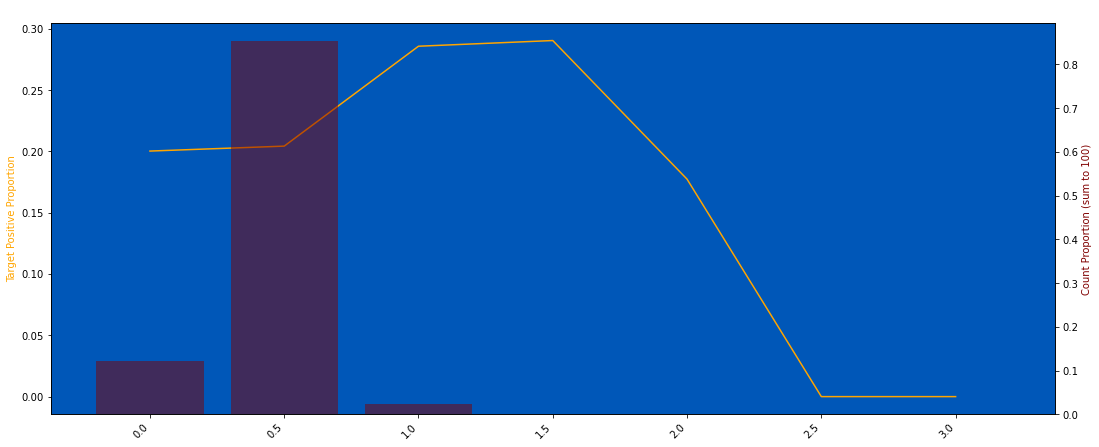

In [230]:
plot_target_check(train, "D_82", q=50, use_raw_bin=True, nunique_thr=3000, strfy_x=True, without_drop_tail=True)

In [231]:
for df in df_list:
    df["D_82_"] = (df["D_82"] * 2).round(0)

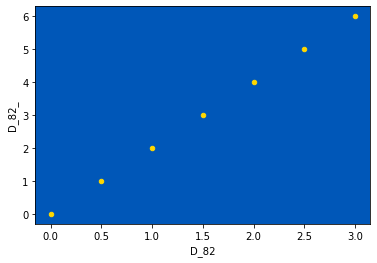

In [232]:
check_binning(train, "D_82", end=50000)

In [233]:
for df in df_list:
    df["D_82"] = (df["D_82"] * 2).round(0)

4058614 null count, 0.734 null proportion
0.2648 of the targets have label = 1


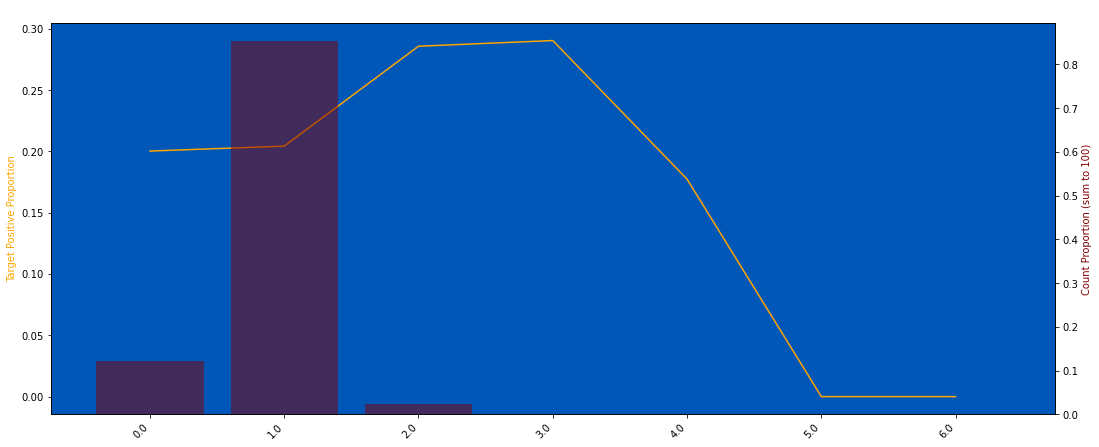

In [234]:
plot_target_check(train, "D_82", q=50, use_raw_bin=True, nunique_thr=3000, strfy_x=True, without_drop_tail=True)

Bottom 1% and Top 1% are dropped from this chart


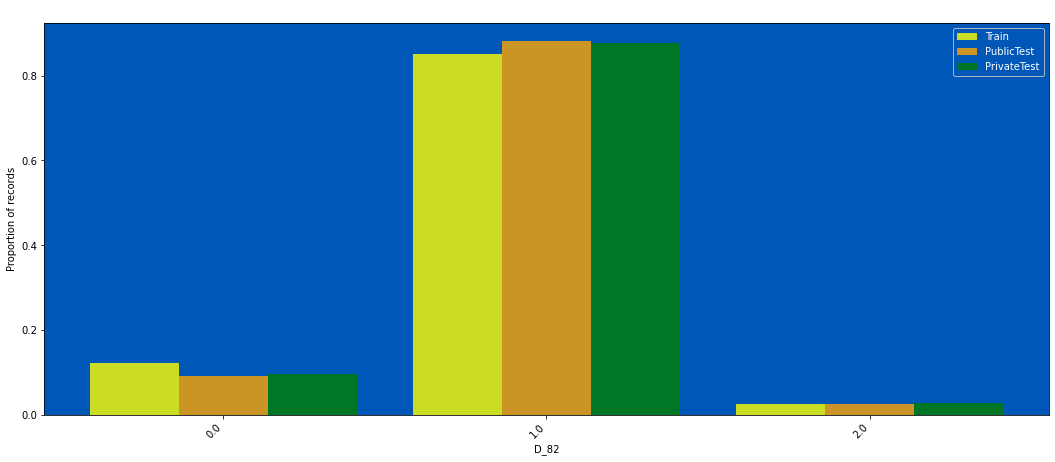

In [235]:
plot_train_test_distribution(df_list, "D_82", nunique_thr=500)

### D_83

194473 null count, 0.035 null proportion
0.4308 of the targets have label = 1


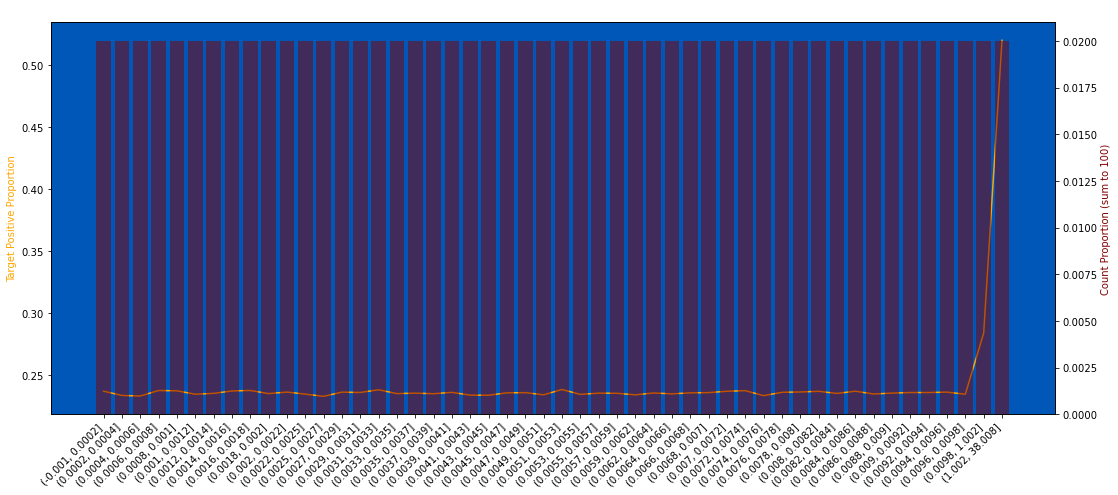

In [236]:
plot_target_check(train, "D_83", q=50, use_raw_bin=True)

In [237]:
%%time
df_list = round_dfs(df_list, col="D_83", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 421 ms, sys: 1.82 s, total: 2.24 s
Wall time: 3.26 s


194473 null count, 0.035 null proportion
0.4308 of the targets have label = 1


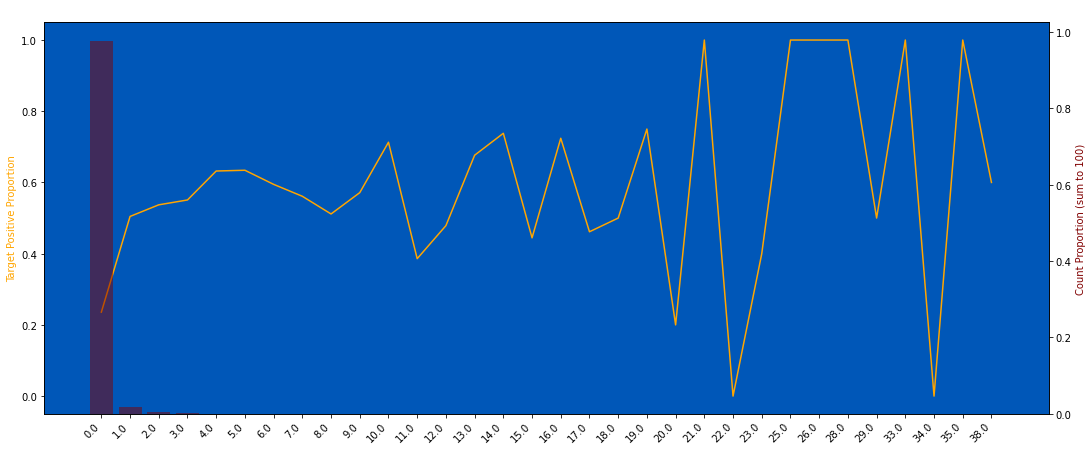

In [238]:
plot_target_check(train, "D_83", q=50, use_raw_bin=True, nunique_thr=3000, strfy_x=True, without_drop_tail=True)

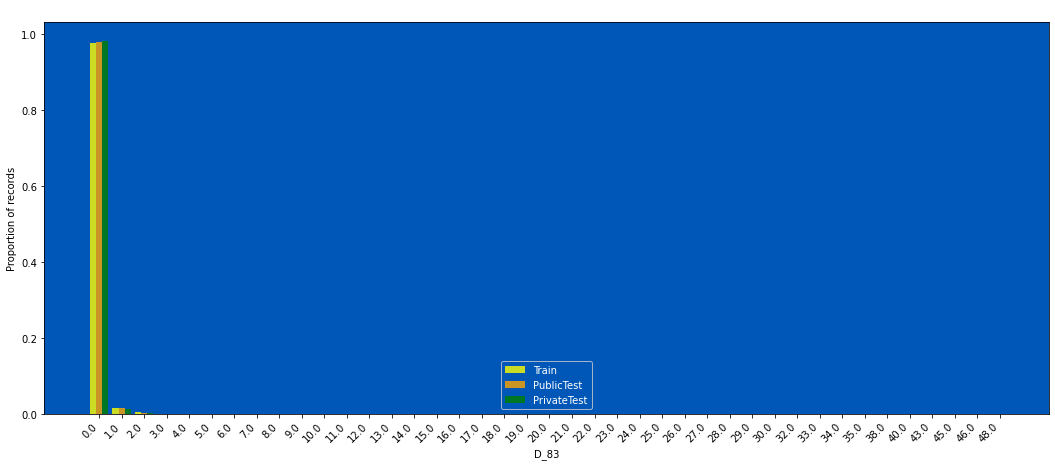

In [239]:
plot_train_test_distribution(df_list, "D_83", nunique_thr=500, without_drop_tail=True)

### D_84

29563 null count, 0.005 null proportion
0.3523 of the targets have label = 1


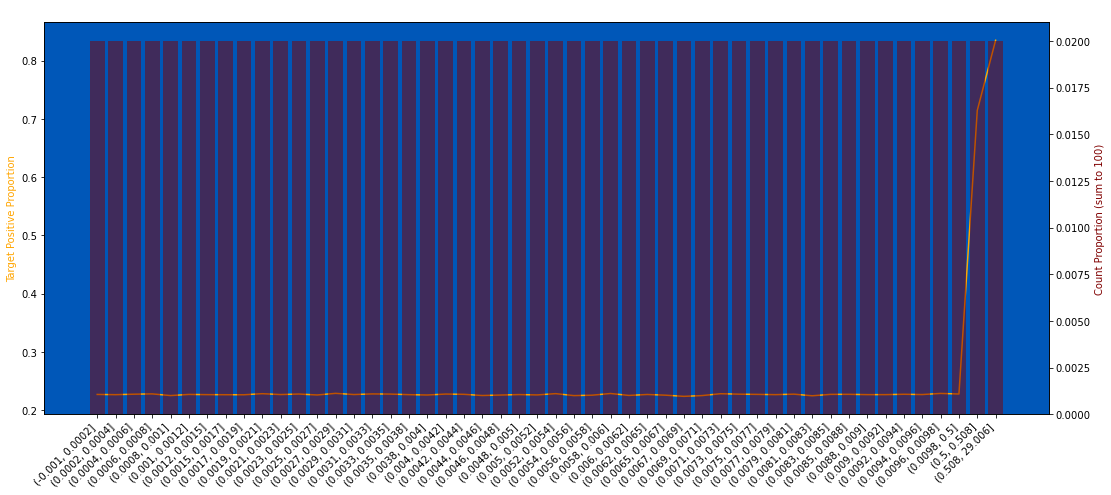

In [240]:
plot_target_check(train, "D_84", q=50, use_raw_bin=True)

In [241]:
%%time
df_list = round_dfs(df_list, col="D_84", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 350 ms, sys: 1.71 s, total: 2.06 s
Wall time: 3.11 s


29563 null count, 0.005 null proportion
0.3523 of the targets have label = 1


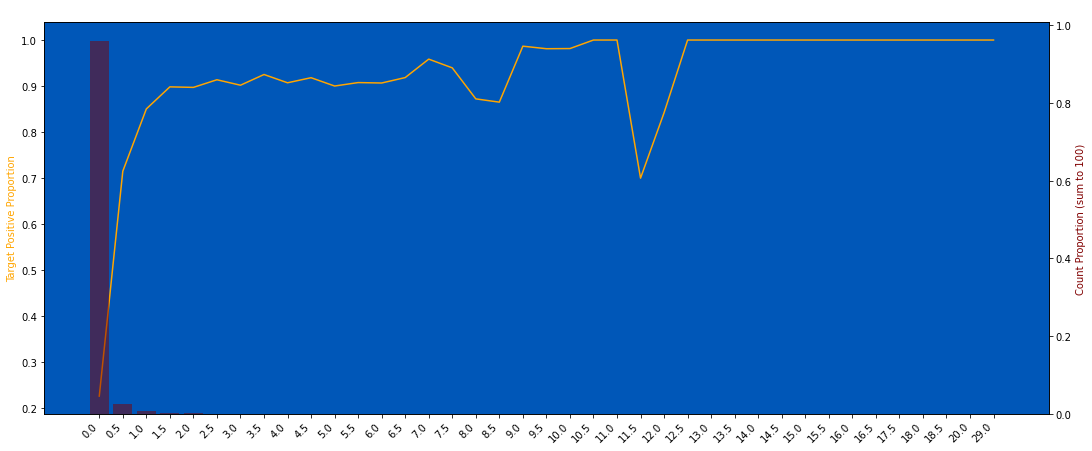

In [242]:
plot_target_check(train, "D_84", q=50, use_raw_bin=True, without_drop_tail=True, strfy_x=True)

In [243]:
for df in df_list:
    df["D_84"] = (df["D_84"] * 2).round(0)

29563 null count, 0.005 null proportion
0.3523 of the targets have label = 1


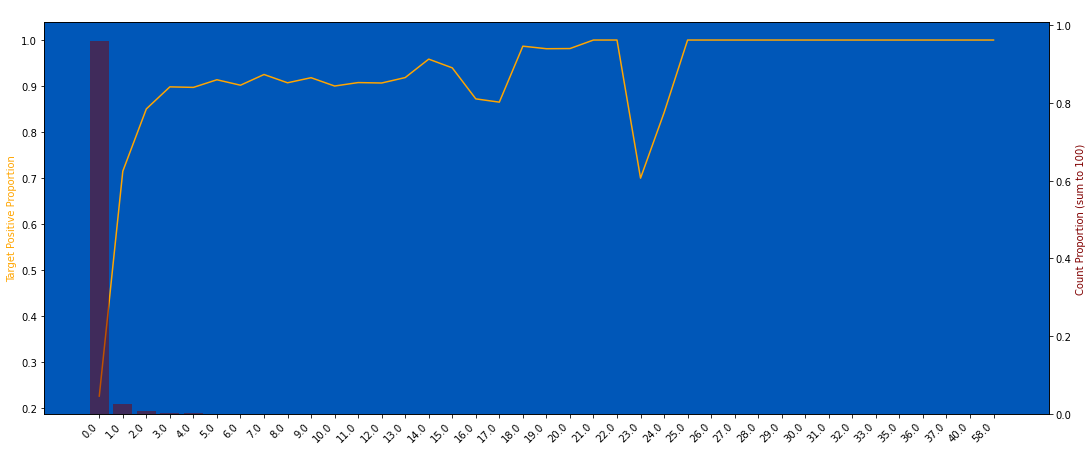

In [244]:
plot_target_check(train, "D_84", q=50, use_raw_bin=True, without_drop_tail=True, strfy_x=True)

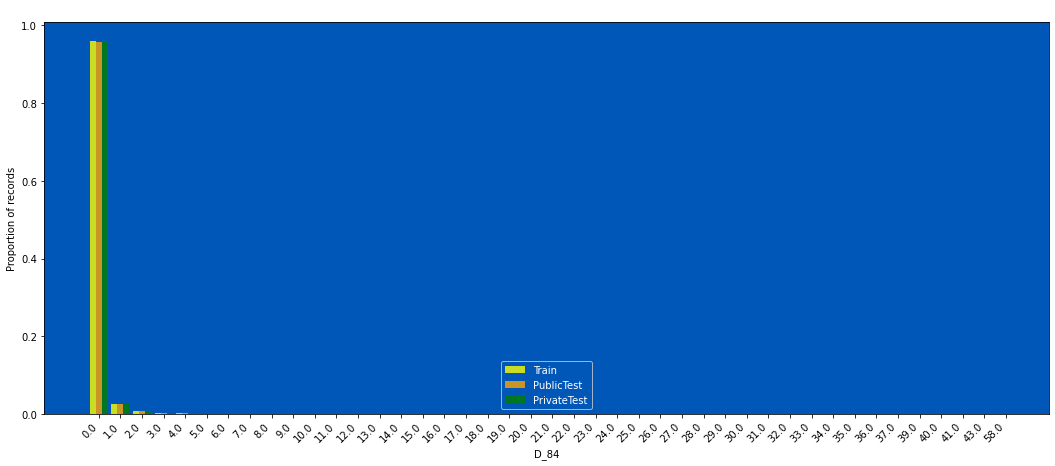

In [245]:
plot_train_test_distribution(df_list, "D_84", nunique_thr=500, without_drop_tail=True)

### D_86

0 null count, 0.000 null proportion
nan of the targets have label = 1


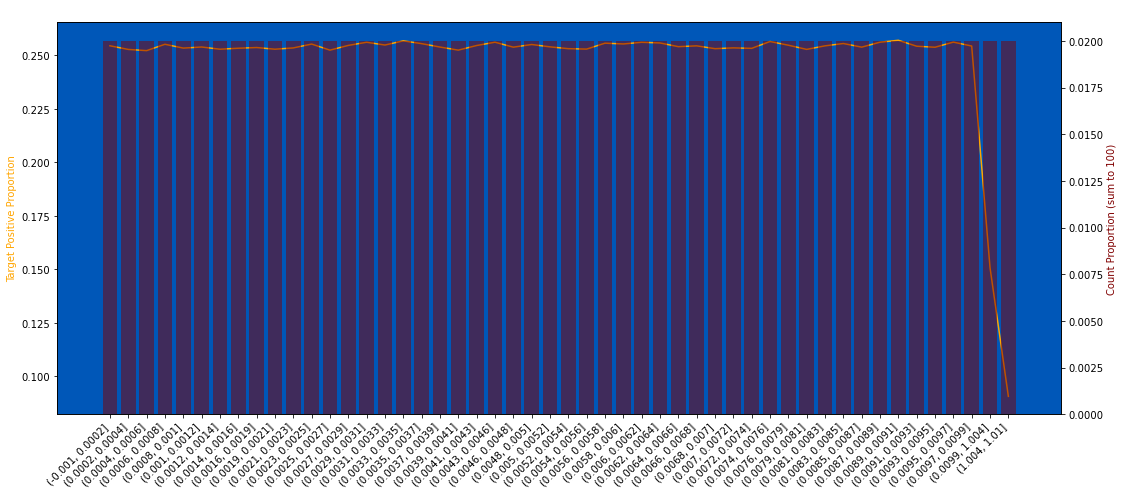

In [246]:
plot_target_check(train, "D_86", q=50, use_raw_bin=True)

In [247]:
%%time
df_list = round_dfs(df_list, col="D_86", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 391 ms, sys: 1.67 s, total: 2.06 s
Wall time: 2.96 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


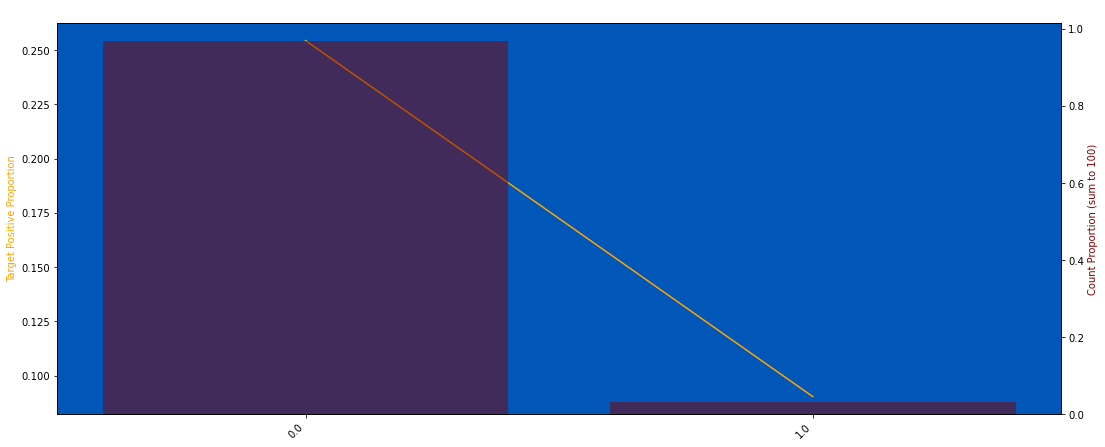

In [248]:
plot_target_check(train, "D_86", q=50, use_raw_bin=True, without_drop_tail=True, nunique_thr=500, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


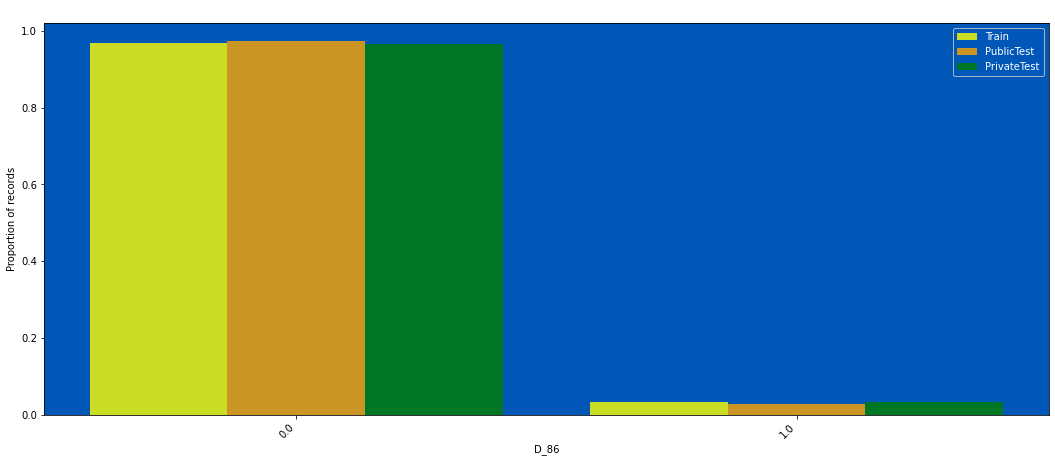

In [249]:
plot_train_test_distribution(df_list, "D_86", nunique_thr=500)

### D_87

5527586 null count, 0.999 null proportion
0.2487 of the targets have label = 1


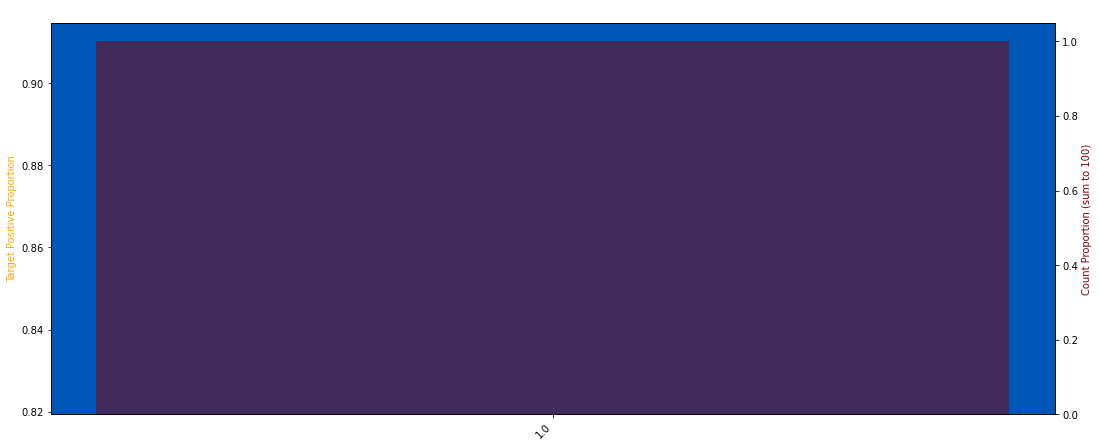

In [250]:
plot_target_check(train, "D_87", q=100, use_raw_bin=True, strfy_x=True, without_drop_tail=True)

In [251]:
train["D_87"].value_counts(), public_test["D_87"].value_counts(), private_test["D_87"].value_counts()

(1.0000    3865
 Name: D_87, dtype: int64,
 1.0000    5116
 Name: D_87, dtype: int64,
 1.0000    5856
 Name: D_87, dtype: int64)

In [252]:
train.groupby("D_87")["target"].mean()

D_87
1.0000   0.8670
Name: target, dtype: float64

In [253]:
%time
for df in df_list:
    df["D_87"] = df["D_87"].fillna(0)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs


### D_88

5525447 null count, 0.999 null proportion
0.2485 of the targets have label = 1


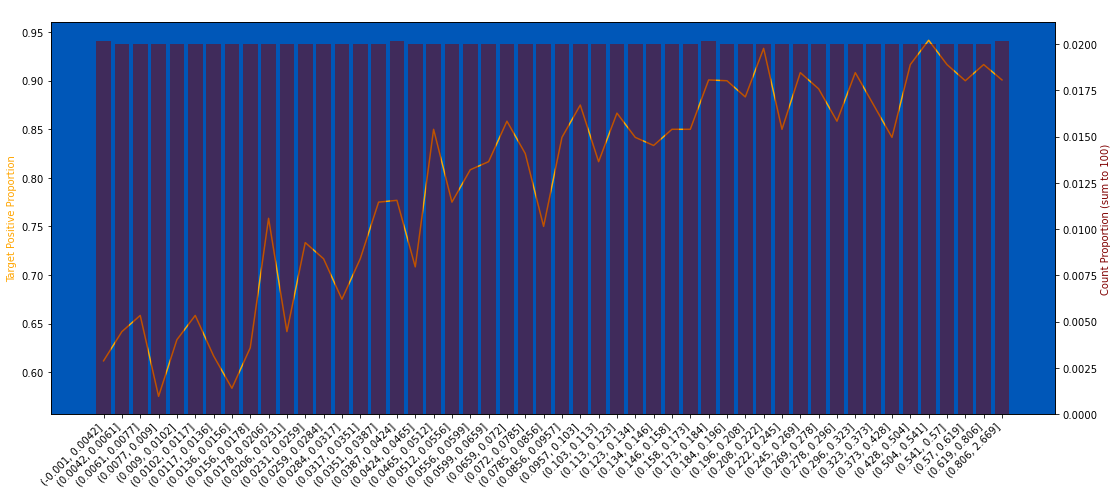

In [254]:
plot_target_check(train, "D_88", q=50, use_raw_bin=True)

In [255]:
%%time
df_list = round_dfs(df_list, col="D_88", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 396 ms, sys: 1.6 s, total: 1.99 s
Wall time: 3.13 s


5525447 null count, 0.999 null proportion
0.2485 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


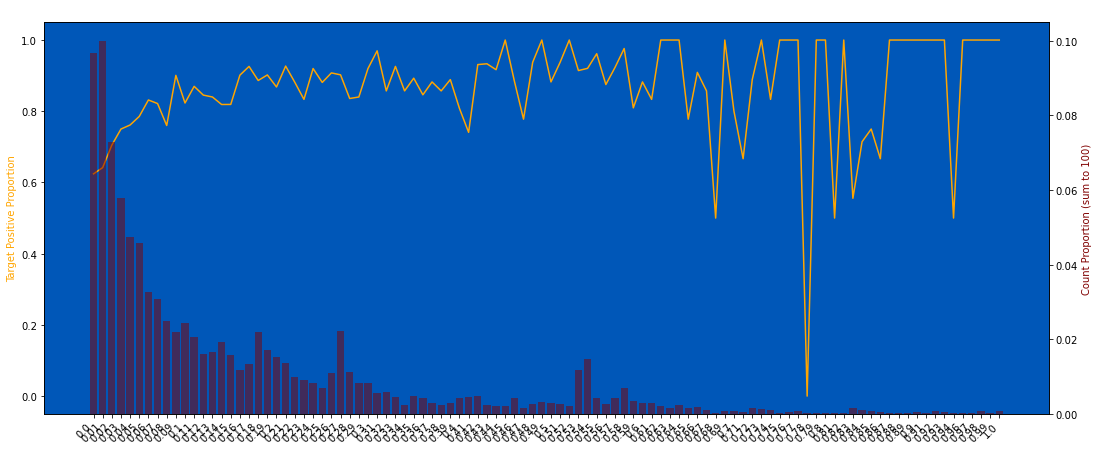

In [256]:
plot_target_check(train, "D_88", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


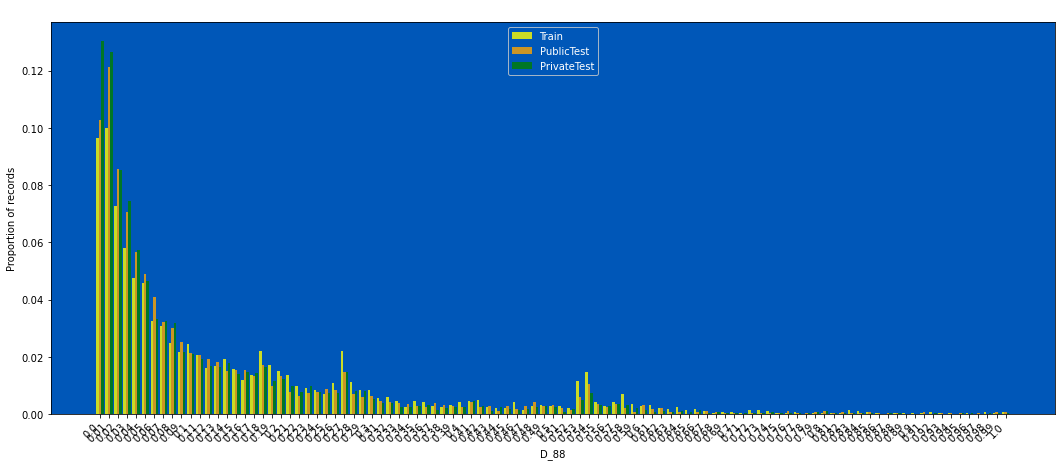

In [257]:
plot_train_test_distribution(df_list, "D_88", nunique_thr=500)

**Train Test Drift: Moderate**

### D_89

29563 null count, 0.005 null proportion
0.3523 of the targets have label = 1


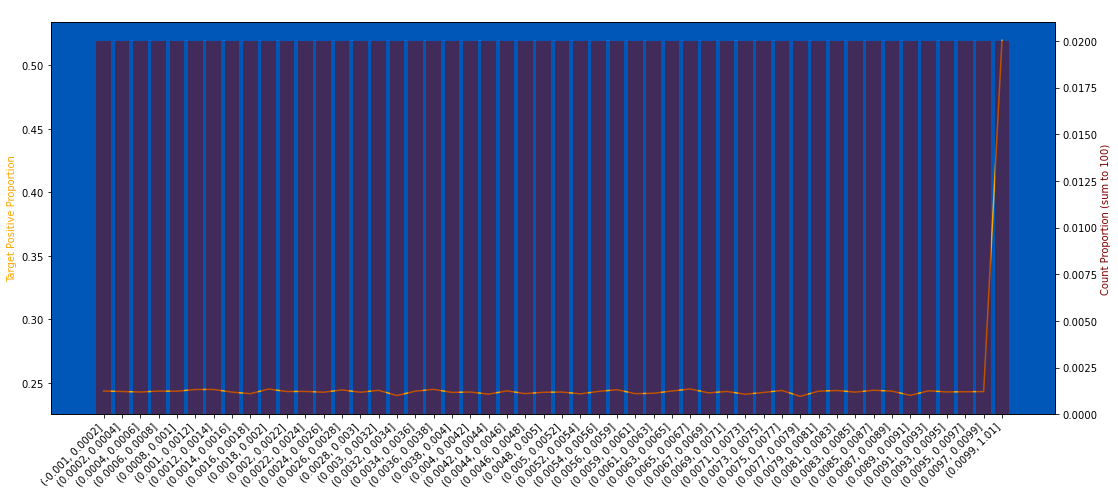

In [258]:
plot_target_check(train, "D_89", q=50, use_raw_bin=True, nunique_thr=12)

In [259]:
%%time
df_list = round_dfs(df_list, col="D_89", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 347 ms, sys: 1.56 s, total: 1.91 s
Wall time: 3 s


29563 null count, 0.005 null proportion
0.3523 of the targets have label = 1


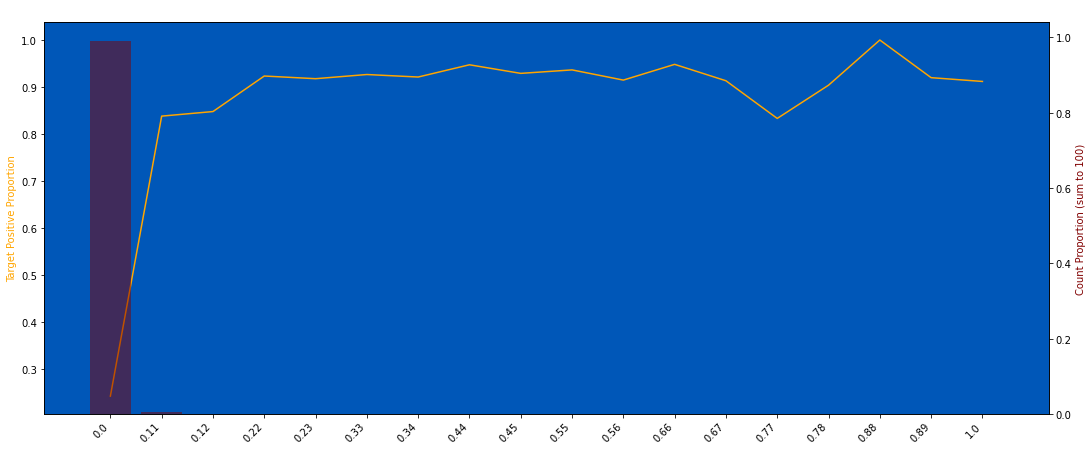

In [260]:
plot_target_check(train, "D_89", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [261]:
for df in df_list:
    df["D_89_"] = (df["D_89"] * 100/11).round(0)

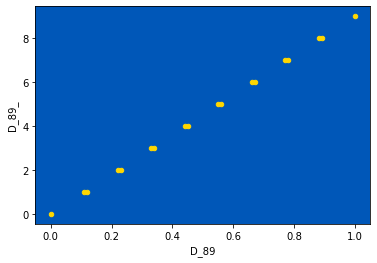

In [262]:
check_binning(train, "D_89", end=600000)

In [263]:
for df in df_list:
    df["D_89"] = (df["D_89"] * 100/11).round(0)

29563 null count, 0.005 null proportion
0.3523 of the targets have label = 1


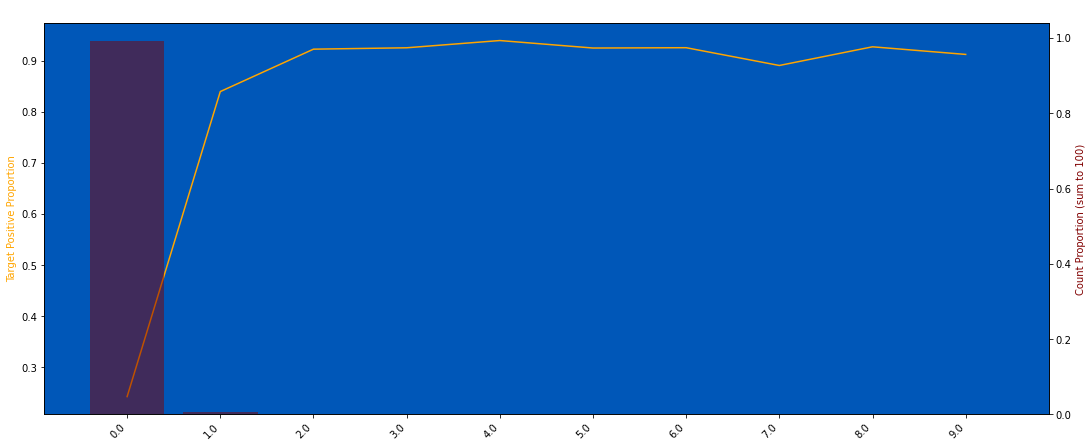

In [264]:
plot_target_check(train, "D_89", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

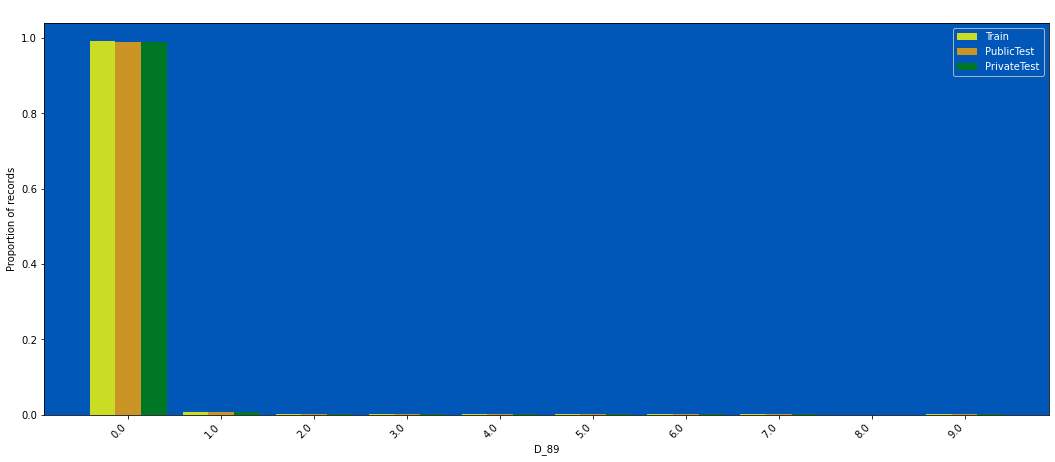

In [265]:
plot_train_test_distribution(df_list, "D_89", nunique_thr=500, without_drop_tail=True)

### D_91

157216 null count, 0.028 null proportion
0.4663 of the targets have label = 1


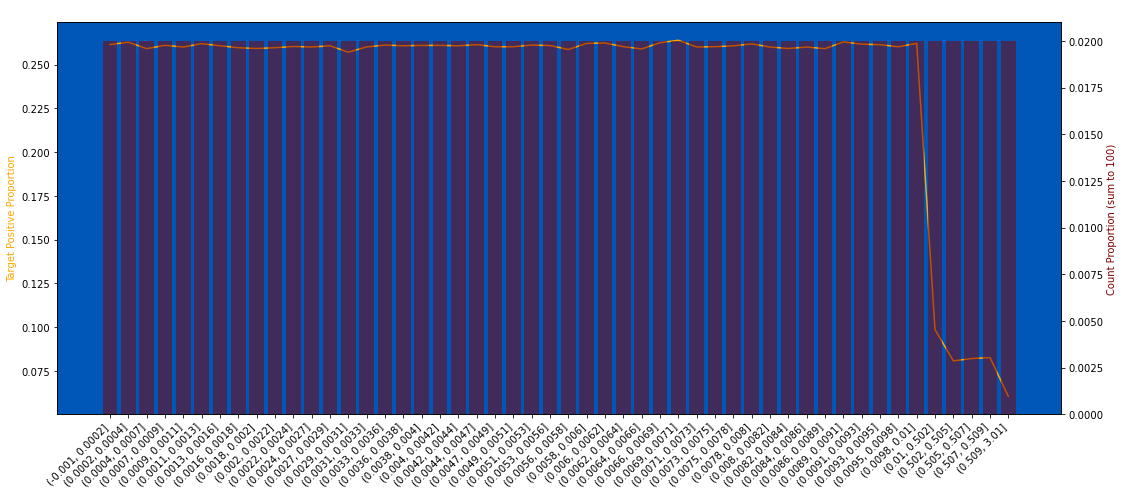

In [266]:
plot_target_check(train, "D_91", q=50, use_raw_bin=True)

In [267]:
%%time
df_list = round_dfs(df_list, col="D_91", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 388 ms, sys: 1.54 s, total: 1.93 s
Wall time: 2.86 s


157216 null count, 0.028 null proportion
0.4663 of the targets have label = 1


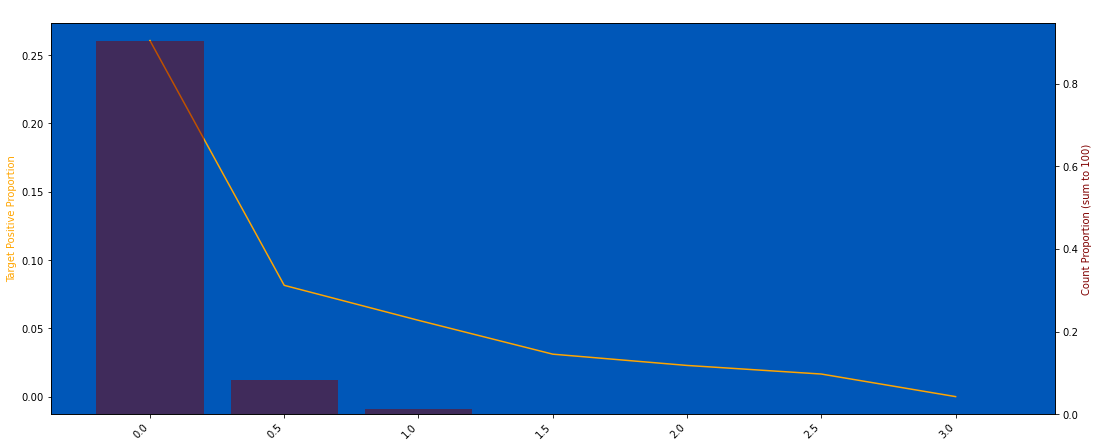

In [268]:
plot_target_check(train, "D_91", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [269]:
for df in df_list:
    df["D_91"] = (df["D_91"] * 2).round(0)

157216 null count, 0.028 null proportion
0.4663 of the targets have label = 1


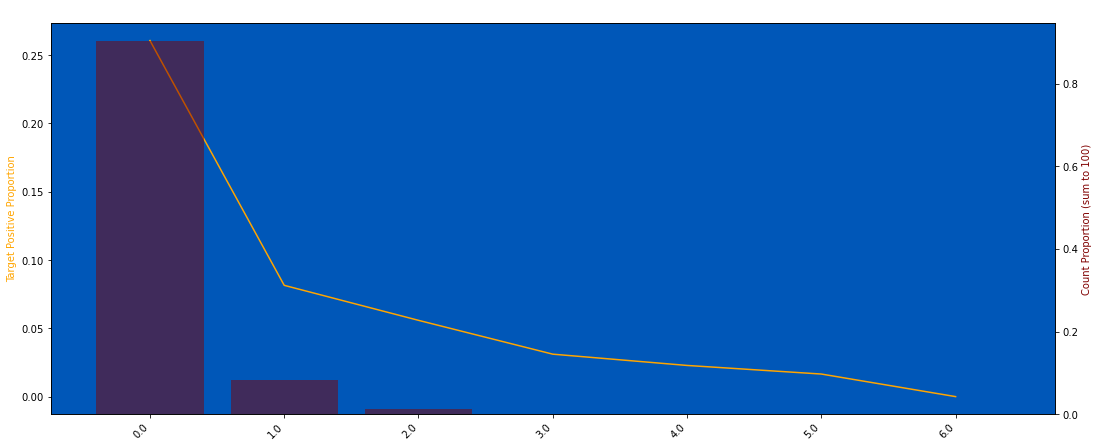

In [270]:
plot_target_check(train, "D_91", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

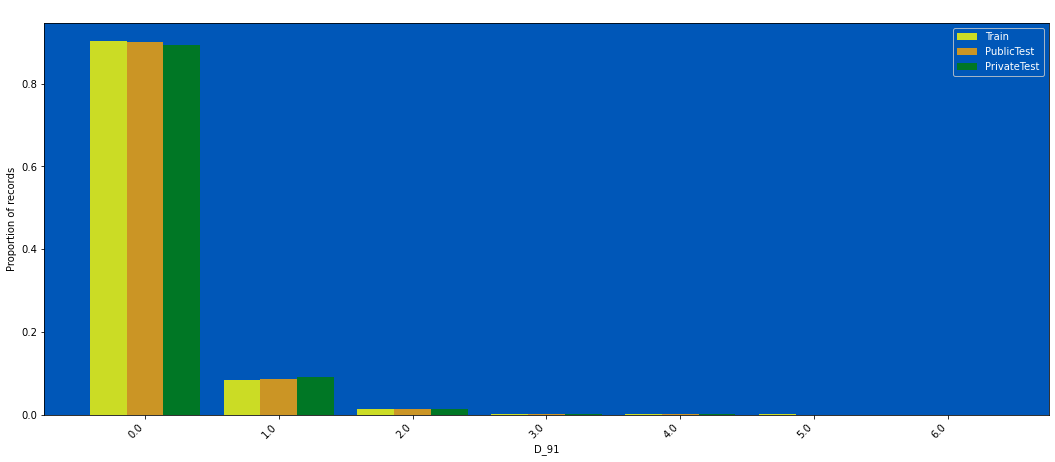

In [271]:
plot_train_test_distribution(df_list, "D_91", nunique_thr=12)

### D_92

0 null count, 0.000 null proportion
nan of the targets have label = 1


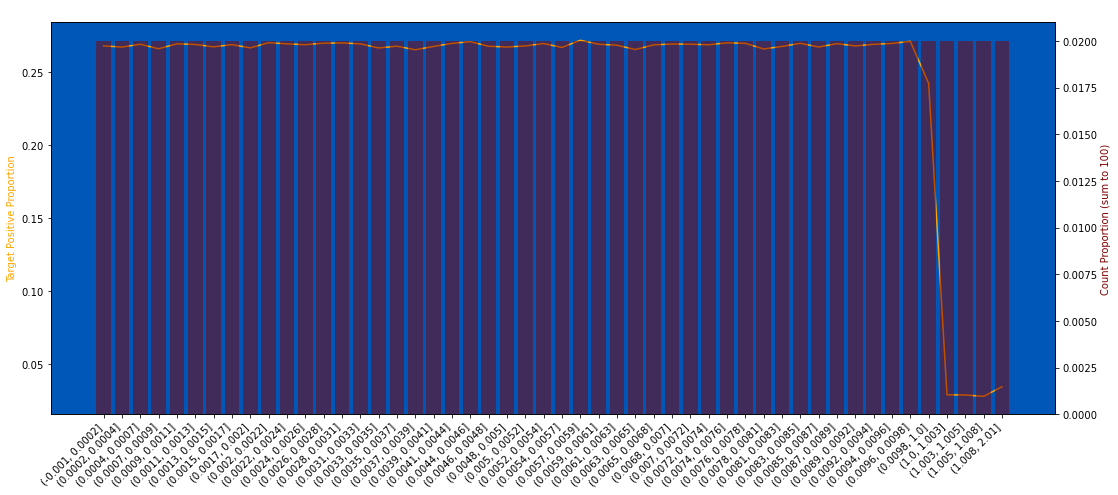

In [272]:
plot_target_check(train, "D_92", q=50, use_raw_bin=True)

In [273]:
%%time
df_list = round_dfs(df_list, col="D_92", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 376 ms, sys: 1.58 s, total: 1.95 s
Wall time: 2.87 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


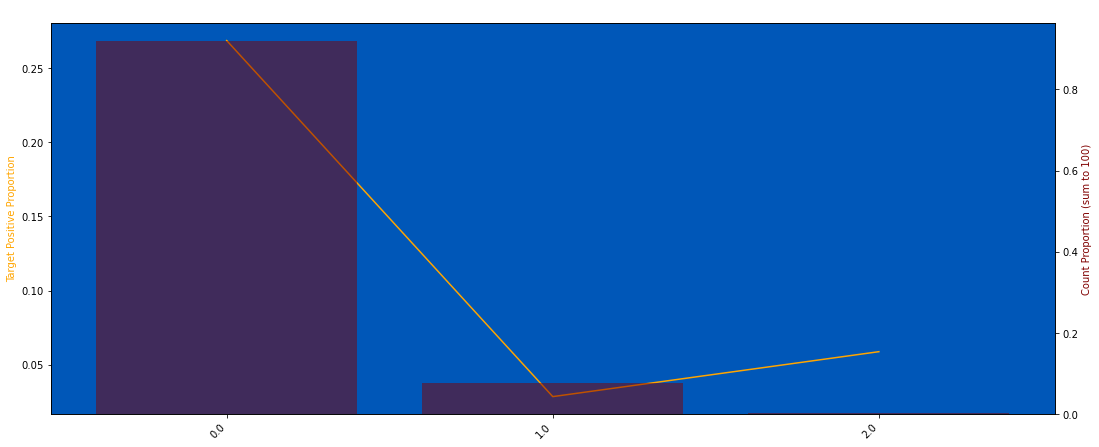

In [274]:
plot_target_check(train, "D_92", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

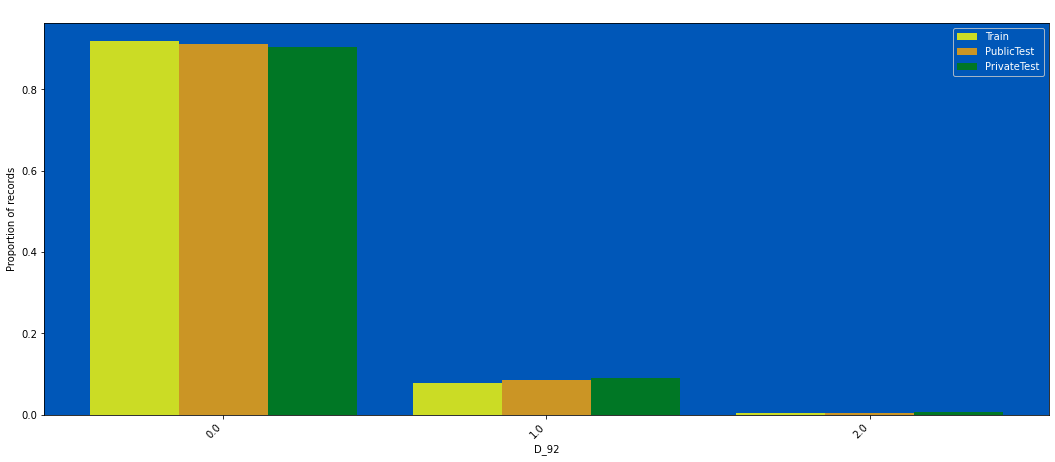

In [275]:
plot_train_test_distribution(df_list, "D_92", nunique_thr=12)

### D_93

0 null count, 0.000 null proportion
nan of the targets have label = 1


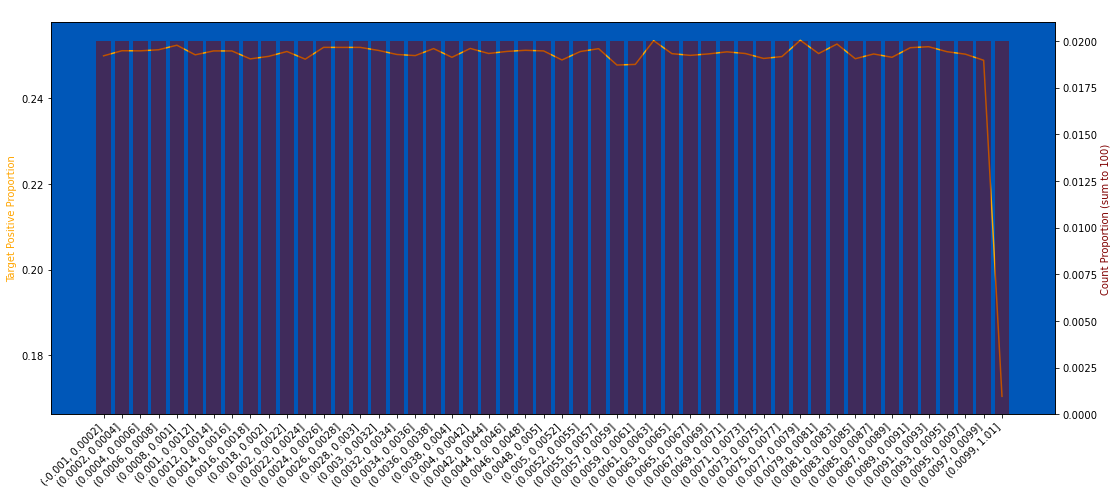

In [276]:
plot_target_check(train, "D_93", q=50, use_raw_bin=True)

In [277]:
%%time
df_list = round_dfs(df_list, col="D_93", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 389 ms, sys: 1.53 s, total: 1.92 s
Wall time: 2.83 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


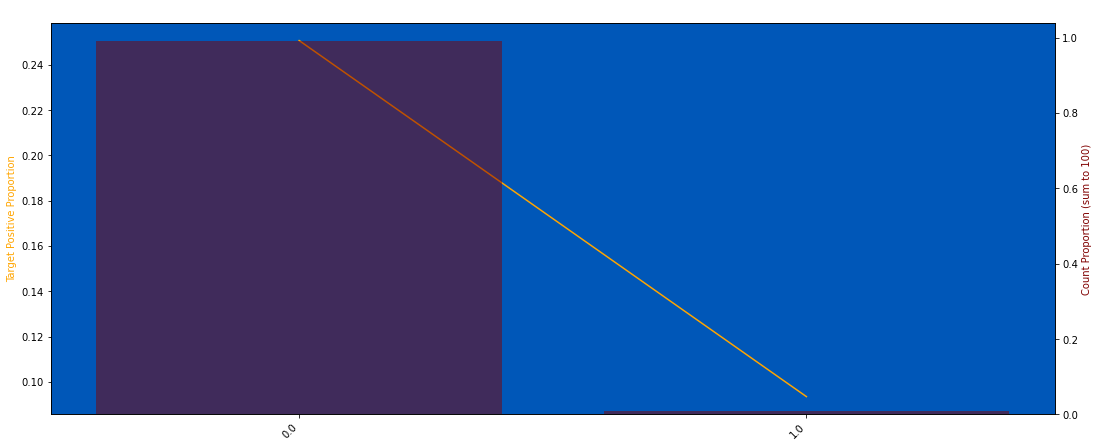

In [278]:
plot_target_check(train, "D_93", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

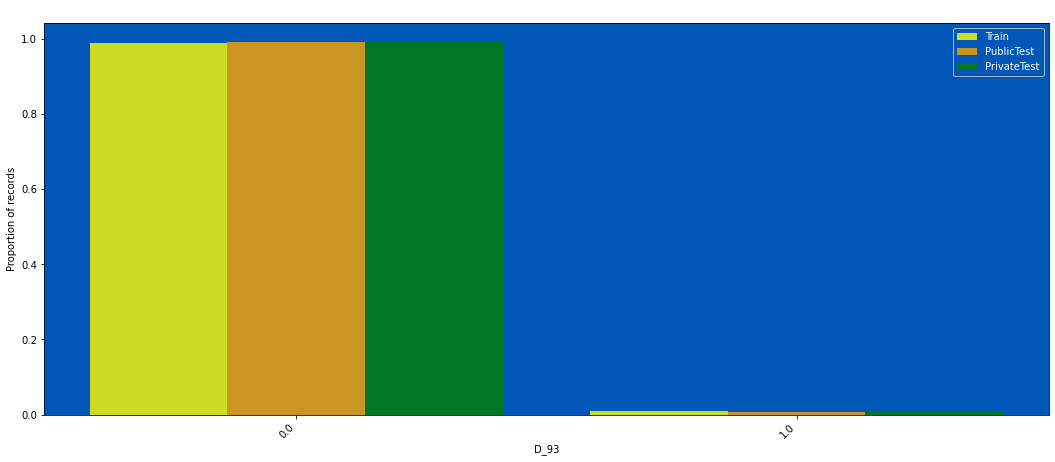

In [279]:
plot_train_test_distribution(df_list, "D_93", nunique_thr=12)

### D_94

0 null count, 0.000 null proportion
nan of the targets have label = 1


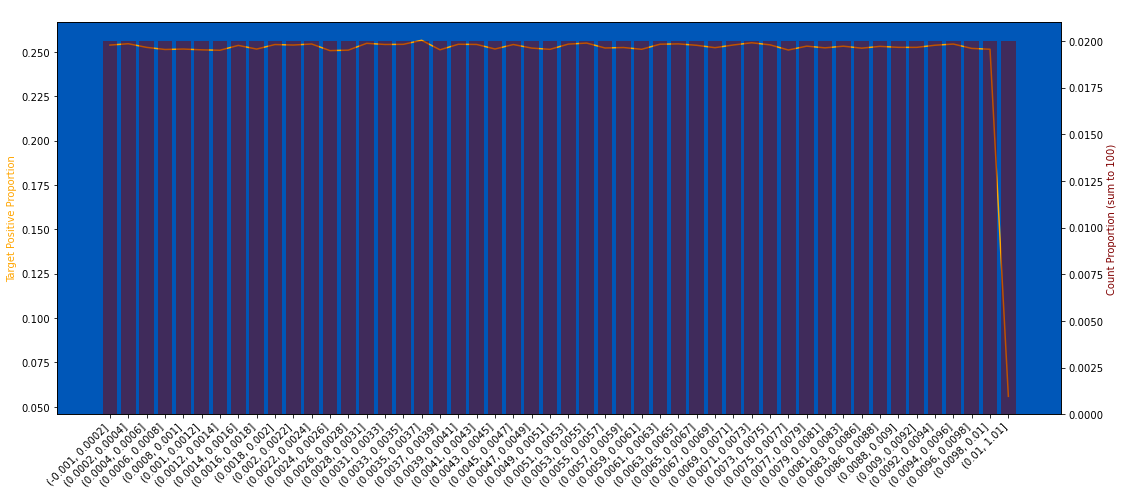

In [280]:
plot_target_check(train, "D_94", q=50, use_raw_bin=True)

In [281]:
%%time
df_list = round_dfs(df_list, col="D_94", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 390 ms, sys: 1.59 s, total: 1.98 s
Wall time: 2.89 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


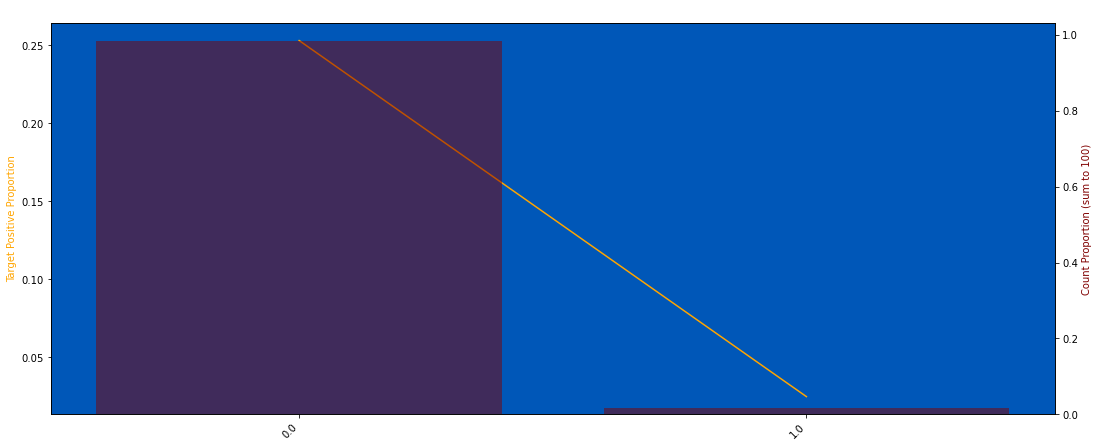

In [282]:
plot_target_check(train, "D_94", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

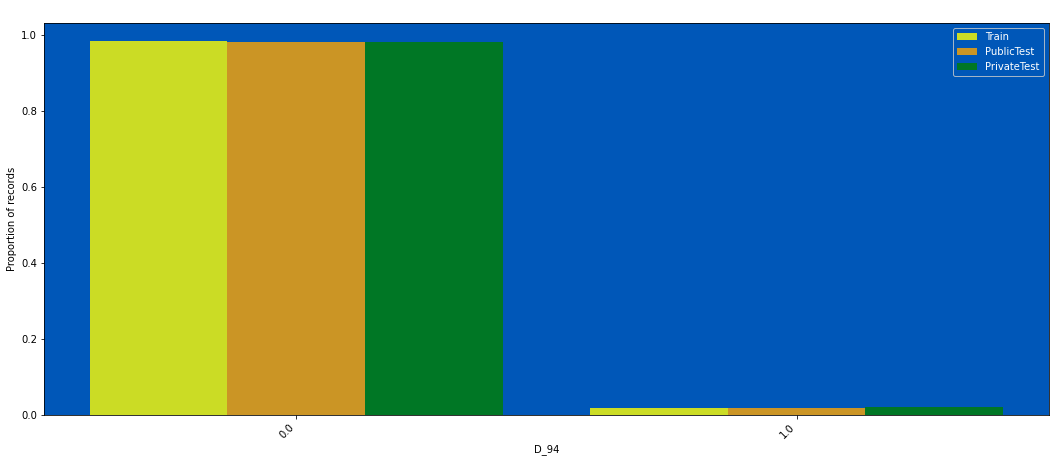

In [283]:
plot_train_test_distribution(df_list, "D_94", nunique_thr=12)

### D_96

0 null count, 0.000 null proportion
nan of the targets have label = 1


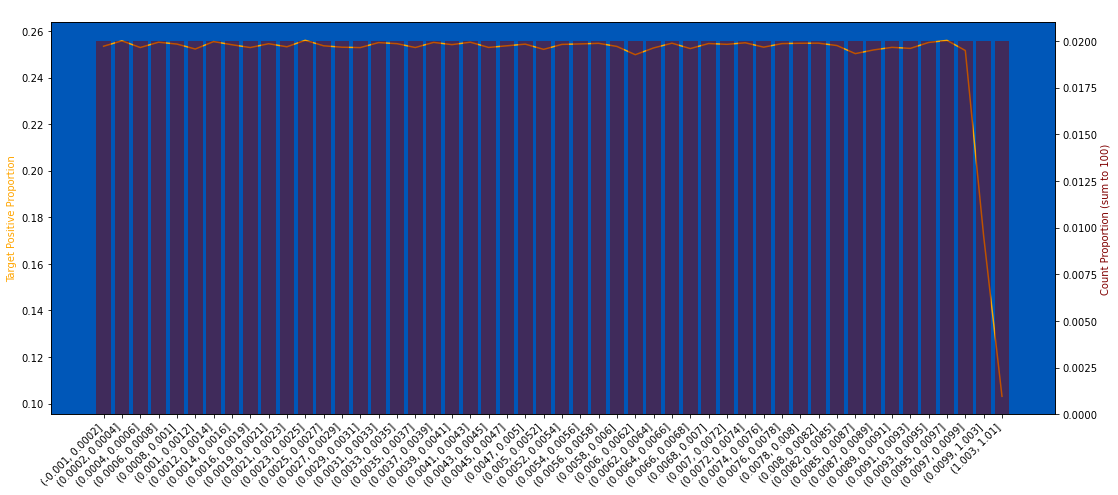

In [284]:
plot_target_check(train, "D_96", q=50, use_raw_bin=True)

In [285]:
%%time
df_list = round_dfs(df_list, col="D_96", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 378 ms, sys: 1.6 s, total: 1.98 s
Wall time: 2.89 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


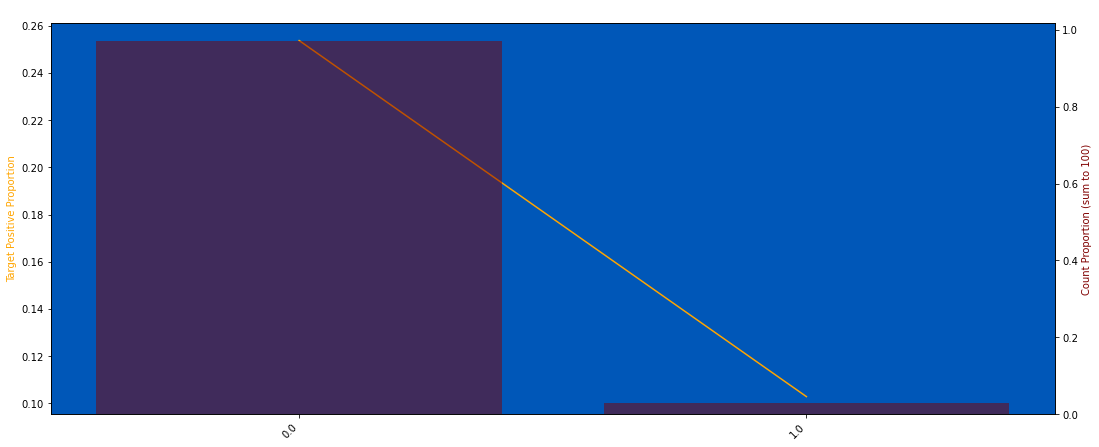

In [286]:
plot_target_check(train, "D_96", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

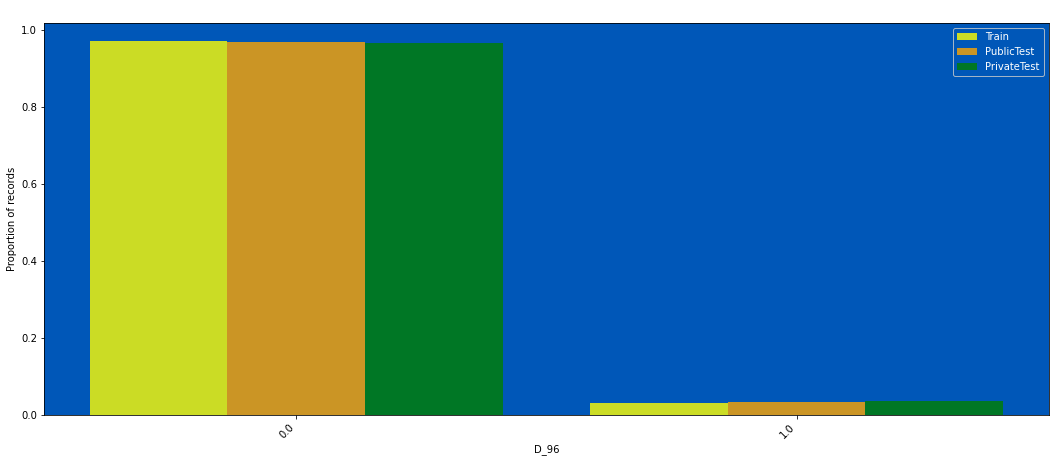

In [287]:
plot_train_test_distribution(df_list, "D_96", nunique_thr=12)

### Column checking

In [288]:
from tqdm import tqdm

In [289]:
no_use_features = ["temp"] + df_list[0].columns[df_list[0].columns.str.endswith("_")].tolist()
no_use_features

['temp',
 'D_39_',
 'D_44_',
 'D_51_',
 'D_70_',
 'D_72_',
 'D_74_',
 'D_75_',
 'D_78_',
 'D_79_',
 'D_80_',
 'D_82_',
 'D_89_']

In [290]:
%%time
for df in tqdm(df_list):
    df.drop(columns=no_use_features, errors="ignore", inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.66s/it]

CPU times: user 1.04 s, sys: 3.37 s, total: 4.41 s
Wall time: 5.01 s


In [291]:
all_columns = get_cols(df_list[0], ["D_"])
print(all_columns)

['D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_66', 'D_68', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_84', 'D_86', 'D_87', 'D_88', 'D_89', 'D_91', 'D_92', 'D_93', 'D_94', 'D_96']


In [292]:
d_col_nunique = df_list[0][all_columns].nunique()
less_unique_d_cols = d_col_nunique[d_col_nunique < 99].index.tolist()
for d in less_unique_d_cols:
    if df_list[0][d].dtype != np.int32:
        print(d, ":", df_list[0][d].dtype, "\n", sorted(df_list[0][d].unique().tolist()), "\n")

D_44 : float64 
 [0.0, 1.0, nan, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 32.0, 34.0, 37.0, 41.0, 42.0, 43.0, 44.0, 45.0] 

D_51 : float64 
 [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0] 

D_54 : float64 
 [0.0, 1.0, nan] 

D_63 : int8 
 [0, 1, 2, 3, 4, 5] 

D_64 : int8 
 [-1, 0, 1, 2, 3] 

D_66 : float64 
 [nan, 0.0, 1.0] 

D_68 : int8 
 [-1, 0, 1, 2, 3, 4, 5, 6] 

D_70 : float64 
 [0.0, 1.0, 2.0, 3.0, 4.0, nan, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0] 

D_72 : float64 
 [0.0, 1.0, 2.0, 3.0, nan, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0] 

D_74 : float64 
 [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, nan, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 4

In [293]:
cols = list(
    set(less_unique_d_cols)
)

In [294]:
for col in tqdm(cols):
    for df in df_list:
        df[col] = integerize(df[col])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:15<00:00,  1.66it/s]


In [295]:
%%time
train = df_list[0]
test = pd.concat(df_list[1:], axis=0)
test = test.sort_values(by=["customer_ID", "S_2"]).reset_index(drop=True)

CPU times: user 5.42 s, sys: 6.24 s, total: 11.7 s
Wall time: 16 s


In [296]:
train.shape, test.shape

((5531451, 55), (11363762, 54))

In [297]:
float64_columns = train.select_dtypes("float64").columns.tolist()
for col in float64_columns:
    temp = df_list[-1][col].astype(np.float32).values
    if (temp - df_list[-1][col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to float32")
        for df in df_list:
            df[col] = df[col].astype(np.float32)

D_39 fulfill criteria to convert to float32
D_41 fulfill criteria to convert to float32
D_42 fulfill criteria to convert to float32
D_43 fulfill criteria to convert to float32
D_45 fulfill criteria to convert to float32
D_46 fulfill criteria to convert to float32
D_47 fulfill criteria to convert to float32
D_48 fulfill criteria to convert to float32
D_49 fulfill criteria to convert to float32
D_50 fulfill criteria to convert to float32
D_52 fulfill criteria to convert to float32
D_53 fulfill criteria to convert to float32
D_55 fulfill criteria to convert to float32
D_56 fulfill criteria to convert to float32
D_58 fulfill criteria to convert to float32
D_59 fulfill criteria to convert to float32
D_60 fulfill criteria to convert to float32
D_61 fulfill criteria to convert to float32
D_62 fulfill criteria to convert to float32
D_65 fulfill criteria to convert to float32
D_71 fulfill criteria to convert to float32
D_73 fulfill criteria to convert to float32
D_76 fulfill criteria to convert

In [298]:
for d in tqdm(all_columns):
    for df in df_list:
        df[d] = df[d].fillna(-127)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 27.62it/s]


In [299]:
%%time
train.to_parquet(f"{INTERIM_TRAIN_PARQUET_PATH}/delinquency_part1.parquet")
test.to_parquet(f"{INTERIM_TEST_PARQUET_PATH}/delinquency_part1.parquet")

CPU times: user 12.3 s, sys: 1.37 s, total: 13.7 s
Wall time: 12.4 s


In [303]:
test.shape

(11363762, 54)

In [300]:
END = time.time()

In [301]:
print(f"{END - START:.2f} seconds elapsed")

690.90 seconds elapsed


In [302]:
t = read_file(f"{INTERIM_TRAIN_PARQUET_PATH}/delinquency_part1.parquet", replace_negative127=False)

Shape of data: (5531451, 55)
